In [1]:
import imageio
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torchvision
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

from q_VAENN import VAE as Q_VAE
from c_VAENN import VAE as C_VAE
from c_NN import ClassifierNN
from FIDScore import compute_fid_score as FID

In [2]:
to_pil_image = transforms.ToPILImage() 
matplotlib.style.use('ggplot')
seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

Hyperparameters

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
q_VAE = Q_VAE()
c_VAE = C_VAE()
Classifier = ClassifierNN()
Classifier.load_state_dict(torch.load("Models/Classifier_for_MNIST.pth"))

lr = 0.001
epochs = 200
batch_size = 400
q_optimizer = optim.Adam(q_VAE.parameters(), lr = lr)
c_optimizer = optim.Adam(c_VAE.parameters(), lr = lr)
criterion = nn.BCELoss(reduction = 'sum')
q_grid_images = []
c_grid_images = []

In [4]:
def image_to_vid(input_images, 
                 q_processing):
    images = [np.array(to_pil_image(image)) for image in input_images]
    if q_processing:
        imageio.mimsave('Outputs/Directpassing-Generated-Images.gif', images)
    else:
        imageio.mimsave('Outputs/C-Generated-Images.gif', images)

In [ ]:
def save_reconstructed_images(images, epoch, 
                              random_noise,
                              q_processing):
    if q_processing:
        if random_noise:
            save_image(images.cpu(), f"Outputs/Q-Images/D-Images with Random Noise-{epoch}.jpg")
        else:
            save_image(images.cpu(), f"Outputs/Q-Images/D-Epoch-{epoch}.jpg")
    
    else:
        if random_noise:
            save_image(images.cpu(), f"Outputs/C-Images/C-Images with Random Noise-{epoch}.jpg")
        else:
            save_image(images.cpu(), f"Outputs/C-Images/C-Epoch-{epoch}.jpg")

In [32]:
def save_loss_plot(c_train_loss, 
                   c_valid_loss,
                   q_train_loss,
                   q_valid_loss):
    plt.figure(figsize = (10, 7))
    plt.plot(q_train_loss, color = 'orange', label = 'CDP-Train loss')
    plt.plot(q_valid_loss, color = 'yellow', label = 'CDP-Validation loss')
    plt.plot(c_train_loss, color = 'red', label = 'C-Train loss')
    plt.plot(c_valid_loss, color = 'blue', label = 'C-Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('Outputs/Directpassing-classicalLoss.jpg')
    plt.show()

In [33]:
def save_accuracy_plot(q_accuracy,
                       c_accuracy):
    plt.figure(figsize = (10, 7))
    plt.plot(q_accuracy, color = 'orange', label = 'CDP-Accuracy')
    plt.plot(c_accuracy, color = 'red', label = 'C-Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('Outputs/Directpassing-classicalAccuracy.jpg')
    plt.show()

In [37]:
def save_fid_plot(c_fid_score_latent_space, 
                  c_fid_score_random_noise,
                  q_fid_score_latent_space, 
                  q_fid_score_random_noise):
    plt.figure(figsize = (10, 7))
    plt.plot(q_fid_score_latent_space, color = 'orange', label = 'CDP-Image Reconstruction')
    plt.plot(q_fid_score_random_noise, color = 'yellow', label = 'CDP-Image Generation from Random Noise')
    plt.plot(c_fid_score_latent_space, color = 'red', label = 'C-Image Reconstruction')
    plt.plot(c_fid_score_random_noise, color = 'blue', label = 'C-Image Generation from Random Noise')
    plt.xlabel('Epochs')
    plt.ylabel('FID Score')
    plt.legend()
    plt.savefig('Outputs/Quantum FID Score.jpg')
    plt.show()

In [9]:
def loss_function(criterion, reconstructed_images, real_images, mu, logvar):
    
    BCE = criterion(reconstructed_images, real_images) 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [10]:
import torch
import torch.nn.functional as F

def compute_mse(reconstructed_images, real_images):
   # print(reconstructed_images.shape)
   # print("real image", real_images.shape)
    # Calculate Mean Squared Error
    return F.mse_loss(reconstructed_images, real_images)

In [11]:
def train(q_VAE,
          c_VAE, 
          dataloader, 
          device, 
          q_optimizer,
          c_optimizer, 
          criterion, 
          batch_size):
    q_VAE.train()
    c_VAE.train()
    q_running_loss = 0.0
    c_running_loss = 0.0
    q_running_mse = 0.0
    c_running_mse = 0.0

    for i, data in tqdm(enumerate(dataloader), total=len(dataloader)):
        q_images = data[0].to(device)
        real_images = data[1].to(device)
        
        q_optimizer.zero_grad()
        c_optimizer.zero_grad()
        
        q_reconstructed_images, q_mu, q_variance = q_VAE(q_images)
        q_loss = loss_function(criterion=criterion,
                               reconstructed_images=q_reconstructed_images,
                               real_images=real_images,
                               mu=q_mu,
                               logvar=q_variance)
        q_mse = compute_mse(q_reconstructed_images, real_images)  # Compute MSE
        q_loss.backward()
        q_running_loss += q_loss.item()
        q_running_mse += q_mse.item()  # Update running MSE
        q_optimizer.step()

        c_reconstructed_images, c_mu, c_variance = c_VAE(real_images)
        c_loss = loss_function(criterion=criterion,
                               reconstructed_images=c_reconstructed_images,
                               real_images=real_images,
                               mu=c_mu,
                               logvar=c_variance)
        c_mse = compute_mse(c_reconstructed_images, real_images)  # Compute MSE
        c_loss.backward()
        c_running_loss += c_loss.item()
        c_running_mse += c_mse.item()  # Update running MSE
        c_optimizer.step()

    q_train_loss = q_running_loss / (len(dataloader) * batch_size)
    q_train_mse = q_running_mse / (len(dataloader) * batch_size)  # Average MSE for Q-VAE
    c_train_loss = c_running_loss / (len(dataloader) * batch_size)
    c_train_mse = c_running_mse / (len(dataloader) * batch_size)  # Average MSE for C-VAE

    return q_train_loss, q_train_mse, c_train_loss, c_train_mse

In [12]:
import torch
import matplotlib.pyplot as plt

# Define a mapping from numeric labels to string labels
LABEL_MAPPING = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9"
}
def plot_images(images, predicted_labels, real_labels, title, num_images=20):
    # Ensure we're plotting at most num_images
    num_images = min(num_images, images.size(0))

    plt.figure(figsize=(15, 12))
    for idx in range(num_images):
        plt.subplot(4, 5, idx + 1)  # Adjust rows and columns for layout
        plt.imshow(images[idx].cpu().permute(1, 2, 0))  # Assuming images are in CHW format
        pred_label_str = LABEL_MAPPING[predicted_labels[idx].item()]
        real_label_str = LABEL_MAPPING[real_labels[idx].item()]
        plt.title(f'Pred: {pred_label_str}\nGroundTruth: {real_label_str}')  # Display predicted and real labels as the title
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [13]:
def validate(q_VAE, 
             c_VAE,
             dataloader, 
             device, 
             criterion, 
             batch_size, 
             Classifier):
    
    q_VAE.eval()
    c_VAE.eval()
    q_running_loss = 0.0
    c_running_loss = 0.0
    q_accuracy = 0.0
    c_accuracy = 0.0
    q_running_mse = 0.0  # Initialize MSE accumulator for Q-VAE
    c_running_mse = 0.0  # Initialize MSE accumulator for C-VAE
    
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=len(dataloader)):
            q_images = data[0]
            q_images = q_images.to(device)
            real_images = data[1]
            real_images = real_images.to(device)
            labels = data[2]

            q_reconstructed_images, q_mu, q_variance = q_VAE(q_images)
            q_probabilities = Classifier(q_reconstructed_images)
            q_predicted_labels = q_probabilities.argmax(dim = 1,
                                                        keepdim = True)
            q_accuracy += q_predicted_labels.eq(labels.view_as(q_predicted_labels)).sum().item()
            q_loss = loss_function(criterion = criterion,
                                   reconstructed_images = q_reconstructed_images,
                                   real_images = real_images,
                                   mu = q_mu,
                                   logvar = q_variance)
            q_mse = compute_mse(q_reconstructed_images, real_images)
            q_running_loss += q_loss.item()
            q_running_mse += q_mse.item()

            c_reconstructed_images, c_mu, c_variance = c_VAE(real_images)
            c_probabilities = Classifier(c_reconstructed_images)
            c_predicted_labels = c_probabilities.argmax(dim = 1,
                                                        keepdim = True)
            c_accuracy += c_predicted_labels.eq(labels.view_as(c_predicted_labels)).sum().item()
            c_loss = loss_function(criterion = criterion,
                                   reconstructed_images = c_reconstructed_images,
                                   real_images = real_images,
                                   mu = c_mu,
                                   logvar = c_variance)
            #print("recon", c_reconstructed_images.shape, "real", real_images.shape)
            c_mse = compute_mse(c_reconstructed_images, real_images)
            c_running_loss += c_loss.item()
            c_running_mse += c_mse.item()
    
    q_fid_latent_space = FID(real_images = real_images,
                             recontrusted_images = q_reconstructed_images,
                             batch_size = batch_size)
    c_fid_latent_space = FID(real_images = real_images,
                             recontrusted_images = c_reconstructed_images,
                             batch_size = batch_size)
    random_noise = torch.randn(batch_size, 16).to(device)
    with torch.no_grad():
        q_images_with_random_noise = q_VAE.Decoder(random_noise)
        c_images_with_random_noise = c_VAE.Decoder(random_noise)
    
    q_fid_radom_noise = FID(real_images = real_images,
                            recontrusted_images = q_images_with_random_noise,
                            batch_size = batch_size)
    c_fid_radom_noise = FID(real_images = real_images,
                            recontrusted_images = c_images_with_random_noise,
                            batch_size = batch_size)
    
    q_val_loss = q_running_loss / (len(dataloader) * batch_size)
    q_val_mse = q_running_mse / len(dataloader)
    q_accuracy = q_accuracy*100/len(dataloader.dataset)

    c_val_loss = c_running_loss / (len(dataloader) * batch_size)
    c_val_mse = c_running_mse / len(dataloader)
    c_accuracy = c_accuracy*100/len(dataloader.dataset)

    return (q_val_loss,
            q_val_mse,
            q_reconstructed_images,
            q_images_with_random_noise, 
            q_fid_latent_space.item(), 
            q_fid_radom_noise.item(),
            q_accuracy,
            c_val_loss,
            c_val_mse,
            c_reconstructed_images,
            c_images_with_random_noise, 
            c_fid_latent_space.item(), 
            c_fid_radom_noise.item(),
            c_accuracy,
            labels,
            c_predicted_labels,
            q_predicted_labels)

In [14]:

"""import numpy as np
from PIL import Image

# Load the cropped MNIST images and targets
cropped_train_images = np.load('cropped_train_images.npy')  # Shape: (num_samples, 24, 24)
cropped_train_targets = np.load('cropped_train_targets.npy')  # Shape: (num_samples,)
cropped_test_images = np.load('cropped_test_images.npy')  # Shape: (num_samples, 24, 24)
cropped_test_targets = np.load('cropped_test_targets.npy')  # Shape: (num_samples,)

# Combine training images and targets into a structured dataset
trainset = []
for i in range(len(cropped_train_images)):
    # Create a tuple of (image, label)
    image = Image.fromarray((cropped_train_images[i] * 255).astype(np.uint8))  # Convert to PIL Image
    label = cropped_train_targets[i]
    trainset.append((image, label))

# Combine test images and targets into a structured dataset
testset = []
for i in range(len(cropped_test_images)):
    # Create a tuple of (image, label)
    image = Image.fromarray((cropped_test_images[i] * 255).astype(np.uint8))  # Convert to PIL Image
    label = cropped_test_targets[i]
    testset.append((image, label))

# Optionally, convert trainset and testset to NumPy arrays for saving
train_images = np.array([img for img, _ in trainset])  # Extracting images
train_targets = np.array([label for _, label in trainset])  # Extracting labels
test_images = np.array([img for img, _ in testset])  # Extracting images
test_targets = np.array([label for _, label in testset])  # Extracting labels

# Save transformed datasets to .npy files
np.save('train_images.npy', train_images)
np.save('train_targets.npy', train_targets)
np.save('test_images.npy', test_images)
np.save('test_targets.npy', test_targets)

print("Trainset and testset have been created and saved to .npy files.")"""

'import numpy as np\nfrom PIL import Image\n\n# Load the cropped MNIST images and targets\ncropped_train_images = np.load(\'cropped_train_images.npy\')  # Shape: (num_samples, 24, 24)\ncropped_train_targets = np.load(\'cropped_train_targets.npy\')  # Shape: (num_samples,)\ncropped_test_images = np.load(\'cropped_test_images.npy\')  # Shape: (num_samples, 24, 24)\ncropped_test_targets = np.load(\'cropped_test_targets.npy\')  # Shape: (num_samples,)\n\n# Combine training images and targets into a structured dataset\ntrainset = []\nfor i in range(len(cropped_train_images)):\n    # Create a tuple of (image, label)\n    image = Image.fromarray((cropped_train_images[i] * 255).astype(np.uint8))  # Convert to PIL Image\n    label = cropped_train_targets[i]\n    trainset.append((image, label))\n\n# Combine test images and targets into a structured dataset\ntestset = []\nfor i in range(len(cropped_test_images)):\n    # Create a tuple of (image, label)\n    image = Image.fromarray((cropped_test_i

In [15]:
import numpy as np
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# Load the cropped MNIST images and targets
cropped_train_images = np.load('ccropped_train_images.npy', allow_pickle=True )  # Shape: (num_samples, 24, 24)
cropped_train_targets = np.load('ccropped_train_targets.npy')  # Shape: (num_samples,)
cropped_test_images = np.load('ccropped_test_images.npy', allow_pickle=True )  # Shape: (num_samples, 24, 24)
cropped_test_targets = np.load('ccropped_test_targets.npy')  # Shape: (num_samples,)

# Define the transformation to resize images to 16x16 and then to 32x32
transform = transforms.Compose([
    transforms.Resize((16, 16)),  # Resize to 16x16
    transforms.Resize((32, 32)),  # Resize to 32x32
    transforms.ToTensor()          # Convert to tensor
])

# Combine training images and targets into a structured dataset with transformations
trainset = []
for i in tqdm(range(len(cropped_train_images)), desc="Transforming training images"):
    # Create a PIL Image
    image = Image.fromarray((cropped_train_images[i] * 255).astype(np.uint8))  # Convert to PIL Image
    # Apply transformations
    image_tensor = transform(image)
    label = cropped_train_targets[i]
    trainset.append((image_tensor, label))

# Combine test images and targets into a structured dataset with transformations
testset = []
for i in tqdm(range(len(cropped_test_images)), desc="Transforming test images"):
    # Create a PIL Image
    image = Image.fromarray((cropped_test_images[i] * 255).astype(np.uint8))  # Convert to PIL Image
    # Apply transformations
    image_tensor = transform(image)
    label = cropped_test_targets[i]
    testset.append((image_tensor, label))

# Optionally, convert transformed trainset and testset to NumPy arrays for saving
train_images = np.array([img.numpy() for img, _ in trainset])  # Extracting images
train_targets = np.array([label for _, label in trainset])  # Extracting labels
test_images = np.array([img.numpy() for img, _ in testset])  # Extracting images
test_targets = np.array([label for _, label in testset])  # Extracting labels

# Save transformed datasets to .npy files
np.save('ttransformed_train_images.npy', train_images)
np.save('ttransformed_train_targets.npy', train_targets)
np.save('ttransformed_test_images.npy', test_images)
np.save('ttransformed_test_targets.npy', test_targets)

print("Transformed trainset and testset have been created and saved to .npy files.")

Transforming test images: 100%|██████████| 10000/10000 [00:03<00:00, 3141.11it/s]


Transformed trainset and testset have been created and saved to .npy files.


In [16]:

# Limit the number of samples in the datasets
train_samples = 60000
test_samples = 10000

# Manually extract images and targets
q_train_images = np.load('DataSets/' + "D_train_images_Classicalcrop-SC16x16to32x32.npy")
train_images = []
train_targets = []
for i in range(train_samples):
    image, target = trainset[i]
    train_images.append(image)
    train_targets.append(target)

q_test_images = np.load('DataSets/' + "D_test_images_-Classicalcrop-SC16x16to32x32.npy")
test_images = []
test_targets = []
for i in range(test_samples):
    image, target = testset[i]
    test_images.append(image)
    test_targets.append(target)

trainloader = DataLoader(list(zip(q_train_images, 
                                  train_images, 
                                  train_targets)), 
                         batch_size = batch_size, 
                         shuffle=True)
testloader = DataLoader(list(zip(q_test_images, 
                                 test_images, 
                                 test_targets)), 
                        batch_size = batch_size, 
                        shuffle=False)

In [17]:
q_train_loss = []
q_valid_loss = []
q_accuracy = []
q_grid_images = []
q_fid_latent_space = []
q_fid_random_noise = []

c_train_loss = []
c_valid_loss = []
c_accuracy = []
c_grid_images = []
c_fid_latent_space = []
c_fid_random_noise = []

Epoch 1 of 200


  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:03<00:00,  6.70it/s]


Training Loss using D VAE: 550.2288
Training Loss using C VAE: 555.8642
Validation Loss using D VAE: 452.6982
Validation Loss using C VAE: 462.3170
Validation MSE using D VAE: 0.0366
Validation MSE using C VAE: 0.0414
FID Score with Latent Space using D VAE: 155.6572
FID Score with Latent Space using C VAE: 176.7882
FID Score with Random Noise using D VAE: 256.0062
FID Score with Random Noise using C VAE: 288.6982
Classification Accuracy for D VAE: 27.51%
Classification Accuracy for C VAE: 24.54%
Epoch 2 of 200


100%|██████████| 25/25 [00:04<00:00,  5.96it/s]


Training Loss using D VAE: 428.8804
Training Loss using C VAE: 437.9007
Validation Loss using D VAE: 413.0371
Validation Loss using C VAE: 420.3752
Validation MSE using D VAE: 0.0217
Validation MSE using C VAE: 0.0257
FID Score with Latent Space using D VAE: 99.5707
FID Score with Latent Space using C VAE: 106.7303
FID Score with Random Noise using D VAE: 180.0451
FID Score with Random Noise using C VAE: 206.9614
Classification Accuracy for D VAE: 27.99%
Classification Accuracy for C VAE: 27.99%
Epoch 3 of 200


100%|██████████| 25/25 [00:04<00:00,  5.15it/s]


Training Loss using D VAE: 407.1968
Training Loss using C VAE: 412.4345
Validation Loss using D VAE: 402.6849
Validation Loss using C VAE: 406.9293
Validation MSE using D VAE: 0.0180
Validation MSE using C VAE: 0.0205
FID Score with Latent Space using D VAE: 81.3912
FID Score with Latent Space using C VAE: 87.9928
FID Score with Random Noise using D VAE: 159.8644
FID Score with Random Noise using C VAE: 178.1164
Classification Accuracy for D VAE: 27.85%
Classification Accuracy for C VAE: 27.89%
Epoch 4 of 200


100%|██████████| 25/25 [00:04<00:00,  6.15it/s]


Training Loss using D VAE: 399.3983
Training Loss using C VAE: 403.7331
Validation Loss using D VAE: 396.7282
Validation Loss using C VAE: 400.8491
Validation MSE using D VAE: 0.0161
Validation MSE using C VAE: 0.0186
FID Score with Latent Space using D VAE: 72.2018
FID Score with Latent Space using C VAE: 79.1987
FID Score with Random Noise using D VAE: 136.5521
FID Score with Random Noise using C VAE: 154.3326
Classification Accuracy for D VAE: 28.08%
Classification Accuracy for C VAE: 27.57%
Epoch 5 of 200


100%|██████████| 25/25 [00:04<00:00,  6.25it/s]


Training Loss using D VAE: 394.7894
Training Loss using C VAE: 398.3461
Validation Loss using D VAE: 393.2035
Validation Loss using C VAE: 398.1854
Validation MSE using D VAE: 0.0147
Validation MSE using C VAE: 0.0174
FID Score with Latent Space using D VAE: 69.1896
FID Score with Latent Space using C VAE: 72.2920
FID Score with Random Noise using D VAE: 130.0766
FID Score with Random Noise using C VAE: 142.2338
Classification Accuracy for D VAE: 27.64%
Classification Accuracy for C VAE: 27.21%
Epoch 6 of 200


100%|██████████| 25/25 [00:03<00:00,  6.26it/s]


Training Loss using D VAE: 392.0661
Training Loss using C VAE: 395.1277
Validation Loss using D VAE: 391.1957
Validation Loss using C VAE: 394.3910
Validation MSE using D VAE: 0.0142
Validation MSE using C VAE: 0.0164
FID Score with Latent Space using D VAE: 65.3827
FID Score with Latent Space using C VAE: 71.1396
FID Score with Random Noise using D VAE: 122.7152
FID Score with Random Noise using C VAE: 136.5215
Classification Accuracy for D VAE: 28.24%
Classification Accuracy for C VAE: 26.80%
Epoch 7 of 200


100%|██████████| 25/25 [00:03<00:00,  6.76it/s]


Training Loss using D VAE: 389.9948
Training Loss using C VAE: 393.0068
Validation Loss using D VAE: 389.3693
Validation Loss using C VAE: 392.5174
Validation MSE using D VAE: 0.0135
Validation MSE using C VAE: 0.0156
FID Score with Latent Space using D VAE: 61.1734
FID Score with Latent Space using C VAE: 67.1322
FID Score with Random Noise using D VAE: 116.2322
FID Score with Random Noise using C VAE: 132.2827
Classification Accuracy for D VAE: 27.52%
Classification Accuracy for C VAE: 27.60%
Epoch 8 of 200


100%|██████████| 25/25 [00:04<00:00,  5.26it/s]


Training Loss using D VAE: 388.3695
Training Loss using C VAE: 391.5567
Validation Loss using D VAE: 387.9786
Validation Loss using C VAE: 391.7064
Validation MSE using D VAE: 0.0129
Validation MSE using C VAE: 0.0152
FID Score with Latent Space using D VAE: 59.7745
FID Score with Latent Space using C VAE: 66.8778
FID Score with Random Noise using D VAE: 115.5350
FID Score with Random Noise using C VAE: 122.8867
Classification Accuracy for D VAE: 28.24%
Classification Accuracy for C VAE: 27.54%
Epoch 9 of 200


100%|██████████| 25/25 [00:08<00:00,  2.91it/s]


Training Loss using D VAE: 387.0903
Training Loss using C VAE: 390.4346
Validation Loss using D VAE: 387.1247
Validation Loss using C VAE: 389.9767
Validation MSE using D VAE: 0.0127
Validation MSE using C VAE: 0.0147
FID Score with Latent Space using D VAE: 57.3307
FID Score with Latent Space using C VAE: 64.2910
FID Score with Random Noise using D VAE: 112.6410
FID Score with Random Noise using C VAE: 124.0081
Classification Accuracy for D VAE: 28.10%
Classification Accuracy for C VAE: 27.23%
Epoch 10 of 200


100%|██████████| 25/25 [00:05<00:00,  4.22it/s]


Training Loss using D VAE: 386.2962
Training Loss using C VAE: 389.3110
Validation Loss using D VAE: 386.5438
Validation Loss using C VAE: 389.5572
Validation MSE using D VAE: 0.0125
Validation MSE using C VAE: 0.0145
FID Score with Latent Space using D VAE: 58.8596
FID Score with Latent Space using C VAE: 62.9135
FID Score with Random Noise using D VAE: 116.6570
FID Score with Random Noise using C VAE: 121.1932
Classification Accuracy for D VAE: 27.50%
Classification Accuracy for C VAE: 27.65%
Epoch 11 of 200


100%|██████████| 25/25 [00:30<00:00,  1.21s/it]


Training Loss using D VAE: 385.5032
Training Loss using C VAE: 388.5383
Validation Loss using D VAE: 385.6567
Validation Loss using C VAE: 388.2444
Validation MSE using D VAE: 0.0121
Validation MSE using C VAE: 0.0143
FID Score with Latent Space using D VAE: 55.0051
FID Score with Latent Space using C VAE: 60.4275
FID Score with Random Noise using D VAE: 112.3799
FID Score with Random Noise using C VAE: 114.6073
Classification Accuracy for D VAE: 27.89%
Classification Accuracy for C VAE: 27.50%
Epoch 12 of 200


100%|██████████| 25/25 [00:04<00:00,  5.98it/s]


Training Loss using D VAE: 384.8967
Training Loss using C VAE: 387.7751
Validation Loss using D VAE: 384.9831
Validation Loss using C VAE: 388.3184
Validation MSE using D VAE: 0.0119
Validation MSE using C VAE: 0.0141
FID Score with Latent Space using D VAE: 54.5004
FID Score with Latent Space using C VAE: 60.0435
FID Score with Random Noise using D VAE: 108.4609
FID Score with Random Noise using C VAE: 111.4977
Classification Accuracy for D VAE: 28.07%
Classification Accuracy for C VAE: 28.11%
Epoch 13 of 200


100%|██████████| 25/25 [00:04<00:00,  5.46it/s]


Training Loss using D VAE: 384.3595
Training Loss using C VAE: 387.0947
Validation Loss using D VAE: 384.4271
Validation Loss using C VAE: 387.4127
Validation MSE using D VAE: 0.0116
Validation MSE using C VAE: 0.0138
FID Score with Latent Space using D VAE: 52.0155
FID Score with Latent Space using C VAE: 60.0804
FID Score with Random Noise using D VAE: 107.9389
FID Score with Random Noise using C VAE: 114.9030
Classification Accuracy for D VAE: 28.02%
Classification Accuracy for C VAE: 27.97%
Epoch 14 of 200


100%|██████████| 25/25 [00:05<00:00,  4.92it/s]


Training Loss using D VAE: 383.7189
Training Loss using C VAE: 386.1215
Validation Loss using D VAE: 384.0015
Validation Loss using C VAE: 386.0829
Validation MSE using D VAE: 0.0114
Validation MSE using C VAE: 0.0132
FID Score with Latent Space using D VAE: 51.7539
FID Score with Latent Space using C VAE: 57.4035
FID Score with Random Noise using D VAE: 107.7176
FID Score with Random Noise using C VAE: 108.6719
Classification Accuracy for D VAE: 27.64%
Classification Accuracy for C VAE: 27.92%
Epoch 15 of 200


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Training Loss using D VAE: 383.2601
Training Loss using C VAE: 385.5850
Validation Loss using D VAE: 383.6756
Validation Loss using C VAE: 386.3076
Validation MSE using D VAE: 0.0113
Validation MSE using C VAE: 0.0134
FID Score with Latent Space using D VAE: 49.9902
FID Score with Latent Space using C VAE: 57.2833
FID Score with Random Noise using D VAE: 100.1156
FID Score with Random Noise using C VAE: 113.8910
Classification Accuracy for D VAE: 27.98%
Classification Accuracy for C VAE: 28.47%
Epoch 16 of 200


100%|██████████| 25/25 [00:03<00:00,  7.10it/s]


Training Loss using D VAE: 382.8993
Training Loss using C VAE: 384.9641
Validation Loss using D VAE: 383.2391
Validation Loss using C VAE: 385.4147
Validation MSE using D VAE: 0.0111
Validation MSE using C VAE: 0.0131
FID Score with Latent Space using D VAE: 49.3686
FID Score with Latent Space using C VAE: 56.0315
FID Score with Random Noise using D VAE: 109.0252
FID Score with Random Noise using C VAE: 107.7353
Classification Accuracy for D VAE: 27.65%
Classification Accuracy for C VAE: 27.18%
Epoch 17 of 200


100%|██████████| 25/25 [00:02<00:00,  8.78it/s]


Training Loss using D VAE: 382.4666
Training Loss using C VAE: 384.7669
Validation Loss using D VAE: 382.9729
Validation Loss using C VAE: 384.8440
Validation MSE using D VAE: 0.0110
Validation MSE using C VAE: 0.0128
FID Score with Latent Space using D VAE: 49.2048
FID Score with Latent Space using C VAE: 55.0239
FID Score with Random Noise using D VAE: 107.8796
FID Score with Random Noise using C VAE: 103.5542
Classification Accuracy for D VAE: 28.36%
Classification Accuracy for C VAE: 27.87%
Epoch 18 of 200


100%|██████████| 25/25 [00:02<00:00,  8.61it/s]


Training Loss using D VAE: 382.3018
Training Loss using C VAE: 384.1840
Validation Loss using D VAE: 383.2833
Validation Loss using C VAE: 384.8726
Validation MSE using D VAE: 0.0113
Validation MSE using C VAE: 0.0128
FID Score with Latent Space using D VAE: 50.0809
FID Score with Latent Space using C VAE: 54.2506
FID Score with Random Noise using D VAE: 106.4307
FID Score with Random Noise using C VAE: 106.7361
Classification Accuracy for D VAE: 27.63%
Classification Accuracy for C VAE: 27.78%
Epoch 19 of 200


100%|██████████| 25/25 [00:04<00:00,  5.93it/s]


Training Loss using D VAE: 382.1525
Training Loss using C VAE: 383.8049
Validation Loss using D VAE: 382.6327
Validation Loss using C VAE: 384.3342
Validation MSE using D VAE: 0.0108
Validation MSE using C VAE: 0.0126
FID Score with Latent Space using D VAE: 47.4025
FID Score with Latent Space using C VAE: 51.6542
FID Score with Random Noise using D VAE: 106.2978
FID Score with Random Noise using C VAE: 101.3051
Classification Accuracy for D VAE: 28.13%
Classification Accuracy for C VAE: 28.27%
Epoch 20 of 200


100%|██████████| 25/25 [00:03<00:00,  6.85it/s]


Training Loss using D VAE: 381.7552
Training Loss using C VAE: 383.5518
Validation Loss using D VAE: 382.2036
Validation Loss using C VAE: 384.0280
Validation MSE using D VAE: 0.0109
Validation MSE using C VAE: 0.0124
FID Score with Latent Space using D VAE: 47.6540
FID Score with Latent Space using C VAE: 50.9711
FID Score with Random Noise using D VAE: 103.5362
FID Score with Random Noise using C VAE: 102.8810
Classification Accuracy for D VAE: 28.05%
Classification Accuracy for C VAE: 27.77%
Epoch 21 of 200


100%|██████████| 25/25 [00:03<00:00,  6.80it/s]


Training Loss using D VAE: 381.5168
Training Loss using C VAE: 383.2007
Validation Loss using D VAE: 382.0074
Validation Loss using C VAE: 384.7808
Validation MSE using D VAE: 0.0108
Validation MSE using C VAE: 0.0129
FID Score with Latent Space using D VAE: 47.6803
FID Score with Latent Space using C VAE: 52.9841
FID Score with Random Noise using D VAE: 104.9867
FID Score with Random Noise using C VAE: 102.7454
Classification Accuracy for D VAE: 28.11%
Classification Accuracy for C VAE: 28.37%
Epoch 22 of 200


100%|██████████| 25/25 [00:04<00:00,  6.15it/s]


Training Loss using D VAE: 381.4037
Training Loss using C VAE: 382.9270
Validation Loss using D VAE: 381.6818
Validation Loss using C VAE: 383.6339
Validation MSE using D VAE: 0.0106
Validation MSE using C VAE: 0.0124
FID Score with Latent Space using D VAE: 46.6512
FID Score with Latent Space using C VAE: 51.5437
FID Score with Random Noise using D VAE: 106.4611
FID Score with Random Noise using C VAE: 101.8908
Classification Accuracy for D VAE: 28.22%
Classification Accuracy for C VAE: 27.46%
Epoch 23 of 200


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Training Loss using D VAE: 381.2139
Training Loss using C VAE: 382.5148
Validation Loss using D VAE: 381.8670
Validation Loss using C VAE: 382.8327
Validation MSE using D VAE: 0.0107
Validation MSE using C VAE: 0.0121
FID Score with Latent Space using D VAE: 46.8132
FID Score with Latent Space using C VAE: 50.5243
FID Score with Random Noise using D VAE: 108.5864
FID Score with Random Noise using C VAE: 99.1162
Classification Accuracy for D VAE: 28.53%
Classification Accuracy for C VAE: 27.50%
Epoch 24 of 200


100%|██████████| 25/25 [00:05<00:00,  4.50it/s]


Training Loss using D VAE: 380.9611
Training Loss using C VAE: 382.0812
Validation Loss using D VAE: 381.9981
Validation Loss using C VAE: 382.6447
Validation MSE using D VAE: 0.0107
Validation MSE using C VAE: 0.0118
FID Score with Latent Space using D VAE: 46.8840
FID Score with Latent Space using C VAE: 50.9627
FID Score with Random Noise using D VAE: 99.9377
FID Score with Random Noise using C VAE: 102.0720
Classification Accuracy for D VAE: 27.94%
Classification Accuracy for C VAE: 27.84%
Epoch 25 of 200


100%|██████████| 25/25 [00:03<00:00,  6.67it/s]


Training Loss using D VAE: 380.9243
Training Loss using C VAE: 381.8940
Validation Loss using D VAE: 381.5638
Validation Loss using C VAE: 382.5678
Validation MSE using D VAE: 0.0106
Validation MSE using C VAE: 0.0118
FID Score with Latent Space using D VAE: 46.3376
FID Score with Latent Space using C VAE: 49.2657
FID Score with Random Noise using D VAE: 107.8352
FID Score with Random Noise using C VAE: 98.9942
Classification Accuracy for D VAE: 28.16%
Classification Accuracy for C VAE: 27.71%
Epoch 26 of 200


100%|██████████| 25/25 [00:04<00:00,  5.56it/s]


Training Loss using D VAE: 380.6723
Training Loss using C VAE: 381.5949
Validation Loss using D VAE: 381.3822
Validation Loss using C VAE: 382.5243
Validation MSE using D VAE: 0.0106
Validation MSE using C VAE: 0.0117
FID Score with Latent Space using D VAE: 46.4370
FID Score with Latent Space using C VAE: 48.9585
FID Score with Random Noise using D VAE: 103.1154
FID Score with Random Noise using C VAE: 100.3618
Classification Accuracy for D VAE: 27.81%
Classification Accuracy for C VAE: 28.04%
Epoch 27 of 200


100%|██████████| 25/25 [00:04<00:00,  5.61it/s]


Training Loss using D VAE: 380.5712
Training Loss using C VAE: 381.3643
Validation Loss using D VAE: 381.1430
Validation Loss using C VAE: 381.9352
Validation MSE using D VAE: 0.0105
Validation MSE using C VAE: 0.0116
FID Score with Latent Space using D VAE: 45.1446
FID Score with Latent Space using C VAE: 49.5072
FID Score with Random Noise using D VAE: 104.2875
FID Score with Random Noise using C VAE: 101.1284
Classification Accuracy for D VAE: 28.23%
Classification Accuracy for C VAE: 28.04%
Epoch 28 of 200


100%|██████████| 25/25 [00:02<00:00,  9.24it/s]


Training Loss using D VAE: 380.4650
Training Loss using C VAE: 381.0728
Validation Loss using D VAE: 380.9203
Validation Loss using C VAE: 381.8772
Validation MSE using D VAE: 0.0104
Validation MSE using C VAE: 0.0116
FID Score with Latent Space using D VAE: 44.8127
FID Score with Latent Space using C VAE: 49.8494
FID Score with Random Noise using D VAE: 105.4102
FID Score with Random Noise using C VAE: 102.2113
Classification Accuracy for D VAE: 28.20%
Classification Accuracy for C VAE: 28.09%
Epoch 29 of 200


100%|██████████| 25/25 [00:02<00:00, 10.27it/s]


Training Loss using D VAE: 380.2592
Training Loss using C VAE: 380.9618
Validation Loss using D VAE: 380.8041
Validation Loss using C VAE: 381.6316
Validation MSE using D VAE: 0.0104
Validation MSE using C VAE: 0.0115
FID Score with Latent Space using D VAE: 44.5418
FID Score with Latent Space using C VAE: 48.6645
FID Score with Random Noise using D VAE: 105.9104
FID Score with Random Noise using C VAE: 100.6288
Classification Accuracy for D VAE: 28.38%
Classification Accuracy for C VAE: 27.41%
Epoch 30 of 200


100%|██████████| 25/25 [00:04<00:00,  6.20it/s]


Training Loss using D VAE: 380.1506
Training Loss using C VAE: 380.7776
Validation Loss using D VAE: 381.0892
Validation Loss using C VAE: 381.4732
Validation MSE using D VAE: 0.0104
Validation MSE using C VAE: 0.0114
FID Score with Latent Space using D VAE: 45.2613
FID Score with Latent Space using C VAE: 48.9668
FID Score with Random Noise using D VAE: 105.5993
FID Score with Random Noise using C VAE: 98.7604
Classification Accuracy for D VAE: 27.94%
Classification Accuracy for C VAE: 27.88%
Epoch 31 of 200


100%|██████████| 25/25 [00:04<00:00,  5.78it/s]


Training Loss using D VAE: 380.0772
Training Loss using C VAE: 380.6830
Validation Loss using D VAE: 380.7793
Validation Loss using C VAE: 381.1589
Validation MSE using D VAE: 0.0105
Validation MSE using C VAE: 0.0112
FID Score with Latent Space using D VAE: 46.9865
FID Score with Latent Space using C VAE: 49.6117
FID Score with Random Noise using D VAE: 105.3516
FID Score with Random Noise using C VAE: 92.0198
Classification Accuracy for D VAE: 28.02%
Classification Accuracy for C VAE: 28.26%
Epoch 32 of 200


100%|██████████| 25/25 [00:04<00:00,  6.23it/s]


Training Loss using D VAE: 379.9236
Training Loss using C VAE: 380.5613
Validation Loss using D VAE: 380.7555
Validation Loss using C VAE: 381.3301
Validation MSE using D VAE: 0.0104
Validation MSE using C VAE: 0.0113
FID Score with Latent Space using D VAE: 45.5217
FID Score with Latent Space using C VAE: 47.8741
FID Score with Random Noise using D VAE: 98.4584
FID Score with Random Noise using C VAE: 95.0944
Classification Accuracy for D VAE: 28.57%
Classification Accuracy for C VAE: 28.06%
Epoch 33 of 200


100%|██████████| 25/25 [00:02<00:00,  9.32it/s]


Training Loss using D VAE: 379.9227
Training Loss using C VAE: 380.3506
Validation Loss using D VAE: 380.4679
Validation Loss using C VAE: 381.4736
Validation MSE using D VAE: 0.0102
Validation MSE using C VAE: 0.0113
FID Score with Latent Space using D VAE: 44.6731
FID Score with Latent Space using C VAE: 47.3447
FID Score with Random Noise using D VAE: 102.2314
FID Score with Random Noise using C VAE: 96.8103
Classification Accuracy for D VAE: 28.24%
Classification Accuracy for C VAE: 28.26%
Epoch 34 of 200


100%|██████████| 25/25 [00:03<00:00,  8.26it/s]


Training Loss using D VAE: 379.8394
Training Loss using C VAE: 380.2777
Validation Loss using D VAE: 380.5458
Validation Loss using C VAE: 381.1383
Validation MSE using D VAE: 0.0102
Validation MSE using C VAE: 0.0113
FID Score with Latent Space using D VAE: 44.2175
FID Score with Latent Space using C VAE: 47.2258
FID Score with Random Noise using D VAE: 98.6495
FID Score with Random Noise using C VAE: 97.0092
Classification Accuracy for D VAE: 28.20%
Classification Accuracy for C VAE: 28.13%
Epoch 35 of 200


100%|██████████| 25/25 [00:04<00:00,  5.03it/s]


Training Loss using D VAE: 379.7396
Training Loss using C VAE: 380.2241
Validation Loss using D VAE: 380.9700
Validation Loss using C VAE: 380.6730
Validation MSE using D VAE: 0.0106
Validation MSE using C VAE: 0.0111
FID Score with Latent Space using D VAE: 44.5407
FID Score with Latent Space using C VAE: 46.5706
FID Score with Random Noise using D VAE: 102.5134
FID Score with Random Noise using C VAE: 95.3139
Classification Accuracy for D VAE: 28.43%
Classification Accuracy for C VAE: 27.93%
Epoch 36 of 200


100%|██████████| 25/25 [00:02<00:00,  9.60it/s]


Training Loss using D VAE: 379.5726
Training Loss using C VAE: 380.0378
Validation Loss using D VAE: 380.4658
Validation Loss using C VAE: 380.7867
Validation MSE using D VAE: 0.0104
Validation MSE using C VAE: 0.0111
FID Score with Latent Space using D VAE: 45.6967
FID Score with Latent Space using C VAE: 47.5521
FID Score with Random Noise using D VAE: 104.1968
FID Score with Random Noise using C VAE: 99.9025
Classification Accuracy for D VAE: 28.29%
Classification Accuracy for C VAE: 27.91%
Epoch 37 of 200


100%|██████████| 25/25 [00:07<00:00,  3.38it/s]


Training Loss using D VAE: 379.5420
Training Loss using C VAE: 379.8273
Validation Loss using D VAE: 380.1219
Validation Loss using C VAE: 380.6017
Validation MSE using D VAE: 0.0103
Validation MSE using C VAE: 0.0111
FID Score with Latent Space using D VAE: 44.1536
FID Score with Latent Space using C VAE: 45.5540
FID Score with Random Noise using D VAE: 101.1262
FID Score with Random Noise using C VAE: 99.0834
Classification Accuracy for D VAE: 28.53%
Classification Accuracy for C VAE: 28.18%
Epoch 38 of 200


100%|██████████| 25/25 [00:04<00:00,  5.50it/s]


Training Loss using D VAE: 379.4299
Training Loss using C VAE: 379.8653
Validation Loss using D VAE: 380.0785
Validation Loss using C VAE: 380.8980
Validation MSE using D VAE: 0.0102
Validation MSE using C VAE: 0.0111
FID Score with Latent Space using D VAE: 43.6304
FID Score with Latent Space using C VAE: 47.0102
FID Score with Random Noise using D VAE: 102.3916
FID Score with Random Noise using C VAE: 94.9264
Classification Accuracy for D VAE: 28.32%
Classification Accuracy for C VAE: 27.48%
Epoch 39 of 200


100%|██████████| 25/25 [00:03<00:00,  7.95it/s]


Training Loss using D VAE: 379.4115
Training Loss using C VAE: 379.6806
Validation Loss using D VAE: 380.0664
Validation Loss using C VAE: 380.3668
Validation MSE using D VAE: 0.0103
Validation MSE using C VAE: 0.0110
FID Score with Latent Space using D VAE: 43.8341
FID Score with Latent Space using C VAE: 46.6935
FID Score with Random Noise using D VAE: 110.0529
FID Score with Random Noise using C VAE: 98.8343
Classification Accuracy for D VAE: 28.13%
Classification Accuracy for C VAE: 28.43%
Epoch 40 of 200


100%|██████████| 25/25 [00:03<00:00,  7.92it/s]


Training Loss using D VAE: 379.3781
Training Loss using C VAE: 379.5416
Validation Loss using D VAE: 379.8911
Validation Loss using C VAE: 380.3779
Validation MSE using D VAE: 0.0100
Validation MSE using C VAE: 0.0109
FID Score with Latent Space using D VAE: 44.1050
FID Score with Latent Space using C VAE: 47.2776
FID Score with Random Noise using D VAE: 98.6294
FID Score with Random Noise using C VAE: 98.5650
Classification Accuracy for D VAE: 28.43%
Classification Accuracy for C VAE: 27.83%
Epoch 41 of 200


100%|██████████| 25/25 [00:02<00:00,  8.37it/s]


Training Loss using D VAE: 379.2411
Training Loss using C VAE: 379.4545
Validation Loss using D VAE: 379.9579
Validation Loss using C VAE: 380.3216
Validation MSE using D VAE: 0.0102
Validation MSE using C VAE: 0.0109
FID Score with Latent Space using D VAE: 43.6269
FID Score with Latent Space using C VAE: 45.5931
FID Score with Random Noise using D VAE: 104.9731
FID Score with Random Noise using C VAE: 94.6705
Classification Accuracy for D VAE: 28.04%
Classification Accuracy for C VAE: 28.56%
Epoch 42 of 200


100%|██████████| 25/25 [00:03<00:00,  7.53it/s]


Training Loss using D VAE: 379.2372
Training Loss using C VAE: 379.4202
Validation Loss using D VAE: 380.0808
Validation Loss using C VAE: 380.7569
Validation MSE using D VAE: 0.0102
Validation MSE using C VAE: 0.0112
FID Score with Latent Space using D VAE: 43.9088
FID Score with Latent Space using C VAE: 46.9624
FID Score with Random Noise using D VAE: 103.0119
FID Score with Random Noise using C VAE: 94.4925
Classification Accuracy for D VAE: 27.45%
Classification Accuracy for C VAE: 28.50%
Epoch 43 of 200


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Training Loss using D VAE: 379.1894
Training Loss using C VAE: 379.3073
Validation Loss using D VAE: 380.1468
Validation Loss using C VAE: 379.8821
Validation MSE using D VAE: 0.0103
Validation MSE using C VAE: 0.0107
FID Score with Latent Space using D VAE: 42.5509
FID Score with Latent Space using C VAE: 45.9246
FID Score with Random Noise using D VAE: 101.9801
FID Score with Random Noise using C VAE: 95.7474
Classification Accuracy for D VAE: 28.35%
Classification Accuracy for C VAE: 28.06%
Epoch 44 of 200


100%|██████████| 25/25 [00:02<00:00,  8.47it/s]


Training Loss using D VAE: 379.0091
Training Loss using C VAE: 379.2824
Validation Loss using D VAE: 380.0180
Validation Loss using C VAE: 380.5858
Validation MSE using D VAE: 0.0101
Validation MSE using C VAE: 0.0111
FID Score with Latent Space using D VAE: 42.8778
FID Score with Latent Space using C VAE: 44.8243
FID Score with Random Noise using D VAE: 98.9056
FID Score with Random Noise using C VAE: 95.8331
Classification Accuracy for D VAE: 28.27%
Classification Accuracy for C VAE: 28.69%
Epoch 45 of 200


100%|██████████| 25/25 [00:03<00:00,  6.28it/s]


Training Loss using D VAE: 378.9982
Training Loss using C VAE: 379.2812
Validation Loss using D VAE: 379.9360
Validation Loss using C VAE: 379.6949
Validation MSE using D VAE: 0.0102
Validation MSE using C VAE: 0.0107
FID Score with Latent Space using D VAE: 42.5310
FID Score with Latent Space using C VAE: 45.2219
FID Score with Random Noise using D VAE: 102.9850
FID Score with Random Noise using C VAE: 96.5725
Classification Accuracy for D VAE: 27.87%
Classification Accuracy for C VAE: 28.03%
Epoch 46 of 200


100%|██████████| 25/25 [00:04<00:00,  5.82it/s]


Training Loss using D VAE: 379.0321
Training Loss using C VAE: 379.1210
Validation Loss using D VAE: 380.2622
Validation Loss using C VAE: 380.2498
Validation MSE using D VAE: 0.0102
Validation MSE using C VAE: 0.0108
FID Score with Latent Space using D VAE: 42.6251
FID Score with Latent Space using C VAE: 45.0636
FID Score with Random Noise using D VAE: 98.1159
FID Score with Random Noise using C VAE: 96.6124
Classification Accuracy for D VAE: 27.48%
Classification Accuracy for C VAE: 27.88%
Epoch 47 of 200


100%|██████████| 25/25 [00:03<00:00,  7.97it/s]


Training Loss using D VAE: 378.9937
Training Loss using C VAE: 378.9578
Validation Loss using D VAE: 379.5592
Validation Loss using C VAE: 380.2170
Validation MSE using D VAE: 0.0100
Validation MSE using C VAE: 0.0108
FID Score with Latent Space using D VAE: 43.8937
FID Score with Latent Space using C VAE: 44.3933
FID Score with Random Noise using D VAE: 102.9511
FID Score with Random Noise using C VAE: 97.9000
Classification Accuracy for D VAE: 28.61%
Classification Accuracy for C VAE: 27.80%
Epoch 48 of 200


100%|██████████| 25/25 [00:03<00:00,  8.11it/s]


Training Loss using D VAE: 378.8792
Training Loss using C VAE: 378.9617
Validation Loss using D VAE: 379.7579
Validation Loss using C VAE: 379.8210
Validation MSE using D VAE: 0.0101
Validation MSE using C VAE: 0.0108
FID Score with Latent Space using D VAE: 43.0015
FID Score with Latent Space using C VAE: 44.6464
FID Score with Random Noise using D VAE: 93.8636
FID Score with Random Noise using C VAE: 101.0223
Classification Accuracy for D VAE: 27.58%
Classification Accuracy for C VAE: 28.70%
Epoch 49 of 200


100%|██████████| 25/25 [00:03<00:00,  6.95it/s]


Training Loss using D VAE: 378.8137
Training Loss using C VAE: 378.9184
Validation Loss using D VAE: 379.8062
Validation Loss using C VAE: 379.8015
Validation MSE using D VAE: 0.0100
Validation MSE using C VAE: 0.0106
FID Score with Latent Space using D VAE: 42.5106
FID Score with Latent Space using C VAE: 44.1288
FID Score with Random Noise using D VAE: 98.6076
FID Score with Random Noise using C VAE: 93.4226
Classification Accuracy for D VAE: 27.96%
Classification Accuracy for C VAE: 28.38%
Epoch 50 of 200


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Training Loss using D VAE: 378.7626
Training Loss using C VAE: 378.8814
Validation Loss using D VAE: 380.0861
Validation Loss using C VAE: 379.7125
Validation MSE using D VAE: 0.0103
Validation MSE using C VAE: 0.0107
FID Score with Latent Space using D VAE: 44.1649
FID Score with Latent Space using C VAE: 45.1258
FID Score with Random Noise using D VAE: 103.1263
FID Score with Random Noise using C VAE: 97.9859
Classification Accuracy for D VAE: 28.53%
Classification Accuracy for C VAE: 28.56%
Epoch 51 of 200


100%|██████████| 25/25 [00:04<00:00,  6.00it/s]


Training Loss using D VAE: 378.6797
Training Loss using C VAE: 378.6448
Validation Loss using D VAE: 379.6570
Validation Loss using C VAE: 380.0729
Validation MSE using D VAE: 0.0101
Validation MSE using C VAE: 0.0107
FID Score with Latent Space using D VAE: 42.2931
FID Score with Latent Space using C VAE: 44.6723
FID Score with Random Noise using D VAE: 98.2320
FID Score with Random Noise using C VAE: 88.8005
Classification Accuracy for D VAE: 27.82%
Classification Accuracy for C VAE: 27.44%
Epoch 52 of 200


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Training Loss using D VAE: 378.6414
Training Loss using C VAE: 378.6481
Validation Loss using D VAE: 379.5849
Validation Loss using C VAE: 380.0973
Validation MSE using D VAE: 0.0099
Validation MSE using C VAE: 0.0107
FID Score with Latent Space using D VAE: 42.3737
FID Score with Latent Space using C VAE: 44.6294
FID Score with Random Noise using D VAE: 98.1228
FID Score with Random Noise using C VAE: 95.8293
Classification Accuracy for D VAE: 28.04%
Classification Accuracy for C VAE: 27.71%
Epoch 53 of 200


100%|██████████| 25/25 [00:03<00:00,  6.33it/s]


Training Loss using D VAE: 378.5969
Training Loss using C VAE: 378.5532
Validation Loss using D VAE: 379.5653
Validation Loss using C VAE: 379.3305
Validation MSE using D VAE: 0.0100
Validation MSE using C VAE: 0.0106
FID Score with Latent Space using D VAE: 43.9504
FID Score with Latent Space using C VAE: 45.0351
FID Score with Random Noise using D VAE: 101.7695
FID Score with Random Noise using C VAE: 96.1212
Classification Accuracy for D VAE: 27.84%
Classification Accuracy for C VAE: 28.16%
Epoch 54 of 200


100%|██████████| 25/25 [00:04<00:00,  5.62it/s]


Training Loss using D VAE: 378.5669
Training Loss using C VAE: 378.5025
Validation Loss using D VAE: 379.3941
Validation Loss using C VAE: 378.8672
Validation MSE using D VAE: 0.0099
Validation MSE using C VAE: 0.0104
FID Score with Latent Space using D VAE: 42.3662
FID Score with Latent Space using C VAE: 43.9111
FID Score with Random Noise using D VAE: 99.1452
FID Score with Random Noise using C VAE: 92.6534
Classification Accuracy for D VAE: 28.59%
Classification Accuracy for C VAE: 28.36%
Epoch 55 of 200


100%|██████████| 25/25 [00:04<00:00,  5.94it/s]


Training Loss using D VAE: 378.5112
Training Loss using C VAE: 378.3090
Validation Loss using D VAE: 379.4477
Validation Loss using C VAE: 379.1523
Validation MSE using D VAE: 0.0101
Validation MSE using C VAE: 0.0106
FID Score with Latent Space using D VAE: 42.2749
FID Score with Latent Space using C VAE: 43.2883
FID Score with Random Noise using D VAE: 98.1431
FID Score with Random Noise using C VAE: 99.2587
Classification Accuracy for D VAE: 27.85%
Classification Accuracy for C VAE: 28.55%
Epoch 56 of 200


100%|██████████| 25/25 [00:04<00:00,  6.04it/s]


Training Loss using D VAE: 378.4691
Training Loss using C VAE: 378.2668
Validation Loss using D VAE: 379.5357
Validation Loss using C VAE: 379.1119
Validation MSE using D VAE: 0.0100
Validation MSE using C VAE: 0.0104
FID Score with Latent Space using D VAE: 42.7507
FID Score with Latent Space using C VAE: 42.8077
FID Score with Random Noise using D VAE: 101.5085
FID Score with Random Noise using C VAE: 91.0802
Classification Accuracy for D VAE: 27.48%
Classification Accuracy for C VAE: 28.25%
Epoch 57 of 200


100%|██████████| 25/25 [00:02<00:00, 10.94it/s]


Training Loss using D VAE: 378.5322
Training Loss using C VAE: 378.1217
Validation Loss using D VAE: 380.0702
Validation Loss using C VAE: 378.8636
Validation MSE using D VAE: 0.0103
Validation MSE using C VAE: 0.0102
FID Score with Latent Space using D VAE: 42.8748
FID Score with Latent Space using C VAE: 42.9119
FID Score with Random Noise using D VAE: 101.9292
FID Score with Random Noise using C VAE: 96.2828
Classification Accuracy for D VAE: 28.46%
Classification Accuracy for C VAE: 28.86%
Epoch 58 of 200


100%|██████████| 25/25 [00:02<00:00,  9.71it/s]


Training Loss using D VAE: 378.4129
Training Loss using C VAE: 378.0209
Validation Loss using D VAE: 379.3086
Validation Loss using C VAE: 378.9362
Validation MSE using D VAE: 0.0101
Validation MSE using C VAE: 0.0103
FID Score with Latent Space using D VAE: 43.1484
FID Score with Latent Space using C VAE: 43.7066
FID Score with Random Noise using D VAE: 102.7232
FID Score with Random Noise using C VAE: 93.6127
Classification Accuracy for D VAE: 27.97%
Classification Accuracy for C VAE: 27.64%
Epoch 59 of 200


100%|██████████| 25/25 [00:02<00:00,  8.48it/s]


Training Loss using D VAE: 378.4151
Training Loss using C VAE: 377.9781
Validation Loss using D VAE: 379.4375
Validation Loss using C VAE: 378.7168
Validation MSE using D VAE: 0.0099
Validation MSE using C VAE: 0.0101
FID Score with Latent Space using D VAE: 42.0332
FID Score with Latent Space using C VAE: 43.1240
FID Score with Random Noise using D VAE: 99.6434
FID Score with Random Noise using C VAE: 93.4156
Classification Accuracy for D VAE: 28.92%
Classification Accuracy for C VAE: 27.62%
Epoch 60 of 200


100%|██████████| 25/25 [00:02<00:00,  9.19it/s]


Training Loss using D VAE: 378.3349
Training Loss using C VAE: 377.9095
Validation Loss using D VAE: 379.7138
Validation Loss using C VAE: 378.6341
Validation MSE using D VAE: 0.0102
Validation MSE using C VAE: 0.0102
FID Score with Latent Space using D VAE: 43.7234
FID Score with Latent Space using C VAE: 43.4714
FID Score with Random Noise using D VAE: 102.3373
FID Score with Random Noise using C VAE: 95.0608
Classification Accuracy for D VAE: 28.02%
Classification Accuracy for C VAE: 27.75%
Epoch 61 of 200


100%|██████████| 25/25 [00:02<00:00,  9.10it/s]


Training Loss using D VAE: 378.3358
Training Loss using C VAE: 377.7537
Validation Loss using D VAE: 379.1062
Validation Loss using C VAE: 378.5794
Validation MSE using D VAE: 0.0099
Validation MSE using C VAE: 0.0100
FID Score with Latent Space using D VAE: 42.3588
FID Score with Latent Space using C VAE: 42.7796
FID Score with Random Noise using D VAE: 98.6078
FID Score with Random Noise using C VAE: 92.4713
Classification Accuracy for D VAE: 28.07%
Classification Accuracy for C VAE: 28.74%
Epoch 62 of 200


100%|██████████| 25/25 [00:02<00:00,  8.85it/s]


Training Loss using D VAE: 378.2299
Training Loss using C VAE: 377.7153
Validation Loss using D VAE: 379.9401
Validation Loss using C VAE: 379.1026
Validation MSE using D VAE: 0.0102
Validation MSE using C VAE: 0.0101
FID Score with Latent Space using D VAE: 42.5164
FID Score with Latent Space using C VAE: 42.3656
FID Score with Random Noise using D VAE: 101.7669
FID Score with Random Noise using C VAE: 93.2858
Classification Accuracy for D VAE: 28.41%
Classification Accuracy for C VAE: 28.08%
Epoch 63 of 200


100%|██████████| 25/25 [00:02<00:00,  9.63it/s]


Training Loss using D VAE: 378.2862
Training Loss using C VAE: 377.5558
Validation Loss using D VAE: 379.2914
Validation Loss using C VAE: 378.3370
Validation MSE using D VAE: 0.0098
Validation MSE using C VAE: 0.0100
FID Score with Latent Space using D VAE: 41.1882
FID Score with Latent Space using C VAE: 42.8333
FID Score with Random Noise using D VAE: 100.8413
FID Score with Random Noise using C VAE: 96.0933
Classification Accuracy for D VAE: 27.11%
Classification Accuracy for C VAE: 27.66%
Epoch 64 of 200


100%|██████████| 25/25 [00:04<00:00,  5.91it/s]


Training Loss using D VAE: 378.1377
Training Loss using C VAE: 377.6308
Validation Loss using D VAE: 379.2847
Validation Loss using C VAE: 378.5195
Validation MSE using D VAE: 0.0098
Validation MSE using C VAE: 0.0102
FID Score with Latent Space using D VAE: 41.7569
FID Score with Latent Space using C VAE: 43.0582
FID Score with Random Noise using D VAE: 93.4406
FID Score with Random Noise using C VAE: 92.9765
Classification Accuracy for D VAE: 28.07%
Classification Accuracy for C VAE: 27.56%
Epoch 65 of 200


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Training Loss using D VAE: 378.1105
Training Loss using C VAE: 377.4988
Validation Loss using D VAE: 378.8885
Validation Loss using C VAE: 378.4431
Validation MSE using D VAE: 0.0098
Validation MSE using C VAE: 0.0101
FID Score with Latent Space using D VAE: 41.7829
FID Score with Latent Space using C VAE: 42.1562
FID Score with Random Noise using D VAE: 97.5140
FID Score with Random Noise using C VAE: 90.2563
Classification Accuracy for D VAE: 27.88%
Classification Accuracy for C VAE: 27.85%
Epoch 66 of 200


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Training Loss using D VAE: 378.0782
Training Loss using C VAE: 377.4763
Validation Loss using D VAE: 379.0783
Validation Loss using C VAE: 378.6280
Validation MSE using D VAE: 0.0098
Validation MSE using C VAE: 0.0101
FID Score with Latent Space using D VAE: 41.8721
FID Score with Latent Space using C VAE: 42.7062
FID Score with Random Noise using D VAE: 103.3397
FID Score with Random Noise using C VAE: 92.1429
Classification Accuracy for D VAE: 27.88%
Classification Accuracy for C VAE: 27.99%
Epoch 67 of 200


100%|██████████| 25/25 [00:03<00:00,  7.48it/s]


Training Loss using D VAE: 378.0752
Training Loss using C VAE: 377.4266
Validation Loss using D VAE: 378.9264
Validation Loss using C VAE: 378.2357
Validation MSE using D VAE: 0.0099
Validation MSE using C VAE: 0.0101
FID Score with Latent Space using D VAE: 41.6432
FID Score with Latent Space using C VAE: 42.9900
FID Score with Random Noise using D VAE: 95.7937
FID Score with Random Noise using C VAE: 86.8129
Classification Accuracy for D VAE: 28.39%
Classification Accuracy for C VAE: 28.51%
Epoch 68 of 200


100%|██████████| 25/25 [00:02<00:00,  8.34it/s]


Training Loss using D VAE: 378.0267
Training Loss using C VAE: 377.3276
Validation Loss using D VAE: 378.9747
Validation Loss using C VAE: 378.2918
Validation MSE using D VAE: 0.0098
Validation MSE using C VAE: 0.0103
FID Score with Latent Space using D VAE: 42.2022
FID Score with Latent Space using C VAE: 42.6814
FID Score with Random Noise using D VAE: 101.3144
FID Score with Random Noise using C VAE: 92.4870
Classification Accuracy for D VAE: 28.04%
Classification Accuracy for C VAE: 28.91%
Epoch 69 of 200


100%|██████████| 25/25 [00:02<00:00,  8.81it/s]


Training Loss using D VAE: 378.0205
Training Loss using C VAE: 377.2264
Validation Loss using D VAE: 378.8746
Validation Loss using C VAE: 378.2646
Validation MSE using D VAE: 0.0097
Validation MSE using C VAE: 0.0101
FID Score with Latent Space using D VAE: 41.6509
FID Score with Latent Space using C VAE: 43.4300
FID Score with Random Noise using D VAE: 99.3024
FID Score with Random Noise using C VAE: 89.3309
Classification Accuracy for D VAE: 28.11%
Classification Accuracy for C VAE: 28.00%
Epoch 70 of 200


100%|██████████| 25/25 [00:02<00:00,  8.88it/s]


Training Loss using D VAE: 377.9274
Training Loss using C VAE: 377.2386
Validation Loss using D VAE: 379.0382
Validation Loss using C VAE: 377.9500
Validation MSE using D VAE: 0.0099
Validation MSE using C VAE: 0.0099
FID Score with Latent Space using D VAE: 41.0533
FID Score with Latent Space using C VAE: 41.8946
FID Score with Random Noise using D VAE: 95.6903
FID Score with Random Noise using C VAE: 89.3910
Classification Accuracy for D VAE: 27.98%
Classification Accuracy for C VAE: 28.85%
Epoch 71 of 200


100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Training Loss using D VAE: 377.8978
Training Loss using C VAE: 377.1112
Validation Loss using D VAE: 378.7762
Validation Loss using C VAE: 378.0603
Validation MSE using D VAE: 0.0097
Validation MSE using C VAE: 0.0100
FID Score with Latent Space using D VAE: 41.1323
FID Score with Latent Space using C VAE: 42.5320
FID Score with Random Noise using D VAE: 96.5008
FID Score with Random Noise using C VAE: 95.0324
Classification Accuracy for D VAE: 27.87%
Classification Accuracy for C VAE: 28.10%
Epoch 72 of 200


100%|██████████| 25/25 [00:03<00:00,  8.30it/s]


Training Loss using D VAE: 377.9045
Training Loss using C VAE: 377.2405
Validation Loss using D VAE: 378.8326
Validation Loss using C VAE: 378.0810
Validation MSE using D VAE: 0.0097
Validation MSE using C VAE: 0.0099
FID Score with Latent Space using D VAE: 40.9696
FID Score with Latent Space using C VAE: 43.7247
FID Score with Random Noise using D VAE: 105.0383
FID Score with Random Noise using C VAE: 96.6306
Classification Accuracy for D VAE: 28.10%
Classification Accuracy for C VAE: 28.63%
Epoch 73 of 200


100%|██████████| 25/25 [00:02<00:00,  8.72it/s]


Training Loss using D VAE: 377.9346
Training Loss using C VAE: 377.1242
Validation Loss using D VAE: 379.1454
Validation Loss using C VAE: 378.0938
Validation MSE using D VAE: 0.0101
Validation MSE using C VAE: 0.0099
FID Score with Latent Space using D VAE: 41.4629
FID Score with Latent Space using C VAE: 42.0004
FID Score with Random Noise using D VAE: 103.0156
FID Score with Random Noise using C VAE: 93.8358
Classification Accuracy for D VAE: 28.81%
Classification Accuracy for C VAE: 28.09%
Epoch 74 of 200


100%|██████████| 25/25 [00:02<00:00, 10.13it/s]


Training Loss using D VAE: 377.8159
Training Loss using C VAE: 377.1436
Validation Loss using D VAE: 378.8392
Validation Loss using C VAE: 378.0596
Validation MSE using D VAE: 0.0098
Validation MSE using C VAE: 0.0100
FID Score with Latent Space using D VAE: 41.9964
FID Score with Latent Space using C VAE: 43.3039
FID Score with Random Noise using D VAE: 97.2230
FID Score with Random Noise using C VAE: 93.1777
Classification Accuracy for D VAE: 28.00%
Classification Accuracy for C VAE: 27.80%
Epoch 75 of 200


100%|██████████| 25/25 [00:02<00:00, 11.26it/s]


Training Loss using D VAE: 377.8236
Training Loss using C VAE: 376.9832
Validation Loss using D VAE: 378.8155
Validation Loss using C VAE: 377.9382
Validation MSE using D VAE: 0.0098
Validation MSE using C VAE: 0.0101
FID Score with Latent Space using D VAE: 41.0453
FID Score with Latent Space using C VAE: 43.9435
FID Score with Random Noise using D VAE: 99.5567
FID Score with Random Noise using C VAE: 98.8366
Classification Accuracy for D VAE: 28.27%
Classification Accuracy for C VAE: 28.17%
Epoch 76 of 200


100%|██████████| 25/25 [00:01<00:00, 14.11it/s]


Training Loss using D VAE: 377.7967
Training Loss using C VAE: 376.8722
Validation Loss using D VAE: 378.8470
Validation Loss using C VAE: 377.7927
Validation MSE using D VAE: 0.0099
Validation MSE using C VAE: 0.0098
FID Score with Latent Space using D VAE: 41.5682
FID Score with Latent Space using C VAE: 41.4039
FID Score with Random Noise using D VAE: 102.1184
FID Score with Random Noise using C VAE: 90.2407
Classification Accuracy for D VAE: 28.30%
Classification Accuracy for C VAE: 28.44%
Epoch 77 of 200


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Training Loss using D VAE: 377.7673
Training Loss using C VAE: 376.8694
Validation Loss using D VAE: 378.6664
Validation Loss using C VAE: 377.8792
Validation MSE using D VAE: 0.0098
Validation MSE using C VAE: 0.0101
FID Score with Latent Space using D VAE: 41.9835
FID Score with Latent Space using C VAE: 42.4797
FID Score with Random Noise using D VAE: 96.7291
FID Score with Random Noise using C VAE: 93.1873
Classification Accuracy for D VAE: 28.15%
Classification Accuracy for C VAE: 28.69%
Epoch 78 of 200


100%|██████████| 25/25 [00:02<00:00, 10.77it/s]


Training Loss using D VAE: 377.6440
Training Loss using C VAE: 376.8436
Validation Loss using D VAE: 378.6564
Validation Loss using C VAE: 377.5076
Validation MSE using D VAE: 0.0098
Validation MSE using C VAE: 0.0099
FID Score with Latent Space using D VAE: 42.4342
FID Score with Latent Space using C VAE: 42.4783
FID Score with Random Noise using D VAE: 102.1441
FID Score with Random Noise using C VAE: 89.2950
Classification Accuracy for D VAE: 27.97%
Classification Accuracy for C VAE: 28.41%
Epoch 79 of 200


100%|██████████| 25/25 [00:03<00:00,  7.69it/s]


Training Loss using D VAE: 377.6708
Training Loss using C VAE: 376.8989
Validation Loss using D VAE: 378.6403
Validation Loss using C VAE: 377.7433
Validation MSE using D VAE: 0.0098
Validation MSE using C VAE: 0.0098
FID Score with Latent Space using D VAE: 41.1565
FID Score with Latent Space using C VAE: 42.0229
FID Score with Random Noise using D VAE: 99.6470
FID Score with Random Noise using C VAE: 91.2843
Classification Accuracy for D VAE: 27.93%
Classification Accuracy for C VAE: 28.66%
Epoch 80 of 200


100%|██████████| 25/25 [00:02<00:00, 11.10it/s]


Training Loss using D VAE: 377.6529
Training Loss using C VAE: 376.7323
Validation Loss using D VAE: 378.6337
Validation Loss using C VAE: 377.5754
Validation MSE using D VAE: 0.0098
Validation MSE using C VAE: 0.0099
FID Score with Latent Space using D VAE: 41.2484
FID Score with Latent Space using C VAE: 42.0444
FID Score with Random Noise using D VAE: 102.4522
FID Score with Random Noise using C VAE: 95.3840
Classification Accuracy for D VAE: 28.31%
Classification Accuracy for C VAE: 27.79%
Epoch 81 of 200


100%|██████████| 25/25 [00:02<00:00,  9.49it/s]


Training Loss using D VAE: 377.6505
Training Loss using C VAE: 376.7038
Validation Loss using D VAE: 378.5975
Validation Loss using C VAE: 377.8709
Validation MSE using D VAE: 0.0096
Validation MSE using C VAE: 0.0100
FID Score with Latent Space using D VAE: 40.0585
FID Score with Latent Space using C VAE: 42.6303
FID Score with Random Noise using D VAE: 101.1690
FID Score with Random Noise using C VAE: 98.1026
Classification Accuracy for D VAE: 27.37%
Classification Accuracy for C VAE: 28.32%
Epoch 82 of 200


100%|██████████| 25/25 [00:02<00:00,  8.98it/s]


Training Loss using D VAE: 377.5537
Training Loss using C VAE: 376.6730
Validation Loss using D VAE: 378.8705
Validation Loss using C VAE: 377.7431
Validation MSE using D VAE: 0.0098
Validation MSE using C VAE: 0.0101
FID Score with Latent Space using D VAE: 42.1672
FID Score with Latent Space using C VAE: 42.9492
FID Score with Random Noise using D VAE: 92.3145
FID Score with Random Noise using C VAE: 91.2447
Classification Accuracy for D VAE: 27.65%
Classification Accuracy for C VAE: 28.35%
Epoch 83 of 200


100%|██████████| 25/25 [00:02<00:00, 10.72it/s]


Training Loss using D VAE: 377.5582
Training Loss using C VAE: 376.7584
Validation Loss using D VAE: 378.6482
Validation Loss using C VAE: 377.8426
Validation MSE using D VAE: 0.0099
Validation MSE using C VAE: 0.0099
FID Score with Latent Space using D VAE: 42.4255
FID Score with Latent Space using C VAE: 43.0508
FID Score with Random Noise using D VAE: 96.7780
FID Score with Random Noise using C VAE: 91.3126
Classification Accuracy for D VAE: 28.57%
Classification Accuracy for C VAE: 28.54%
Epoch 84 of 200


100%|██████████| 25/25 [00:02<00:00, 10.64it/s]


Training Loss using D VAE: 377.5712
Training Loss using C VAE: 376.6064
Validation Loss using D VAE: 378.6569
Validation Loss using C VAE: 378.1293
Validation MSE using D VAE: 0.0097
Validation MSE using C VAE: 0.0099
FID Score with Latent Space using D VAE: 40.5673
FID Score with Latent Space using C VAE: 41.7492
FID Score with Random Noise using D VAE: 98.0296
FID Score with Random Noise using C VAE: 92.9049
Classification Accuracy for D VAE: 27.90%
Classification Accuracy for C VAE: 29.17%
Epoch 85 of 200


100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Training Loss using D VAE: 377.5400
Training Loss using C VAE: 376.5638
Validation Loss using D VAE: 378.4961
Validation Loss using C VAE: 378.3586
Validation MSE using D VAE: 0.0098
Validation MSE using C VAE: 0.0102
FID Score with Latent Space using D VAE: 41.7923
FID Score with Latent Space using C VAE: 43.6055
FID Score with Random Noise using D VAE: 98.9332
FID Score with Random Noise using C VAE: 97.9822
Classification Accuracy for D VAE: 28.52%
Classification Accuracy for C VAE: 27.82%
Epoch 86 of 200


100%|██████████| 25/25 [00:01<00:00, 12.73it/s]


Training Loss using D VAE: 377.4413
Training Loss using C VAE: 376.6097
Validation Loss using D VAE: 378.4643
Validation Loss using C VAE: 377.5946
Validation MSE using D VAE: 0.0096
Validation MSE using C VAE: 0.0098
FID Score with Latent Space using D VAE: 40.3360
FID Score with Latent Space using C VAE: 41.6436
FID Score with Random Noise using D VAE: 95.3084
FID Score with Random Noise using C VAE: 95.1786
Classification Accuracy for D VAE: 27.83%
Classification Accuracy for C VAE: 28.07%
Epoch 87 of 200


100%|██████████| 25/25 [00:01<00:00, 12.58it/s]


Training Loss using D VAE: 377.5340
Training Loss using C VAE: 376.5625
Validation Loss using D VAE: 378.4609
Validation Loss using C VAE: 377.5308
Validation MSE using D VAE: 0.0097
Validation MSE using C VAE: 0.0100
FID Score with Latent Space using D VAE: 42.1387
FID Score with Latent Space using C VAE: 41.1514
FID Score with Random Noise using D VAE: 99.5681
FID Score with Random Noise using C VAE: 91.9934
Classification Accuracy for D VAE: 28.44%
Classification Accuracy for C VAE: 27.84%
Epoch 88 of 200


100%|██████████| 25/25 [00:02<00:00, 12.30it/s]


Training Loss using D VAE: 377.4346
Training Loss using C VAE: 376.5171
Validation Loss using D VAE: 378.4227
Validation Loss using C VAE: 377.7407
Validation MSE using D VAE: 0.0097
Validation MSE using C VAE: 0.0099
FID Score with Latent Space using D VAE: 39.7021
FID Score with Latent Space using C VAE: 41.6110
FID Score with Random Noise using D VAE: 97.2711
FID Score with Random Noise using C VAE: 94.4145
Classification Accuracy for D VAE: 27.72%
Classification Accuracy for C VAE: 27.96%
Epoch 89 of 200


100%|██████████| 25/25 [00:02<00:00, 12.44it/s]


Training Loss using D VAE: 377.4314
Training Loss using C VAE: 376.4133
Validation Loss using D VAE: 378.4553
Validation Loss using C VAE: 377.3900
Validation MSE using D VAE: 0.0096
Validation MSE using C VAE: 0.0098
FID Score with Latent Space using D VAE: 41.1196
FID Score with Latent Space using C VAE: 41.3806
FID Score with Random Noise using D VAE: 93.3191
FID Score with Random Noise using C VAE: 91.5721
Classification Accuracy for D VAE: 27.74%
Classification Accuracy for C VAE: 28.23%
Epoch 90 of 200


100%|██████████| 25/25 [00:02<00:00, 11.71it/s]


Training Loss using D VAE: 377.3914
Training Loss using C VAE: 376.5061
Validation Loss using D VAE: 378.1953
Validation Loss using C VAE: 377.6899
Validation MSE using D VAE: 0.0096
Validation MSE using C VAE: 0.0099
FID Score with Latent Space using D VAE: 41.0447
FID Score with Latent Space using C VAE: 42.0625
FID Score with Random Noise using D VAE: 93.4811
FID Score with Random Noise using C VAE: 91.4171
Classification Accuracy for D VAE: 27.64%
Classification Accuracy for C VAE: 28.45%
Epoch 91 of 200


100%|██████████| 25/25 [00:01<00:00, 14.66it/s]


Training Loss using D VAE: 377.3586
Training Loss using C VAE: 376.4110
Validation Loss using D VAE: 378.2249
Validation Loss using C VAE: 377.8452
Validation MSE using D VAE: 0.0097
Validation MSE using C VAE: 0.0099
FID Score with Latent Space using D VAE: 40.1146
FID Score with Latent Space using C VAE: 42.5613
FID Score with Random Noise using D VAE: 94.2492
FID Score with Random Noise using C VAE: 91.7777
Classification Accuracy for D VAE: 28.06%
Classification Accuracy for C VAE: 28.09%
Epoch 92 of 200


100%|██████████| 25/25 [00:01<00:00, 13.40it/s]


Training Loss using D VAE: 377.3677
Training Loss using C VAE: 376.4074
Validation Loss using D VAE: 378.4546
Validation Loss using C VAE: 377.3440
Validation MSE using D VAE: 0.0097
Validation MSE using C VAE: 0.0099
FID Score with Latent Space using D VAE: 40.4578
FID Score with Latent Space using C VAE: 42.6409
FID Score with Random Noise using D VAE: 92.5750
FID Score with Random Noise using C VAE: 92.5951
Classification Accuracy for D VAE: 27.69%
Classification Accuracy for C VAE: 28.61%
Epoch 93 of 200


100%|██████████| 25/25 [00:02<00:00,  9.61it/s]


Training Loss using D VAE: 377.3578
Training Loss using C VAE: 376.3860
Validation Loss using D VAE: 378.3324
Validation Loss using C VAE: 377.3098
Validation MSE using D VAE: 0.0097
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using D VAE: 40.7073
FID Score with Latent Space using C VAE: 42.1038
FID Score with Random Noise using D VAE: 96.4691
FID Score with Random Noise using C VAE: 93.4073
Classification Accuracy for D VAE: 27.88%
Classification Accuracy for C VAE: 28.65%
Epoch 94 of 200


100%|██████████| 25/25 [00:02<00:00, 12.18it/s]


Training Loss using D VAE: 377.2172
Training Loss using C VAE: 376.2382
Validation Loss using D VAE: 378.3480
Validation Loss using C VAE: 377.0318
Validation MSE using D VAE: 0.0096
Validation MSE using C VAE: 0.0097
FID Score with Latent Space using D VAE: 40.8008
FID Score with Latent Space using C VAE: 42.9473
FID Score with Random Noise using D VAE: 100.7389
FID Score with Random Noise using C VAE: 99.2204
Classification Accuracy for D VAE: 27.74%
Classification Accuracy for C VAE: 28.48%
Epoch 95 of 200


100%|██████████| 25/25 [00:02<00:00, 12.38it/s]


Training Loss using D VAE: 377.2650
Training Loss using C VAE: 376.1671
Validation Loss using D VAE: 378.3351
Validation Loss using C VAE: 377.1600
Validation MSE using D VAE: 0.0098
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using D VAE: 41.5778
FID Score with Latent Space using C VAE: 41.0913
FID Score with Random Noise using D VAE: 97.6553
FID Score with Random Noise using C VAE: 88.1750
Classification Accuracy for D VAE: 27.98%
Classification Accuracy for C VAE: 28.60%
Epoch 96 of 200


100%|██████████| 25/25 [00:02<00:00, 12.25it/s]


Training Loss using D VAE: 377.2400
Training Loss using C VAE: 376.2767
Validation Loss using D VAE: 378.1462
Validation Loss using C VAE: 377.2924
Validation MSE using D VAE: 0.0096
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using D VAE: 40.1757
FID Score with Latent Space using C VAE: 40.0261
FID Score with Random Noise using D VAE: 102.0485
FID Score with Random Noise using C VAE: 90.8704
Classification Accuracy for D VAE: 28.62%
Classification Accuracy for C VAE: 27.99%
Epoch 97 of 200


100%|██████████| 25/25 [00:02<00:00, 12.41it/s]


Training Loss using D VAE: 377.2310
Training Loss using C VAE: 376.3478
Validation Loss using D VAE: 378.1527
Validation Loss using C VAE: 377.7372
Validation MSE using D VAE: 0.0098
Validation MSE using C VAE: 0.0100
FID Score with Latent Space using D VAE: 40.6006
FID Score with Latent Space using C VAE: 43.2219
FID Score with Random Noise using D VAE: 94.8798
FID Score with Random Noise using C VAE: 93.8264
Classification Accuracy for D VAE: 27.90%
Classification Accuracy for C VAE: 29.30%
Epoch 98 of 200


100%|██████████| 25/25 [00:01<00:00, 12.63it/s]


Training Loss using D VAE: 377.1448
Training Loss using C VAE: 376.2223
Validation Loss using D VAE: 378.0904
Validation Loss using C VAE: 377.0518
Validation MSE using D VAE: 0.0096
Validation MSE using C VAE: 0.0097
FID Score with Latent Space using D VAE: 40.5599
FID Score with Latent Space using C VAE: 41.6795
FID Score with Random Noise using D VAE: 97.9294
FID Score with Random Noise using C VAE: 90.7308
Classification Accuracy for D VAE: 28.63%
Classification Accuracy for C VAE: 28.13%
Epoch 99 of 200


100%|██████████| 25/25 [00:02<00:00, 12.21it/s]


Training Loss using D VAE: 377.1893
Training Loss using C VAE: 376.1299
Validation Loss using D VAE: 378.1545
Validation Loss using C VAE: 377.7009
Validation MSE using D VAE: 0.0096
Validation MSE using C VAE: 0.0101
FID Score with Latent Space using D VAE: 40.7605
FID Score with Latent Space using C VAE: 42.3157
FID Score with Random Noise using D VAE: 100.4731
FID Score with Random Noise using C VAE: 90.8045
Classification Accuracy for D VAE: 28.28%
Classification Accuracy for C VAE: 27.63%
Epoch 100 of 200


100%|██████████| 25/25 [00:01<00:00, 12.54it/s]


Training Loss using D VAE: 377.1372
Training Loss using C VAE: 376.1782
Validation Loss using D VAE: 378.2775
Validation Loss using C VAE: 377.6966
Validation MSE using D VAE: 0.0097
Validation MSE using C VAE: 0.0101
FID Score with Latent Space using D VAE: 41.8908
FID Score with Latent Space using C VAE: 42.2510
FID Score with Random Noise using D VAE: 94.7303
FID Score with Random Noise using C VAE: 92.8151
Classification Accuracy for D VAE: 28.18%
Classification Accuracy for C VAE: 28.65%
Epoch 101 of 200


100%|██████████| 25/25 [00:02<00:00, 10.96it/s]


Training Loss using D VAE: 377.1517
Training Loss using C VAE: 376.1725
Validation Loss using D VAE: 378.0923
Validation Loss using C VAE: 377.1842
Validation MSE using D VAE: 0.0096
Validation MSE using C VAE: 0.0097
FID Score with Latent Space using D VAE: 40.1704
FID Score with Latent Space using C VAE: 42.2228
FID Score with Random Noise using D VAE: 101.6376
FID Score with Random Noise using C VAE: 90.7848
Classification Accuracy for D VAE: 28.15%
Classification Accuracy for C VAE: 28.72%
Epoch 102 of 200


100%|██████████| 25/25 [00:01<00:00, 13.43it/s]


Training Loss using D VAE: 377.0662
Training Loss using C VAE: 376.0971
Validation Loss using D VAE: 378.2370
Validation Loss using C VAE: 377.0395
Validation MSE using D VAE: 0.0098
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using D VAE: 41.1830
FID Score with Latent Space using C VAE: 41.0262
FID Score with Random Noise using D VAE: 95.6057
FID Score with Random Noise using C VAE: 88.6488
Classification Accuracy for D VAE: 28.36%
Classification Accuracy for C VAE: 28.30%
Epoch 103 of 200


100%|██████████| 25/25 [00:01<00:00, 13.92it/s]


Training Loss using D VAE: 377.1040
Training Loss using C VAE: 376.0198
Validation Loss using D VAE: 378.5030
Validation Loss using C VAE: 377.1749
Validation MSE using D VAE: 0.0098
Validation MSE using C VAE: 0.0099
FID Score with Latent Space using D VAE: 40.5518
FID Score with Latent Space using C VAE: 41.5676
FID Score with Random Noise using D VAE: 93.3827
FID Score with Random Noise using C VAE: 87.9745
Classification Accuracy for D VAE: 27.72%
Classification Accuracy for C VAE: 28.50%
Epoch 104 of 200


100%|██████████| 25/25 [00:02<00:00, 12.49it/s]


Training Loss using D VAE: 377.0855
Training Loss using C VAE: 376.0331
Validation Loss using D VAE: 378.1728
Validation Loss using C VAE: 377.3205
Validation MSE using D VAE: 0.0097
Validation MSE using C VAE: 0.0097
FID Score with Latent Space using D VAE: 40.0836
FID Score with Latent Space using C VAE: 42.7721
FID Score with Random Noise using D VAE: 99.5517
FID Score with Random Noise using C VAE: 91.8981
Classification Accuracy for D VAE: 28.97%
Classification Accuracy for C VAE: 28.37%
Epoch 105 of 200


100%|██████████| 25/25 [00:02<00:00, 10.96it/s]


Training Loss using D VAE: 377.0763
Training Loss using C VAE: 376.0879
Validation Loss using D VAE: 377.8814
Validation Loss using C VAE: 377.1650
Validation MSE using D VAE: 0.0096
Validation MSE using C VAE: 0.0098
FID Score with Latent Space using D VAE: 40.1310
FID Score with Latent Space using C VAE: 41.4984
FID Score with Random Noise using D VAE: 100.6361
FID Score with Random Noise using C VAE: 91.0258
Classification Accuracy for D VAE: 28.10%
Classification Accuracy for C VAE: 28.22%
Epoch 106 of 200


100%|██████████| 25/25 [00:01<00:00, 13.08it/s]


Training Loss using D VAE: 376.9944
Training Loss using C VAE: 376.0017
Validation Loss using D VAE: 378.0862
Validation Loss using C VAE: 377.0880
Validation MSE using D VAE: 0.0096
Validation MSE using C VAE: 0.0097
FID Score with Latent Space using D VAE: 40.4300
FID Score with Latent Space using C VAE: 41.8751
FID Score with Random Noise using D VAE: 96.9776
FID Score with Random Noise using C VAE: 89.5450
Classification Accuracy for D VAE: 28.18%
Classification Accuracy for C VAE: 28.46%
Epoch 107 of 200


100%|██████████| 25/25 [00:01<00:00, 13.82it/s]


Training Loss using D VAE: 376.9264
Training Loss using C VAE: 375.9734
Validation Loss using D VAE: 378.0007
Validation Loss using C VAE: 377.1534
Validation MSE using D VAE: 0.0096
Validation MSE using C VAE: 0.0097
FID Score with Latent Space using D VAE: 40.9446
FID Score with Latent Space using C VAE: 40.9646
FID Score with Random Noise using D VAE: 98.1107
FID Score with Random Noise using C VAE: 89.9887
Classification Accuracy for D VAE: 28.19%
Classification Accuracy for C VAE: 28.15%
Epoch 108 of 200


100%|██████████| 25/25 [00:02<00:00, 12.27it/s]


Training Loss using D VAE: 376.9001
Training Loss using C VAE: 375.9956
Validation Loss using D VAE: 377.9506
Validation Loss using C VAE: 377.7096
Validation MSE using D VAE: 0.0095
Validation MSE using C VAE: 0.0098
FID Score with Latent Space using D VAE: 39.6942
FID Score with Latent Space using C VAE: 40.1609
FID Score with Random Noise using D VAE: 100.1960
FID Score with Random Noise using C VAE: 89.0053
Classification Accuracy for D VAE: 27.99%
Classification Accuracy for C VAE: 28.33%
Epoch 109 of 200


100%|██████████| 25/25 [00:02<00:00, 10.65it/s]


Training Loss using D VAE: 377.0691
Training Loss using C VAE: 375.9246
Validation Loss using D VAE: 377.9341
Validation Loss using C VAE: 376.8735
Validation MSE using D VAE: 0.0096
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using D VAE: 41.3305
FID Score with Latent Space using C VAE: 40.1239
FID Score with Random Noise using D VAE: 95.7814
FID Score with Random Noise using C VAE: 92.2225
Classification Accuracy for D VAE: 28.11%
Classification Accuracy for C VAE: 28.72%
Epoch 110 of 200


100%|██████████| 25/25 [00:01<00:00, 12.69it/s]


Training Loss using D VAE: 376.8530
Training Loss using C VAE: 375.9634
Validation Loss using D VAE: 377.9949
Validation Loss using C VAE: 377.0038
Validation MSE using D VAE: 0.0096
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using D VAE: 39.8774
FID Score with Latent Space using C VAE: 41.2354
FID Score with Random Noise using D VAE: 101.8363
FID Score with Random Noise using C VAE: 90.2738
Classification Accuracy for D VAE: 27.95%
Classification Accuracy for C VAE: 27.64%
Epoch 111 of 200


100%|██████████| 25/25 [00:01<00:00, 13.97it/s]


Training Loss using D VAE: 376.8903
Training Loss using C VAE: 375.8239
Validation Loss using D VAE: 377.8698
Validation Loss using C VAE: 376.9619
Validation MSE using D VAE: 0.0096
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using D VAE: 41.5363
FID Score with Latent Space using C VAE: 42.3716
FID Score with Random Noise using D VAE: 97.4719
FID Score with Random Noise using C VAE: 88.5816
Classification Accuracy for D VAE: 27.93%
Classification Accuracy for C VAE: 28.58%
Epoch 112 of 200


100%|██████████| 25/25 [00:01<00:00, 14.42it/s]


Training Loss using D VAE: 376.8851
Training Loss using C VAE: 375.8202
Validation Loss using D VAE: 378.1550
Validation Loss using C VAE: 377.3367
Validation MSE using D VAE: 0.0095
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using D VAE: 39.3523
FID Score with Latent Space using C VAE: 40.6315
FID Score with Random Noise using D VAE: 95.3084
FID Score with Random Noise using C VAE: 90.3772
Classification Accuracy for D VAE: 27.72%
Classification Accuracy for C VAE: 27.30%
Epoch 113 of 200


100%|██████████| 25/25 [00:01<00:00, 13.60it/s]


Training Loss using D VAE: 376.8216
Training Loss using C VAE: 375.8752
Validation Loss using D VAE: 378.0803
Validation Loss using C VAE: 377.1221
Validation MSE using D VAE: 0.0097
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using D VAE: 39.8537
FID Score with Latent Space using C VAE: 40.5569
FID Score with Random Noise using D VAE: 97.5862
FID Score with Random Noise using C VAE: 91.8249
Classification Accuracy for D VAE: 28.79%
Classification Accuracy for C VAE: 29.25%
Epoch 114 of 200


100%|██████████| 25/25 [00:02<00:00, 12.41it/s]


Training Loss using D VAE: 376.8554
Training Loss using C VAE: 375.8334
Validation Loss using D VAE: 378.0992
Validation Loss using C VAE: 376.7557
Validation MSE using D VAE: 0.0097
Validation MSE using C VAE: 0.0097
FID Score with Latent Space using D VAE: 40.6334
FID Score with Latent Space using C VAE: 40.0831
FID Score with Random Noise using D VAE: 94.1987
FID Score with Random Noise using C VAE: 88.1779
Classification Accuracy for D VAE: 28.36%
Classification Accuracy for C VAE: 27.95%
Epoch 115 of 200


100%|██████████| 25/25 [00:02<00:00, 11.41it/s]


Training Loss using D VAE: 376.8548
Training Loss using C VAE: 375.7908
Validation Loss using D VAE: 377.7555
Validation Loss using C VAE: 376.8453
Validation MSE using D VAE: 0.0095
Validation MSE using C VAE: 0.0098
FID Score with Latent Space using D VAE: 39.0813
FID Score with Latent Space using C VAE: 41.0890
FID Score with Random Noise using D VAE: 94.9043
FID Score with Random Noise using C VAE: 93.0140
Classification Accuracy for D VAE: 28.42%
Classification Accuracy for C VAE: 29.40%
Epoch 116 of 200


100%|██████████| 25/25 [00:02<00:00, 10.94it/s]


Training Loss using D VAE: 376.8008
Training Loss using C VAE: 375.8386
Validation Loss using D VAE: 377.8627
Validation Loss using C VAE: 376.7267
Validation MSE using D VAE: 0.0096
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using D VAE: 39.6659
FID Score with Latent Space using C VAE: 40.5391
FID Score with Random Noise using D VAE: 94.1560
FID Score with Random Noise using C VAE: 86.0806
Classification Accuracy for D VAE: 28.17%
Classification Accuracy for C VAE: 29.04%
Epoch 117 of 200


100%|██████████| 25/25 [00:01<00:00, 13.23it/s]


Training Loss using D VAE: 376.7597
Training Loss using C VAE: 375.7383
Validation Loss using D VAE: 377.7239
Validation Loss using C VAE: 377.2108
Validation MSE using D VAE: 0.0096
Validation MSE using C VAE: 0.0100
FID Score with Latent Space using D VAE: 40.6526
FID Score with Latent Space using C VAE: 43.5428
FID Score with Random Noise using D VAE: 94.7075
FID Score with Random Noise using C VAE: 87.7207
Classification Accuracy for D VAE: 28.36%
Classification Accuracy for C VAE: 28.54%
Epoch 118 of 200


100%|██████████| 25/25 [00:01<00:00, 12.57it/s]


Training Loss using D VAE: 376.7627
Training Loss using C VAE: 375.7388
Validation Loss using D VAE: 377.8126
Validation Loss using C VAE: 376.7365
Validation MSE using D VAE: 0.0097
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using D VAE: 40.2241
FID Score with Latent Space using C VAE: 41.4288
FID Score with Random Noise using D VAE: 92.3145
FID Score with Random Noise using C VAE: 89.5214
Classification Accuracy for D VAE: 28.36%
Classification Accuracy for C VAE: 29.05%
Epoch 119 of 200


100%|██████████| 25/25 [00:02<00:00, 12.45it/s]


Training Loss using D VAE: 376.6548
Training Loss using C VAE: 375.6962
Validation Loss using D VAE: 377.7534
Validation Loss using C VAE: 377.1853
Validation MSE using D VAE: 0.0095
Validation MSE using C VAE: 0.0097
FID Score with Latent Space using D VAE: 40.5904
FID Score with Latent Space using C VAE: 39.9961
FID Score with Random Noise using D VAE: 96.4194
FID Score with Random Noise using C VAE: 90.8745
Classification Accuracy for D VAE: 28.59%
Classification Accuracy for C VAE: 27.93%
Epoch 120 of 200


100%|██████████| 25/25 [00:01<00:00, 12.86it/s]


Training Loss using D VAE: 376.7262
Training Loss using C VAE: 375.6781
Validation Loss using D VAE: 377.8215
Validation Loss using C VAE: 377.0466
Validation MSE using D VAE: 0.0095
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using D VAE: 39.8860
FID Score with Latent Space using C VAE: 40.2596
FID Score with Random Noise using D VAE: 96.2756
FID Score with Random Noise using C VAE: 91.4616
Classification Accuracy for D VAE: 28.17%
Classification Accuracy for C VAE: 28.44%
Epoch 121 of 200


100%|██████████| 25/25 [00:02<00:00, 12.04it/s]


Training Loss using D VAE: 376.7487
Training Loss using C VAE: 375.7308
Validation Loss using D VAE: 377.7981
Validation Loss using C VAE: 376.9937
Validation MSE using D VAE: 0.0095
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using D VAE: 40.5439
FID Score with Latent Space using C VAE: 41.3874
FID Score with Random Noise using D VAE: 93.9891
FID Score with Random Noise using C VAE: 86.8099
Classification Accuracy for D VAE: 28.72%
Classification Accuracy for C VAE: 28.18%
Epoch 122 of 200


100%|██████████| 25/25 [00:01<00:00, 14.34it/s]


Training Loss using D VAE: 376.6982
Training Loss using C VAE: 375.6802
Validation Loss using D VAE: 377.5859
Validation Loss using C VAE: 376.6468
Validation MSE using D VAE: 0.0094
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using D VAE: 40.0884
FID Score with Latent Space using C VAE: 40.4524
FID Score with Random Noise using D VAE: 95.2887
FID Score with Random Noise using C VAE: 88.7325
Classification Accuracy for D VAE: 28.61%
Classification Accuracy for C VAE: 28.74%
Epoch 123 of 200


100%|██████████| 25/25 [00:01<00:00, 13.54it/s]


Training Loss using D VAE: 376.5738
Training Loss using C VAE: 375.6300
Validation Loss using D VAE: 377.5739
Validation Loss using C VAE: 376.8954
Validation MSE using D VAE: 0.0094
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using D VAE: 39.9327
FID Score with Latent Space using C VAE: 42.1378
FID Score with Random Noise using D VAE: 94.7178
FID Score with Random Noise using C VAE: 88.8006
Classification Accuracy for D VAE: 28.12%
Classification Accuracy for C VAE: 28.24%
Epoch 124 of 200


100%|██████████| 25/25 [00:01<00:00, 14.47it/s]


Training Loss using D VAE: 376.6271
Training Loss using C VAE: 375.6408
Validation Loss using D VAE: 377.5841
Validation Loss using C VAE: 376.5259
Validation MSE using D VAE: 0.0095
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using D VAE: 40.8828
FID Score with Latent Space using C VAE: 41.4785
FID Score with Random Noise using D VAE: 96.5669
FID Score with Random Noise using C VAE: 92.5710
Classification Accuracy for D VAE: 28.24%
Classification Accuracy for C VAE: 28.20%
Epoch 125 of 200


100%|██████████| 25/25 [00:01<00:00, 14.99it/s]


Training Loss using D VAE: 376.5617
Training Loss using C VAE: 375.5176
Validation Loss using D VAE: 377.9158
Validation Loss using C VAE: 376.8030
Validation MSE using D VAE: 0.0097
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using D VAE: 42.2273
FID Score with Latent Space using C VAE: 40.1172
FID Score with Random Noise using D VAE: 91.6780
FID Score with Random Noise using C VAE: 88.7663
Classification Accuracy for D VAE: 28.52%
Classification Accuracy for C VAE: 28.68%
Epoch 126 of 200


100%|██████████| 25/25 [00:01<00:00, 14.64it/s]


Training Loss using D VAE: 376.6334
Training Loss using C VAE: 375.5597
Validation Loss using D VAE: 377.6483
Validation Loss using C VAE: 376.6504
Validation MSE using D VAE: 0.0094
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using D VAE: 39.4785
FID Score with Latent Space using C VAE: 40.3389
FID Score with Random Noise using D VAE: 94.4283
FID Score with Random Noise using C VAE: 90.1758
Classification Accuracy for D VAE: 28.34%
Classification Accuracy for C VAE: 28.34%
Epoch 127 of 200


100%|██████████| 25/25 [00:01<00:00, 14.53it/s]


Training Loss using D VAE: 376.6007
Training Loss using C VAE: 375.6432
Validation Loss using D VAE: 377.6704
Validation Loss using C VAE: 376.4622
Validation MSE using D VAE: 0.0095
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using D VAE: 40.7869
FID Score with Latent Space using C VAE: 40.4382
FID Score with Random Noise using D VAE: 100.1608
FID Score with Random Noise using C VAE: 85.5081
Classification Accuracy for D VAE: 28.24%
Classification Accuracy for C VAE: 28.40%
Epoch 128 of 200


100%|██████████| 25/25 [00:01<00:00, 12.90it/s]


Training Loss using D VAE: 376.5157
Training Loss using C VAE: 375.5577
Validation Loss using D VAE: 377.7433
Validation Loss using C VAE: 376.4362
Validation MSE using D VAE: 0.0096
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using D VAE: 39.2192
FID Score with Latent Space using C VAE: 40.2352
FID Score with Random Noise using D VAE: 89.7171
FID Score with Random Noise using C VAE: 87.8995
Classification Accuracy for D VAE: 28.53%
Classification Accuracy for C VAE: 28.60%
Epoch 129 of 200


100%|██████████| 25/25 [00:01<00:00, 13.18it/s]


Training Loss using D VAE: 376.5884
Training Loss using C VAE: 375.5873
Validation Loss using D VAE: 378.0116
Validation Loss using C VAE: 376.8138
Validation MSE using D VAE: 0.0096
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using D VAE: 40.4771
FID Score with Latent Space using C VAE: 41.9652
FID Score with Random Noise using D VAE: 91.4829
FID Score with Random Noise using C VAE: 85.5942
Classification Accuracy for D VAE: 27.65%
Classification Accuracy for C VAE: 27.66%
Epoch 130 of 200


100%|██████████| 25/25 [00:01<00:00, 12.65it/s]


Training Loss using D VAE: 376.5460
Training Loss using C VAE: 375.4888
Validation Loss using D VAE: 377.6368
Validation Loss using C VAE: 376.4853
Validation MSE using D VAE: 0.0094
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using D VAE: 40.3410
FID Score with Latent Space using C VAE: 40.7057
FID Score with Random Noise using D VAE: 91.8426
FID Score with Random Noise using C VAE: 91.2101
Classification Accuracy for D VAE: 28.57%
Classification Accuracy for C VAE: 28.36%
Epoch 131 of 200


100%|██████████| 25/25 [00:01<00:00, 12.77it/s]


Training Loss using D VAE: 376.5210
Training Loss using C VAE: 375.4918
Validation Loss using D VAE: 377.6149
Validation Loss using C VAE: 376.5533
Validation MSE using D VAE: 0.0093
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using D VAE: 40.8007
FID Score with Latent Space using C VAE: 41.3597
FID Score with Random Noise using D VAE: 97.4677
FID Score with Random Noise using C VAE: 86.8907
Classification Accuracy for D VAE: 28.39%
Classification Accuracy for C VAE: 28.96%
Epoch 132 of 200


100%|██████████| 25/25 [00:01<00:00, 13.55it/s]


Training Loss using D VAE: 376.5106
Training Loss using C VAE: 375.4339
Validation Loss using D VAE: 377.7046
Validation Loss using C VAE: 376.8507
Validation MSE using D VAE: 0.0095
Validation MSE using C VAE: 0.0097
FID Score with Latent Space using D VAE: 39.8758
FID Score with Latent Space using C VAE: 40.0942
FID Score with Random Noise using D VAE: 93.7506
FID Score with Random Noise using C VAE: 90.8803
Classification Accuracy for D VAE: 27.64%
Classification Accuracy for C VAE: 28.10%
Epoch 133 of 200


100%|██████████| 25/25 [00:01<00:00, 14.50it/s]


Training Loss using D VAE: 376.4622
Training Loss using C VAE: 375.4966
Validation Loss using D VAE: 377.4018
Validation Loss using C VAE: 376.7720
Validation MSE using D VAE: 0.0095
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using D VAE: 40.3266
FID Score with Latent Space using C VAE: 42.0227
FID Score with Random Noise using D VAE: 93.7648
FID Score with Random Noise using C VAE: 93.3049
Classification Accuracy for D VAE: 28.26%
Classification Accuracy for C VAE: 29.21%
Epoch 134 of 200


100%|██████████| 25/25 [00:01<00:00, 14.42it/s]


Training Loss using D VAE: 376.4751
Training Loss using C VAE: 375.4569
Validation Loss using D VAE: 377.5587
Validation Loss using C VAE: 376.4655
Validation MSE using D VAE: 0.0094
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using D VAE: 41.2302
FID Score with Latent Space using C VAE: 40.7766
FID Score with Random Noise using D VAE: 92.3981
FID Score with Random Noise using C VAE: 87.6022
Classification Accuracy for D VAE: 28.37%
Classification Accuracy for C VAE: 28.43%
Epoch 135 of 200


100%|██████████| 25/25 [00:01<00:00, 13.68it/s]


Training Loss using D VAE: 376.4286
Training Loss using C VAE: 375.5088
Validation Loss using D VAE: 377.6723
Validation Loss using C VAE: 377.2946
Validation MSE using D VAE: 0.0094
Validation MSE using C VAE: 0.0099
FID Score with Latent Space using D VAE: 40.4627
FID Score with Latent Space using C VAE: 42.5305
FID Score with Random Noise using D VAE: 99.0198
FID Score with Random Noise using C VAE: 95.2963
Classification Accuracy for D VAE: 28.33%
Classification Accuracy for C VAE: 29.20%
Epoch 136 of 200


100%|██████████| 25/25 [00:01<00:00, 14.84it/s]


Training Loss using D VAE: 376.4757
Training Loss using C VAE: 375.5182
Validation Loss using D VAE: 377.4882
Validation Loss using C VAE: 376.6946
Validation MSE using D VAE: 0.0094
Validation MSE using C VAE: 0.0097
FID Score with Latent Space using D VAE: 39.9326
FID Score with Latent Space using C VAE: 42.0608
FID Score with Random Noise using D VAE: 96.2727
FID Score with Random Noise using C VAE: 91.1171
Classification Accuracy for D VAE: 28.05%
Classification Accuracy for C VAE: 27.98%
Epoch 137 of 200


100%|██████████| 25/25 [00:01<00:00, 15.42it/s]


Training Loss using D VAE: 376.3550
Training Loss using C VAE: 375.4128
Validation Loss using D VAE: 377.4591
Validation Loss using C VAE: 376.4535
Validation MSE using D VAE: 0.0095
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using D VAE: 39.3533
FID Score with Latent Space using C VAE: 41.4030
FID Score with Random Noise using D VAE: 94.3553
FID Score with Random Noise using C VAE: 88.6693
Classification Accuracy for D VAE: 28.12%
Classification Accuracy for C VAE: 27.64%
Epoch 138 of 200


100%|██████████| 25/25 [00:01<00:00, 14.29it/s]


Training Loss using D VAE: 376.4105
Training Loss using C VAE: 375.3141
Validation Loss using D VAE: 377.6568
Validation Loss using C VAE: 376.3249
Validation MSE using D VAE: 0.0093
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using D VAE: 39.0589
FID Score with Latent Space using C VAE: 39.4138
FID Score with Random Noise using D VAE: 91.7148
FID Score with Random Noise using C VAE: 88.8843
Classification Accuracy for D VAE: 28.04%
Classification Accuracy for C VAE: 27.93%
Epoch 139 of 200


100%|██████████| 25/25 [00:01<00:00, 14.50it/s]


Training Loss using D VAE: 376.4244
Training Loss using C VAE: 375.2998
Validation Loss using D VAE: 377.4614
Validation Loss using C VAE: 376.7433
Validation MSE using D VAE: 0.0094
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using D VAE: 40.3059
FID Score with Latent Space using C VAE: 39.2352
FID Score with Random Noise using D VAE: 92.9019
FID Score with Random Noise using C VAE: 92.6181
Classification Accuracy for D VAE: 28.13%
Classification Accuracy for C VAE: 28.53%
Epoch 140 of 200


100%|██████████| 25/25 [00:01<00:00, 13.23it/s]


Training Loss using D VAE: 376.3949
Training Loss using C VAE: 375.2688
Validation Loss using D VAE: 377.3895
Validation Loss using C VAE: 376.6472
Validation MSE using D VAE: 0.0096
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using D VAE: 40.3381
FID Score with Latent Space using C VAE: 39.0954
FID Score with Random Noise using D VAE: 91.0185
FID Score with Random Noise using C VAE: 89.6754
Classification Accuracy for D VAE: 28.11%
Classification Accuracy for C VAE: 28.16%
Epoch 141 of 200


100%|██████████| 25/25 [00:01<00:00, 12.71it/s]


Training Loss using D VAE: 376.2948
Training Loss using C VAE: 375.3294
Validation Loss using D VAE: 377.5771
Validation Loss using C VAE: 376.8844
Validation MSE using D VAE: 0.0095
Validation MSE using C VAE: 0.0097
FID Score with Latent Space using D VAE: 39.8516
FID Score with Latent Space using C VAE: 41.5969
FID Score with Random Noise using D VAE: 93.0763
FID Score with Random Noise using C VAE: 89.7045
Classification Accuracy for D VAE: 27.73%
Classification Accuracy for C VAE: 28.65%
Epoch 142 of 200


100%|██████████| 25/25 [00:01<00:00, 16.07it/s]


Training Loss using D VAE: 376.3012
Training Loss using C VAE: 375.3638
Validation Loss using D VAE: 377.3608
Validation Loss using C VAE: 376.6650
Validation MSE using D VAE: 0.0095
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using D VAE: 40.9665
FID Score with Latent Space using C VAE: 40.8770
FID Score with Random Noise using D VAE: 90.4864
FID Score with Random Noise using C VAE: 94.9984
Classification Accuracy for D VAE: 28.22%
Classification Accuracy for C VAE: 28.26%
Epoch 143 of 200


100%|██████████| 25/25 [00:01<00:00, 15.06it/s]


Training Loss using D VAE: 376.2156
Training Loss using C VAE: 375.3622
Validation Loss using D VAE: 377.4356
Validation Loss using C VAE: 376.2078
Validation MSE using D VAE: 0.0095
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using D VAE: 39.9303
FID Score with Latent Space using C VAE: 40.7096
FID Score with Random Noise using D VAE: 91.3060
FID Score with Random Noise using C VAE: 86.9028
Classification Accuracy for D VAE: 27.82%
Classification Accuracy for C VAE: 29.10%
Epoch 144 of 200


100%|██████████| 25/25 [00:01<00:00, 16.92it/s]


Training Loss using D VAE: 376.2702
Training Loss using C VAE: 375.3177
Validation Loss using D VAE: 377.3428
Validation Loss using C VAE: 376.2089
Validation MSE using D VAE: 0.0094
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using D VAE: 40.3855
FID Score with Latent Space using C VAE: 40.1729
FID Score with Random Noise using D VAE: 94.6489
FID Score with Random Noise using C VAE: 87.9558
Classification Accuracy for D VAE: 28.34%
Classification Accuracy for C VAE: 27.76%
Epoch 145 of 200


100%|██████████| 25/25 [00:01<00:00, 16.56it/s]


Training Loss using D VAE: 376.3234
Training Loss using C VAE: 375.2974
Validation Loss using D VAE: 377.6475
Validation Loss using C VAE: 376.1414
Validation MSE using D VAE: 0.0096
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using D VAE: 40.2866
FID Score with Latent Space using C VAE: 39.0418
FID Score with Random Noise using D VAE: 94.0059
FID Score with Random Noise using C VAE: 83.8670
Classification Accuracy for D VAE: 28.52%
Classification Accuracy for C VAE: 27.59%
Epoch 146 of 200


100%|██████████| 25/25 [00:01<00:00, 15.36it/s]


Training Loss using D VAE: 376.2235
Training Loss using C VAE: 375.2402
Validation Loss using D VAE: 377.3086
Validation Loss using C VAE: 376.1357
Validation MSE using D VAE: 0.0094
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using D VAE: 39.9598
FID Score with Latent Space using C VAE: 39.5157
FID Score with Random Noise using D VAE: 91.5177
FID Score with Random Noise using C VAE: 87.5420
Classification Accuracy for D VAE: 28.06%
Classification Accuracy for C VAE: 28.15%
Epoch 147 of 200


100%|██████████| 25/25 [00:01<00:00, 16.32it/s]


Training Loss using D VAE: 376.2935
Training Loss using C VAE: 375.2527
Validation Loss using D VAE: 377.2931
Validation Loss using C VAE: 376.2383
Validation MSE using D VAE: 0.0094
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using D VAE: 40.2297
FID Score with Latent Space using C VAE: 40.0878
FID Score with Random Noise using D VAE: 92.2839
FID Score with Random Noise using C VAE: 87.4139
Classification Accuracy for D VAE: 28.60%
Classification Accuracy for C VAE: 28.75%
Epoch 148 of 200


100%|██████████| 25/25 [00:01<00:00, 15.43it/s]


Training Loss using D VAE: 376.3245
Training Loss using C VAE: 375.2420
Validation Loss using D VAE: 377.2082
Validation Loss using C VAE: 376.5955
Validation MSE using D VAE: 0.0094
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using D VAE: 40.4294
FID Score with Latent Space using C VAE: 40.9742
FID Score with Random Noise using D VAE: 89.4878
FID Score with Random Noise using C VAE: 84.1733
Classification Accuracy for D VAE: 28.49%
Classification Accuracy for C VAE: 28.67%
Epoch 149 of 200


100%|██████████| 25/25 [00:01<00:00, 16.52it/s]


Training Loss using D VAE: 376.1503
Training Loss using C VAE: 375.2096
Validation Loss using D VAE: 377.4824
Validation Loss using C VAE: 376.6186
Validation MSE using D VAE: 0.0096
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using D VAE: 40.4262
FID Score with Latent Space using C VAE: 39.0704
FID Score with Random Noise using D VAE: 94.8884
FID Score with Random Noise using C VAE: 87.9086
Classification Accuracy for D VAE: 28.08%
Classification Accuracy for C VAE: 28.72%
Epoch 150 of 200


100%|██████████| 25/25 [00:01<00:00, 18.40it/s]


Training Loss using D VAE: 376.1981
Training Loss using C VAE: 375.2226
Validation Loss using D VAE: 377.2068
Validation Loss using C VAE: 377.3727
Validation MSE using D VAE: 0.0093
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using D VAE: 40.5361
FID Score with Latent Space using C VAE: 39.3271
FID Score with Random Noise using D VAE: 93.3555
FID Score with Random Noise using C VAE: 88.6740
Classification Accuracy for D VAE: 28.69%
Classification Accuracy for C VAE: 28.08%
Epoch 151 of 200


100%|██████████| 25/25 [00:01<00:00, 12.70it/s]


Training Loss using D VAE: 376.1842
Training Loss using C VAE: 375.1365
Validation Loss using D VAE: 377.4996
Validation Loss using C VAE: 376.7051
Validation MSE using D VAE: 0.0094
Validation MSE using C VAE: 0.0097
FID Score with Latent Space using D VAE: 41.1594
FID Score with Latent Space using C VAE: 41.0402
FID Score with Random Noise using D VAE: 98.2467
FID Score with Random Noise using C VAE: 86.4908
Classification Accuracy for D VAE: 28.10%
Classification Accuracy for C VAE: 28.69%
Epoch 152 of 200


100%|██████████| 25/25 [00:01<00:00, 15.16it/s]


Training Loss using D VAE: 376.1186
Training Loss using C VAE: 375.1663
Validation Loss using D VAE: 377.2169
Validation Loss using C VAE: 376.4431
Validation MSE using D VAE: 0.0093
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using D VAE: 39.7852
FID Score with Latent Space using C VAE: 39.5692
FID Score with Random Noise using D VAE: 92.7641
FID Score with Random Noise using C VAE: 87.0493
Classification Accuracy for D VAE: 28.59%
Classification Accuracy for C VAE: 28.65%
Epoch 153 of 200


100%|██████████| 25/25 [00:01<00:00, 15.61it/s]


Training Loss using D VAE: 376.1465
Training Loss using C VAE: 375.1596
Validation Loss using D VAE: 377.2048
Validation Loss using C VAE: 376.4971
Validation MSE using D VAE: 0.0094
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using D VAE: 39.3389
FID Score with Latent Space using C VAE: 41.0631
FID Score with Random Noise using D VAE: 92.1107
FID Score with Random Noise using C VAE: 90.4487
Classification Accuracy for D VAE: 28.44%
Classification Accuracy for C VAE: 27.99%
Epoch 154 of 200


100%|██████████| 25/25 [00:01<00:00, 17.72it/s]


Training Loss using D VAE: 376.1435
Training Loss using C VAE: 375.1044
Validation Loss using D VAE: 377.0890
Validation Loss using C VAE: 376.6567
Validation MSE using D VAE: 0.0092
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using D VAE: 39.7793
FID Score with Latent Space using C VAE: 41.4472
FID Score with Random Noise using D VAE: 92.8875
FID Score with Random Noise using C VAE: 87.0607
Classification Accuracy for D VAE: 28.18%
Classification Accuracy for C VAE: 28.22%
Epoch 155 of 200


100%|██████████| 25/25 [00:01<00:00, 16.04it/s]


Training Loss using D VAE: 376.0996
Training Loss using C VAE: 375.1253
Validation Loss using D VAE: 377.4372
Validation Loss using C VAE: 376.2451
Validation MSE using D VAE: 0.0095
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using D VAE: 38.9391
FID Score with Latent Space using C VAE: 41.9347
FID Score with Random Noise using D VAE: 85.4277
FID Score with Random Noise using C VAE: 92.9110
Classification Accuracy for D VAE: 28.58%
Classification Accuracy for C VAE: 28.66%
Epoch 156 of 200


100%|██████████| 25/25 [00:01<00:00, 15.74it/s]


Training Loss using D VAE: 376.0801
Training Loss using C VAE: 375.1483
Validation Loss using D VAE: 377.2460
Validation Loss using C VAE: 376.4477
Validation MSE using D VAE: 0.0094
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using D VAE: 38.6997
FID Score with Latent Space using C VAE: 39.9938
FID Score with Random Noise using D VAE: 89.8546
FID Score with Random Noise using C VAE: 87.3326
Classification Accuracy for D VAE: 28.52%
Classification Accuracy for C VAE: 28.43%
Epoch 157 of 200


100%|██████████| 25/25 [00:01<00:00, 15.43it/s]


Training Loss using D VAE: 376.1099
Training Loss using C VAE: 375.1105
Validation Loss using D VAE: 377.1988
Validation Loss using C VAE: 376.1170
Validation MSE using D VAE: 0.0094
Validation MSE using C VAE: 0.0093
FID Score with Latent Space using D VAE: 40.2720
FID Score with Latent Space using C VAE: 39.4627
FID Score with Random Noise using D VAE: 93.4282
FID Score with Random Noise using C VAE: 88.1993
Classification Accuracy for D VAE: 28.49%
Classification Accuracy for C VAE: 29.20%
Epoch 158 of 200


100%|██████████| 25/25 [00:01<00:00, 14.32it/s]


Training Loss using D VAE: 376.0035
Training Loss using C VAE: 375.1492
Validation Loss using D VAE: 377.2578
Validation Loss using C VAE: 376.3031
Validation MSE using D VAE: 0.0093
Validation MSE using C VAE: 0.0093
FID Score with Latent Space using D VAE: 40.6117
FID Score with Latent Space using C VAE: 39.0622
FID Score with Random Noise using D VAE: 92.7839
FID Score with Random Noise using C VAE: 93.9383
Classification Accuracy for D VAE: 27.65%
Classification Accuracy for C VAE: 28.34%
Epoch 159 of 200


100%|██████████| 25/25 [00:01<00:00, 15.63it/s]


Training Loss using D VAE: 376.0564
Training Loss using C VAE: 375.1010
Validation Loss using D VAE: 377.0888
Validation Loss using C VAE: 376.1081
Validation MSE using D VAE: 0.0092
Validation MSE using C VAE: 0.0093
FID Score with Latent Space using D VAE: 39.9906
FID Score with Latent Space using C VAE: 39.7689
FID Score with Random Noise using D VAE: 90.6008
FID Score with Random Noise using C VAE: 88.4264
Classification Accuracy for D VAE: 28.69%
Classification Accuracy for C VAE: 28.41%
Epoch 160 of 200


100%|██████████| 25/25 [00:01<00:00, 15.98it/s]


Training Loss using D VAE: 376.0147
Training Loss using C VAE: 375.0571
Validation Loss using D VAE: 377.1265
Validation Loss using C VAE: 376.3686
Validation MSE using D VAE: 0.0094
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using D VAE: 40.6893
FID Score with Latent Space using C VAE: 40.3281
FID Score with Random Noise using D VAE: 91.1044
FID Score with Random Noise using C VAE: 91.9351
Classification Accuracy for D VAE: 28.03%
Classification Accuracy for C VAE: 27.51%
Epoch 161 of 200


100%|██████████| 25/25 [00:01<00:00, 15.17it/s]


Training Loss using D VAE: 376.0224
Training Loss using C VAE: 375.1048
Validation Loss using D VAE: 377.1246
Validation Loss using C VAE: 376.3126
Validation MSE using D VAE: 0.0093
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using D VAE: 38.2483
FID Score with Latent Space using C VAE: 40.2166
FID Score with Random Noise using D VAE: 88.9181
FID Score with Random Noise using C VAE: 89.9134
Classification Accuracy for D VAE: 28.50%
Classification Accuracy for C VAE: 28.26%
Epoch 162 of 200


100%|██████████| 25/25 [00:01<00:00, 15.13it/s]


Training Loss using D VAE: 376.0558
Training Loss using C VAE: 375.0449
Validation Loss using D VAE: 377.0389
Validation Loss using C VAE: 375.9991
Validation MSE using D VAE: 0.0094
Validation MSE using C VAE: 0.0093
FID Score with Latent Space using D VAE: 39.4477
FID Score with Latent Space using C VAE: 39.5968
FID Score with Random Noise using D VAE: 91.5175
FID Score with Random Noise using C VAE: 89.0777
Classification Accuracy for D VAE: 28.23%
Classification Accuracy for C VAE: 28.86%
Epoch 163 of 200


100%|██████████| 25/25 [00:01<00:00, 15.51it/s]


Training Loss using D VAE: 375.9747
Training Loss using C VAE: 375.0609
Validation Loss using D VAE: 377.1484
Validation Loss using C VAE: 376.6585
Validation MSE using D VAE: 0.0093
Validation MSE using C VAE: 0.0097
FID Score with Latent Space using D VAE: 40.0467
FID Score with Latent Space using C VAE: 40.6412
FID Score with Random Noise using D VAE: 93.2835
FID Score with Random Noise using C VAE: 88.6018
Classification Accuracy for D VAE: 28.45%
Classification Accuracy for C VAE: 27.17%
Epoch 164 of 200


100%|██████████| 25/25 [00:01<00:00, 15.54it/s]


Training Loss using D VAE: 376.0116
Training Loss using C VAE: 374.9595
Validation Loss using D VAE: 377.2217
Validation Loss using C VAE: 376.1047
Validation MSE using D VAE: 0.0094
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using D VAE: 40.1205
FID Score with Latent Space using C VAE: 40.1562
FID Score with Random Noise using D VAE: 91.0931
FID Score with Random Noise using C VAE: 88.6804
Classification Accuracy for D VAE: 28.34%
Classification Accuracy for C VAE: 27.97%
Epoch 165 of 200


100%|██████████| 25/25 [00:01<00:00, 15.26it/s]


Training Loss using D VAE: 375.9446
Training Loss using C VAE: 375.0821
Validation Loss using D VAE: 377.1066
Validation Loss using C VAE: 376.0987
Validation MSE using D VAE: 0.0093
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using D VAE: 40.3759
FID Score with Latent Space using C VAE: 39.3673
FID Score with Random Noise using D VAE: 93.1873
FID Score with Random Noise using C VAE: 89.7733
Classification Accuracy for D VAE: 27.96%
Classification Accuracy for C VAE: 28.19%
Epoch 166 of 200


100%|██████████| 25/25 [00:01<00:00, 15.29it/s]


Training Loss using D VAE: 375.8818
Training Loss using C VAE: 374.9975
Validation Loss using D VAE: 377.2613
Validation Loss using C VAE: 375.9570
Validation MSE using D VAE: 0.0094
Validation MSE using C VAE: 0.0092
FID Score with Latent Space using D VAE: 38.9157
FID Score with Latent Space using C VAE: 40.0188
FID Score with Random Noise using D VAE: 90.4713
FID Score with Random Noise using C VAE: 88.2705
Classification Accuracy for D VAE: 28.45%
Classification Accuracy for C VAE: 28.08%
Epoch 167 of 200


100%|██████████| 25/25 [00:01<00:00, 14.43it/s]


Training Loss using D VAE: 375.9974
Training Loss using C VAE: 375.0137
Validation Loss using D VAE: 377.4514
Validation Loss using C VAE: 376.3454
Validation MSE using D VAE: 0.0097
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using D VAE: 40.1447
FID Score with Latent Space using C VAE: 40.0526
FID Score with Random Noise using D VAE: 99.3275
FID Score with Random Noise using C VAE: 88.6344
Classification Accuracy for D VAE: 28.33%
Classification Accuracy for C VAE: 28.08%
Epoch 168 of 200


100%|██████████| 25/25 [00:01<00:00, 12.66it/s]


Training Loss using D VAE: 375.9355
Training Loss using C VAE: 374.9993
Validation Loss using D VAE: 377.1526
Validation Loss using C VAE: 376.0497
Validation MSE using D VAE: 0.0093
Validation MSE using C VAE: 0.0093
FID Score with Latent Space using D VAE: 38.3821
FID Score with Latent Space using C VAE: 38.9760
FID Score with Random Noise using D VAE: 91.1615
FID Score with Random Noise using C VAE: 89.4118
Classification Accuracy for D VAE: 27.78%
Classification Accuracy for C VAE: 28.08%
Epoch 169 of 200


100%|██████████| 25/25 [00:01<00:00, 15.67it/s]


Training Loss using D VAE: 375.9127
Training Loss using C VAE: 374.9467
Validation Loss using D VAE: 377.1661
Validation Loss using C VAE: 376.3171
Validation MSE using D VAE: 0.0093
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using D VAE: 38.7160
FID Score with Latent Space using C VAE: 40.4574
FID Score with Random Noise using D VAE: 93.9135
FID Score with Random Noise using C VAE: 87.6028
Classification Accuracy for D VAE: 28.55%
Classification Accuracy for C VAE: 28.28%
Epoch 170 of 200


100%|██████████| 25/25 [00:01<00:00, 16.48it/s]


Training Loss using D VAE: 375.8917
Training Loss using C VAE: 374.9889
Validation Loss using D VAE: 377.0391
Validation Loss using C VAE: 376.5000
Validation MSE using D VAE: 0.0094
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using D VAE: 39.7174
FID Score with Latent Space using C VAE: 40.1268
FID Score with Random Noise using D VAE: 97.0775
FID Score with Random Noise using C VAE: 89.0739
Classification Accuracy for D VAE: 28.00%
Classification Accuracy for C VAE: 28.33%
Epoch 171 of 200


100%|██████████| 25/25 [00:01<00:00, 13.84it/s]


Training Loss using D VAE: 375.8741
Training Loss using C VAE: 375.0289
Validation Loss using D VAE: 377.0238
Validation Loss using C VAE: 376.4364
Validation MSE using D VAE: 0.0094
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using D VAE: 39.9710
FID Score with Latent Space using C VAE: 40.2664
FID Score with Random Noise using D VAE: 91.3556
FID Score with Random Noise using C VAE: 91.1030
Classification Accuracy for D VAE: 28.38%
Classification Accuracy for C VAE: 28.78%
Epoch 172 of 200


100%|██████████| 25/25 [00:01<00:00, 12.71it/s]


Training Loss using D VAE: 375.8221
Training Loss using C VAE: 374.9953
Validation Loss using D VAE: 377.1810
Validation Loss using C VAE: 376.1682
Validation MSE using D VAE: 0.0094
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using D VAE: 39.9570
FID Score with Latent Space using C VAE: 39.8840
FID Score with Random Noise using D VAE: 94.9744
FID Score with Random Noise using C VAE: 88.8571
Classification Accuracy for D VAE: 28.63%
Classification Accuracy for C VAE: 28.91%
Epoch 173 of 200


100%|██████████| 25/25 [00:01<00:00, 15.38it/s]


Training Loss using D VAE: 375.8083
Training Loss using C VAE: 374.8779
Validation Loss using D VAE: 376.8265
Validation Loss using C VAE: 375.8908
Validation MSE using D VAE: 0.0092
Validation MSE using C VAE: 0.0093
FID Score with Latent Space using D VAE: 40.0547
FID Score with Latent Space using C VAE: 40.0703
FID Score with Random Noise using D VAE: 95.8939
FID Score with Random Noise using C VAE: 88.1026
Classification Accuracy for D VAE: 28.12%
Classification Accuracy for C VAE: 28.14%
Epoch 174 of 200


100%|██████████| 25/25 [00:01<00:00, 17.65it/s]


Training Loss using D VAE: 375.8657
Training Loss using C VAE: 374.9571
Validation Loss using D VAE: 377.0173
Validation Loss using C VAE: 376.0637
Validation MSE using D VAE: 0.0093
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using D VAE: 39.2889
FID Score with Latent Space using C VAE: 40.6000
FID Score with Random Noise using D VAE: 92.4441
FID Score with Random Noise using C VAE: 88.9626
Classification Accuracy for D VAE: 28.93%
Classification Accuracy for C VAE: 28.28%
Epoch 175 of 200


100%|██████████| 25/25 [00:01<00:00, 13.62it/s]


Training Loss using D VAE: 375.7975
Training Loss using C VAE: 374.8630
Validation Loss using D VAE: 377.0214
Validation Loss using C VAE: 376.0589
Validation MSE using D VAE: 0.0094
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using D VAE: 40.0998
FID Score with Latent Space using C VAE: 39.9528
FID Score with Random Noise using D VAE: 96.0967
FID Score with Random Noise using C VAE: 94.5854
Classification Accuracy for D VAE: 28.76%
Classification Accuracy for C VAE: 28.48%
Epoch 176 of 200


100%|██████████| 25/25 [00:01<00:00, 15.56it/s]


Training Loss using D VAE: 375.7740
Training Loss using C VAE: 374.8453
Validation Loss using D VAE: 376.9960
Validation Loss using C VAE: 376.2586
Validation MSE using D VAE: 0.0093
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using D VAE: 40.4801
FID Score with Latent Space using C VAE: 39.7656
FID Score with Random Noise using D VAE: 92.3984
FID Score with Random Noise using C VAE: 88.1111
Classification Accuracy for D VAE: 28.11%
Classification Accuracy for C VAE: 27.91%
Epoch 177 of 200


100%|██████████| 25/25 [00:01<00:00, 14.89it/s]


Training Loss using D VAE: 375.8125
Training Loss using C VAE: 374.9089
Validation Loss using D VAE: 377.0904
Validation Loss using C VAE: 375.9900
Validation MSE using D VAE: 0.0094
Validation MSE using C VAE: 0.0092
FID Score with Latent Space using D VAE: 39.9797
FID Score with Latent Space using C VAE: 40.1868
FID Score with Random Noise using D VAE: 90.9894
FID Score with Random Noise using C VAE: 84.1505
Classification Accuracy for D VAE: 29.10%
Classification Accuracy for C VAE: 29.16%
Epoch 178 of 200


100%|██████████| 25/25 [00:02<00:00, 12.36it/s]


Training Loss using D VAE: 375.7877
Training Loss using C VAE: 374.8158
Validation Loss using D VAE: 377.9148
Validation Loss using C VAE: 376.2688
Validation MSE using D VAE: 0.0098
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using D VAE: 41.9328
FID Score with Latent Space using C VAE: 41.5806
FID Score with Random Noise using D VAE: 92.9381
FID Score with Random Noise using C VAE: 89.4205
Classification Accuracy for D VAE: 28.89%
Classification Accuracy for C VAE: 28.23%
Epoch 179 of 200


100%|██████████| 25/25 [00:01<00:00, 13.38it/s]


Training Loss using D VAE: 375.7736
Training Loss using C VAE: 374.8500
Validation Loss using D VAE: 376.9497
Validation Loss using C VAE: 375.9432
Validation MSE using D VAE: 0.0093
Validation MSE using C VAE: 0.0091
FID Score with Latent Space using D VAE: 39.1123
FID Score with Latent Space using C VAE: 39.4575
FID Score with Random Noise using D VAE: 90.6743
FID Score with Random Noise using C VAE: 86.8007
Classification Accuracy for D VAE: 28.62%
Classification Accuracy for C VAE: 28.81%
Epoch 180 of 200


100%|██████████| 25/25 [00:03<00:00,  6.30it/s]


Training Loss using D VAE: 375.7138
Training Loss using C VAE: 374.7911
Validation Loss using D VAE: 376.9203
Validation Loss using C VAE: 375.9939
Validation MSE using D VAE: 0.0093
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using D VAE: 40.5363
FID Score with Latent Space using C VAE: 39.0032
FID Score with Random Noise using D VAE: 94.9178
FID Score with Random Noise using C VAE: 83.9363
Classification Accuracy for D VAE: 28.43%
Classification Accuracy for C VAE: 28.24%
Epoch 181 of 200


100%|██████████| 25/25 [00:02<00:00, 12.29it/s]


Training Loss using D VAE: 375.7054
Training Loss using C VAE: 374.8347
Validation Loss using D VAE: 377.1239
Validation Loss using C VAE: 376.2896
Validation MSE using D VAE: 0.0093
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using D VAE: 40.1598
FID Score with Latent Space using C VAE: 40.9132
FID Score with Random Noise using D VAE: 88.9062
FID Score with Random Noise using C VAE: 86.0866
Classification Accuracy for D VAE: 28.94%
Classification Accuracy for C VAE: 28.26%
Epoch 182 of 200


100%|██████████| 25/25 [00:04<00:00,  5.31it/s]


Training Loss using D VAE: 375.7696
Training Loss using C VAE: 374.8171
Validation Loss using D VAE: 377.2745
Validation Loss using C VAE: 375.9166
Validation MSE using D VAE: 0.0093
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using D VAE: 38.8423
FID Score with Latent Space using C VAE: 40.5709
FID Score with Random Noise using D VAE: 91.9489
FID Score with Random Noise using C VAE: 88.6700
Classification Accuracy for D VAE: 28.48%
Classification Accuracy for C VAE: 28.47%
Epoch 183 of 200


100%|██████████| 25/25 [00:06<00:00,  3.86it/s]


Training Loss using D VAE: 375.6933
Training Loss using C VAE: 374.7791
Validation Loss using D VAE: 376.9947
Validation Loss using C VAE: 375.9901
Validation MSE using D VAE: 0.0093
Validation MSE using C VAE: 0.0093
FID Score with Latent Space using D VAE: 38.7850
FID Score with Latent Space using C VAE: 39.2976
FID Score with Random Noise using D VAE: 89.0401
FID Score with Random Noise using C VAE: 88.7367
Classification Accuracy for D VAE: 28.26%
Classification Accuracy for C VAE: 28.30%
Epoch 184 of 200


100%|██████████| 25/25 [00:06<00:00,  3.57it/s]


Training Loss using D VAE: 375.7163
Training Loss using C VAE: 374.7888
Validation Loss using D VAE: 376.6245
Validation Loss using C VAE: 376.0913
Validation MSE using D VAE: 0.0092
Validation MSE using C VAE: 0.0093
FID Score with Latent Space using D VAE: 38.9134
FID Score with Latent Space using C VAE: 40.2411
FID Score with Random Noise using D VAE: 93.8145
FID Score with Random Noise using C VAE: 89.4710
Classification Accuracy for D VAE: 28.46%
Classification Accuracy for C VAE: 27.82%
Epoch 185 of 200


100%|██████████| 25/25 [00:06<00:00,  3.58it/s]


Training Loss using D VAE: 375.6454
Training Loss using C VAE: 374.8594
Validation Loss using D VAE: 376.6466
Validation Loss using C VAE: 376.2396
Validation MSE using D VAE: 0.0091
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using D VAE: 39.8391
FID Score with Latent Space using C VAE: 38.9590
FID Score with Random Noise using D VAE: 89.6017
FID Score with Random Noise using C VAE: 85.3456
Classification Accuracy for D VAE: 28.57%
Classification Accuracy for C VAE: 28.20%
Epoch 186 of 200


100%|██████████| 25/25 [00:04<00:00,  5.03it/s]


Training Loss using D VAE: 375.6522
Training Loss using C VAE: 374.8103
Validation Loss using D VAE: 376.6831
Validation Loss using C VAE: 376.0948
Validation MSE using D VAE: 0.0093
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using D VAE: 40.4632
FID Score with Latent Space using C VAE: 41.2825
FID Score with Random Noise using D VAE: 92.3886
FID Score with Random Noise using C VAE: 93.0961
Classification Accuracy for D VAE: 28.66%
Classification Accuracy for C VAE: 28.49%
Epoch 187 of 200


100%|██████████| 25/25 [00:05<00:00,  4.18it/s]


Training Loss using D VAE: 375.6554
Training Loss using C VAE: 374.8090
Validation Loss using D VAE: 376.8861
Validation Loss using C VAE: 375.9487
Validation MSE using D VAE: 0.0092
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using D VAE: 38.8127
FID Score with Latent Space using C VAE: 39.3927
FID Score with Random Noise using D VAE: 91.5827
FID Score with Random Noise using C VAE: 90.1533
Classification Accuracy for D VAE: 28.46%
Classification Accuracy for C VAE: 27.65%
Epoch 188 of 200


100%|██████████| 25/25 [00:03<00:00,  7.49it/s]


Training Loss using D VAE: 375.7094
Training Loss using C VAE: 374.8262
Validation Loss using D VAE: 376.9907
Validation Loss using C VAE: 376.0192
Validation MSE using D VAE: 0.0092
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using D VAE: 38.4610
FID Score with Latent Space using C VAE: 38.8824
FID Score with Random Noise using D VAE: 92.0436
FID Score with Random Noise using C VAE: 92.4350
Classification Accuracy for D VAE: 27.86%
Classification Accuracy for C VAE: 28.78%
Epoch 189 of 200


100%|██████████| 25/25 [00:03<00:00,  7.85it/s]


Training Loss using D VAE: 375.7065
Training Loss using C VAE: 374.7147
Validation Loss using D VAE: 377.5162
Validation Loss using C VAE: 375.7310
Validation MSE using D VAE: 0.0094
Validation MSE using C VAE: 0.0092
FID Score with Latent Space using D VAE: 39.0378
FID Score with Latent Space using C VAE: 39.6940
FID Score with Random Noise using D VAE: 86.6478
FID Score with Random Noise using C VAE: 87.4272
Classification Accuracy for D VAE: 28.43%
Classification Accuracy for C VAE: 28.45%
Epoch 190 of 200


100%|██████████| 25/25 [00:03<00:00,  7.93it/s]


Training Loss using D VAE: 375.6340
Training Loss using C VAE: 374.9002
Validation Loss using D VAE: 376.9748
Validation Loss using C VAE: 376.1467
Validation MSE using D VAE: 0.0095
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using D VAE: 39.5474
FID Score with Latent Space using C VAE: 39.7916
FID Score with Random Noise using D VAE: 93.4195
FID Score with Random Noise using C VAE: 88.7771
Classification Accuracy for D VAE: 28.37%
Classification Accuracy for C VAE: 28.62%
Epoch 191 of 200


100%|██████████| 25/25 [00:03<00:00,  6.44it/s]


Training Loss using D VAE: 375.5548
Training Loss using C VAE: 374.7103
Validation Loss using D VAE: 376.7630
Validation Loss using C VAE: 375.7927
Validation MSE using D VAE: 0.0091
Validation MSE using C VAE: 0.0092
FID Score with Latent Space using D VAE: 39.3983
FID Score with Latent Space using C VAE: 40.3750
FID Score with Random Noise using D VAE: 88.6639
FID Score with Random Noise using C VAE: 90.3134
Classification Accuracy for D VAE: 28.16%
Classification Accuracy for C VAE: 28.27%
Epoch 192 of 200


100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


Training Loss using D VAE: 375.5676
Training Loss using C VAE: 374.7485
Validation Loss using D VAE: 376.8306
Validation Loss using C VAE: 375.7679
Validation MSE using D VAE: 0.0092
Validation MSE using C VAE: 0.0093
FID Score with Latent Space using D VAE: 39.9536
FID Score with Latent Space using C VAE: 39.8315
FID Score with Random Noise using D VAE: 87.1301
FID Score with Random Noise using C VAE: 90.7546
Classification Accuracy for D VAE: 28.34%
Classification Accuracy for C VAE: 28.21%
Epoch 193 of 200


100%|██████████| 25/25 [00:04<00:00,  6.07it/s]


Training Loss using D VAE: 375.5138
Training Loss using C VAE: 374.7230
Validation Loss using D VAE: 376.9058
Validation Loss using C VAE: 375.9394
Validation MSE using D VAE: 0.0093
Validation MSE using C VAE: 0.0091
FID Score with Latent Space using D VAE: 40.5707
FID Score with Latent Space using C VAE: 39.2795
FID Score with Random Noise using D VAE: 92.5371
FID Score with Random Noise using C VAE: 89.5514
Classification Accuracy for D VAE: 28.17%
Classification Accuracy for C VAE: 28.13%
Epoch 194 of 200


100%|██████████| 25/25 [00:03<00:00,  6.94it/s]


Training Loss using D VAE: 375.5945
Training Loss using C VAE: 374.7842
Validation Loss using D VAE: 377.2896
Validation Loss using C VAE: 376.7770
Validation MSE using D VAE: 0.0096
Validation MSE using C VAE: 0.0098
FID Score with Latent Space using D VAE: 39.9981
FID Score with Latent Space using C VAE: 42.0866
FID Score with Random Noise using D VAE: 92.6148
FID Score with Random Noise using C VAE: 89.5751
Classification Accuracy for D VAE: 28.39%
Classification Accuracy for C VAE: 28.92%
Epoch 195 of 200


100%|██████████| 25/25 [00:03<00:00,  6.64it/s]


Training Loss using D VAE: 375.5304
Training Loss using C VAE: 374.7071
Validation Loss using D VAE: 376.7406
Validation Loss using C VAE: 376.0462
Validation MSE using D VAE: 0.0093
Validation MSE using C VAE: 0.0092
FID Score with Latent Space using D VAE: 40.0876
FID Score with Latent Space using C VAE: 39.2694
FID Score with Random Noise using D VAE: 88.5514
FID Score with Random Noise using C VAE: 90.4156
Classification Accuracy for D VAE: 27.68%
Classification Accuracy for C VAE: 29.11%
Epoch 196 of 200


100%|██████████| 25/25 [00:02<00:00, 10.05it/s]


Training Loss using D VAE: 375.5445
Training Loss using C VAE: 374.6851
Validation Loss using D VAE: 376.9456
Validation Loss using C VAE: 376.0766
Validation MSE using D VAE: 0.0091
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using D VAE: 38.8992
FID Score with Latent Space using C VAE: 40.6994
FID Score with Random Noise using D VAE: 88.1027
FID Score with Random Noise using C VAE: 94.3689
Classification Accuracy for D VAE: 28.30%
Classification Accuracy for C VAE: 28.13%
Epoch 197 of 200


100%|██████████| 25/25 [00:04<00:00,  6.00it/s]


Training Loss using D VAE: 375.4940
Training Loss using C VAE: 374.5904
Validation Loss using D VAE: 376.7179
Validation Loss using C VAE: 375.8533
Validation MSE using D VAE: 0.0092
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using D VAE: 38.8759
FID Score with Latent Space using C VAE: 39.2811
FID Score with Random Noise using D VAE: 91.8491
FID Score with Random Noise using C VAE: 83.4573
Classification Accuracy for D VAE: 28.59%
Classification Accuracy for C VAE: 28.53%
Epoch 198 of 200


100%|██████████| 25/25 [00:03<00:00,  6.33it/s]


Training Loss using D VAE: 375.4819
Training Loss using C VAE: 374.8056
Validation Loss using D VAE: 376.8060
Validation Loss using C VAE: 375.8068
Validation MSE using D VAE: 0.0093
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using D VAE: 39.1973
FID Score with Latent Space using C VAE: 39.8732
FID Score with Random Noise using D VAE: 88.1623
FID Score with Random Noise using C VAE: 86.1875
Classification Accuracy for D VAE: 28.28%
Classification Accuracy for C VAE: 28.19%
Epoch 199 of 200


100%|██████████| 25/25 [00:03<00:00,  6.77it/s]


Training Loss using D VAE: 375.4692
Training Loss using C VAE: 374.7653
Validation Loss using D VAE: 376.7286
Validation Loss using C VAE: 376.2825
Validation MSE using D VAE: 0.0092
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using D VAE: 39.6539
FID Score with Latent Space using C VAE: 40.6640
FID Score with Random Noise using D VAE: 90.5133
FID Score with Random Noise using C VAE: 89.4884
Classification Accuracy for D VAE: 28.14%
Classification Accuracy for C VAE: 28.30%
Epoch 200 of 200


100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


Training Loss using D VAE: 375.4528
Training Loss using C VAE: 374.6013
Validation Loss using D VAE: 376.6468
Validation Loss using C VAE: 375.9091
Validation MSE using D VAE: 0.0092
Validation MSE using C VAE: 0.0093
FID Score with Latent Space using D VAE: 39.7521
FID Score with Latent Space using C VAE: 40.7106
FID Score with Random Noise using D VAE: 93.3442
FID Score with Random Noise using C VAE: 94.4583
Classification Accuracy for D VAE: 27.60%
Classification Accuracy for C VAE: 28.15%


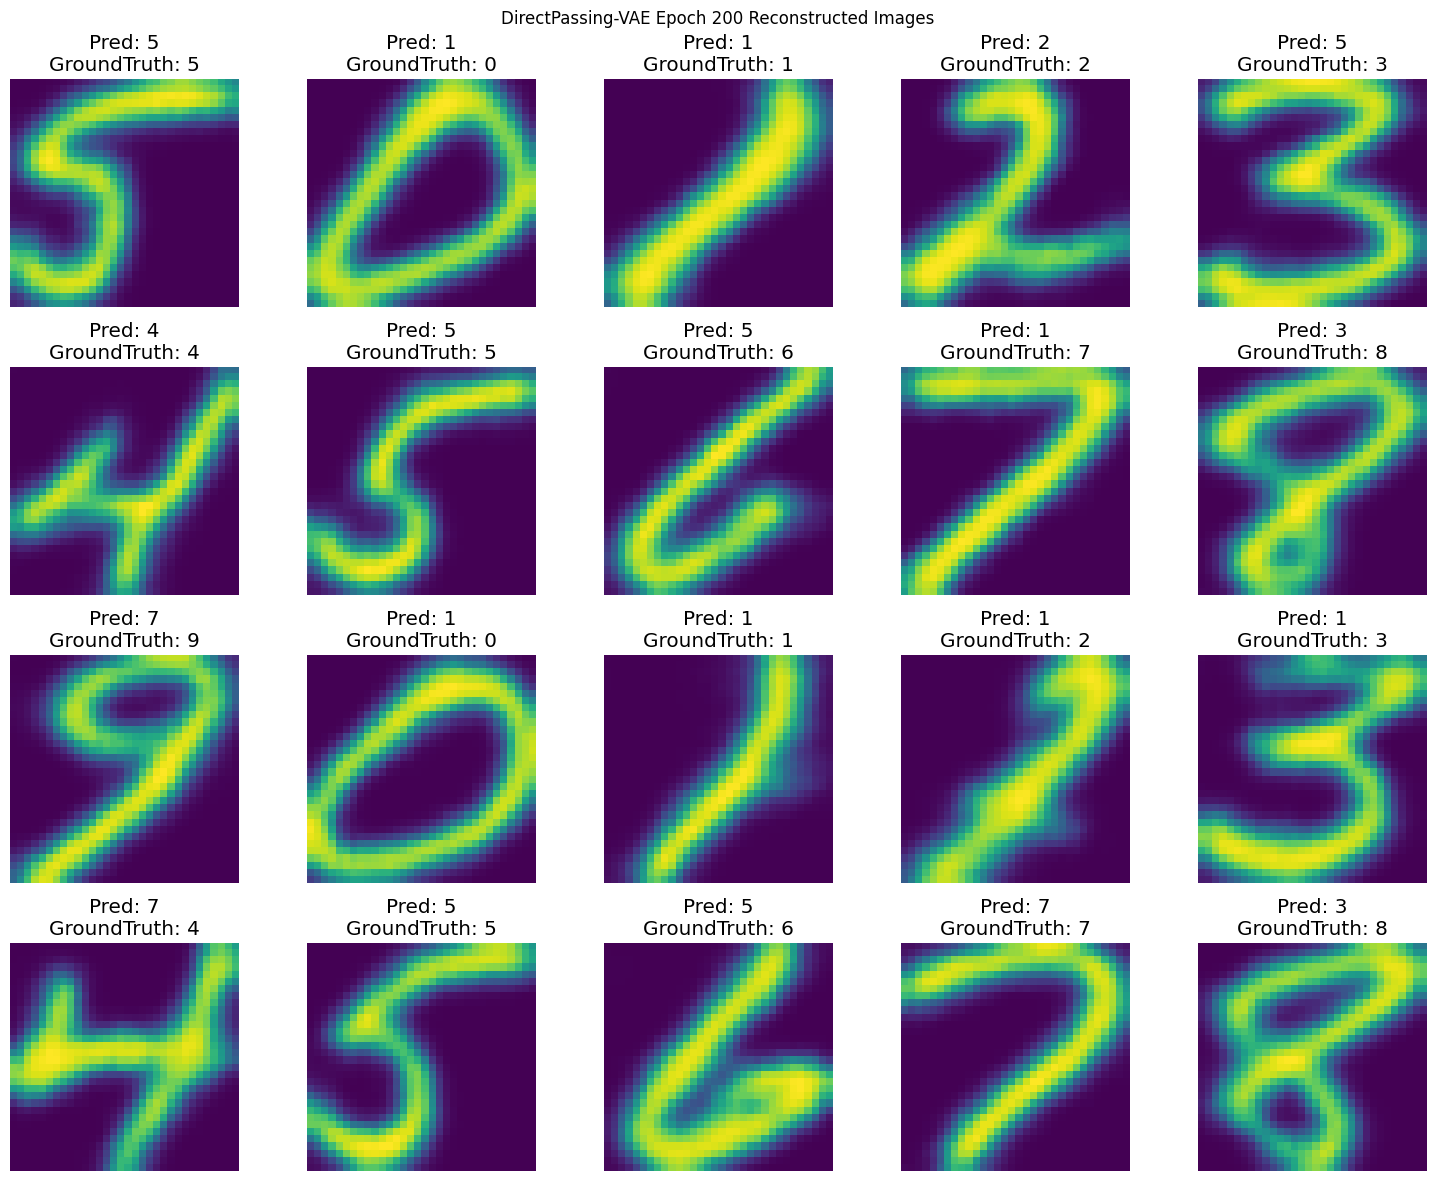

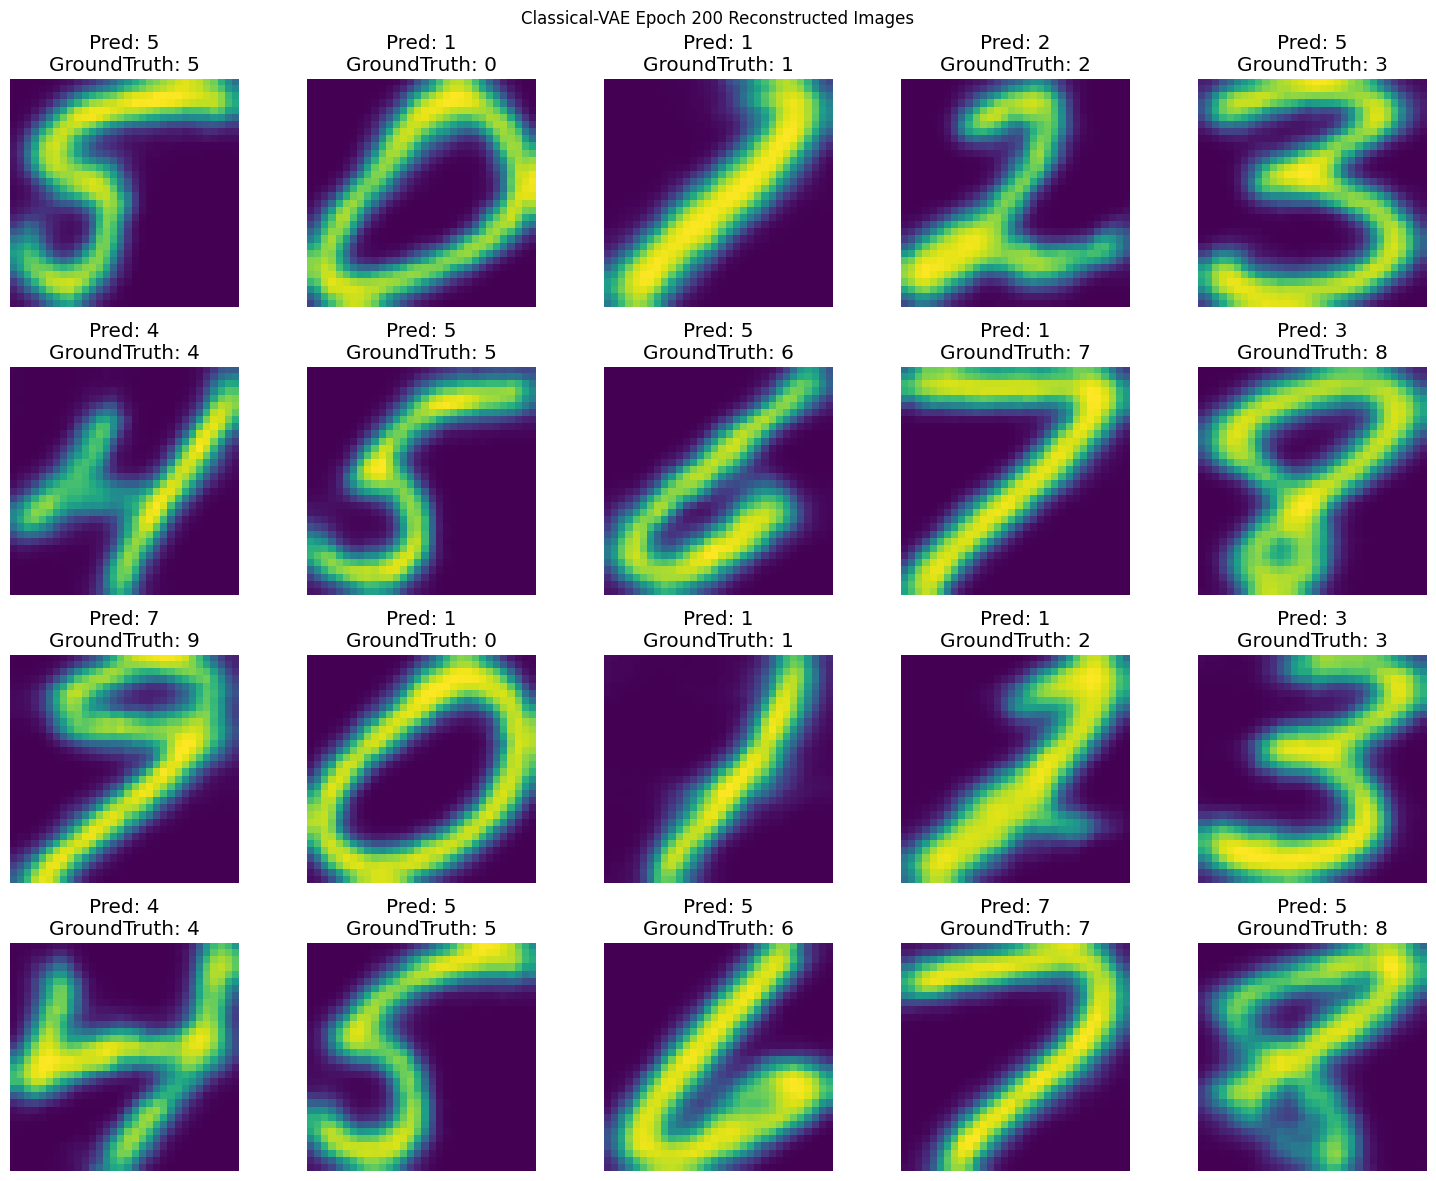

Training Complete


In [18]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")

    # Training step
    (q_train_loss_epoch, q_train_mse_epoch,c_train_loss_epoch,c_train_mse_epoch) = train(
        q_VAE=q_VAE,
        c_VAE=c_VAE,
        dataloader=trainloader,
        device=device,
        q_optimizer=q_optimizer,
        c_optimizer=c_optimizer,
        criterion=criterion,
        batch_size=batch_size
    )
    
    # Validation step
    (q_valid_loss_epoch,
     q_val_mse_epoch,  # MSE for Q-VAE
     q_reconstructed_images,
     q_images_with_random_noise,
     q_fid_latent_space_epoch,
     q_fid_random_noise_epoch,
     q_accuracy_epoch,
     c_valid_loss_epoch,
     c_val_mse_epoch,  # MSE for C-VAE
     c_reconstructed_images,
     c_images_with_random_noise,
     c_fid_latent_space_epoch,
     c_fid_random_noise_epoch,
     c_accuracy_epoch,
     labels,
     c_predicted_labels,
     q_predicted_labels) = validate(
        q_VAE=q_VAE,
        c_VAE=c_VAE,
        dataloader=testloader,
        device=device,
        criterion=criterion,
        batch_size=batch_size,
        Classifier=Classifier
    )
    
    # Store metrics
    q_train_loss.append(q_train_loss_epoch)
    c_train_loss.append(c_train_loss_epoch)
    q_valid_loss.append(q_valid_loss_epoch)
    c_valid_loss.append(c_valid_loss_epoch)
    q_fid_latent_space.append(q_fid_latent_space_epoch)
    c_fid_latent_space.append(c_fid_latent_space_epoch)
    q_fid_random_noise.append(q_fid_random_noise_epoch)
    c_fid_random_noise.append(c_fid_random_noise_epoch)
    q_accuracy.append(q_accuracy_epoch)
    c_accuracy.append(c_accuracy_epoch)
    
    # Save images
    save_reconstructed_images(images=q_reconstructed_images, 
                              epoch=epoch+1, 
                              random_noise=False,
                              q_processing=True)
    save_reconstructed_images(images=q_images_with_random_noise, 
                              epoch=epoch+1, 
                              random_noise=True,
                              q_processing=True)
    save_reconstructed_images(images=c_reconstructed_images, 
                              epoch=epoch+1, 
                              random_noise=False,
                              q_processing=False)
    save_reconstructed_images(images=c_images_with_random_noise, 
                              epoch=epoch+1, 
                              random_noise=True,
                              q_processing=False)
    
    # Create and store image grids
    q_image_grid = make_grid(q_reconstructed_images.detach().cpu())
    q_grid_images.append(q_image_grid)
    
    c_image_grid = make_grid(c_reconstructed_images.detach().cpu())
    c_grid_images.append(c_image_grid)
    
    # Print metrics
    print(f"Training Loss using D VAE: {q_train_loss_epoch:.4f}")
    print(f"Training Loss using C VAE: {c_train_loss_epoch:.4f}")
    print(f"Validation Loss using D VAE: {q_valid_loss_epoch:.4f}")
    print(f"Validation Loss using C VAE: {c_valid_loss_epoch:.4f}")
    print(f"Validation MSE using D VAE: {q_val_mse_epoch:.4f}")
    print(f"Validation MSE using C VAE: {c_val_mse_epoch:.4f}")
    print(f"FID Score with Latent Space using D VAE: {q_fid_latent_space_epoch:.4f}")
    print(f"FID Score with Latent Space using C VAE: {c_fid_latent_space_epoch:.4f}")  
    print(f"FID Score with Random Noise using D VAE: {q_fid_random_noise_epoch:.4f}")
    print(f"FID Score with Random Noise using C VAE: {c_fid_random_noise_epoch:.4f}")  
    print(f"Classification Accuracy for D VAE: {q_accuracy_epoch:.2f}%")
    print(f"Classification Accuracy for C VAE: {c_accuracy_epoch:.2f}%")

# Optional: Plot images after training is complete
plot_images(q_reconstructed_images, q_predicted_labels, labels, f'DirectPassing-VAE Epoch {epoch+1} Reconstructed Images')
plot_images(c_reconstructed_images, c_predicted_labels, labels, f'Classical-VAE Epoch {epoch+1} Reconstructed Images')

print("Training Complete")

In [35]:
def save_mse_plot(q_train_mse, q_valid_mse, c_train_mse, c_valid_mse):
    plt.figure(figsize = (10, 7))
    plt.plot(q_train_mse,color = 'orange', label='CDP-VAE Training MSE')
    plt.plot(q_valid_mse,color = 'yellow', label='CDP-VAE Validation MSE')
    plt.plot(c_train_mse,color = 'red', label='C-VAE Training MSE')
    plt.plot(c_valid_mse,color = 'blue', label='C-VAE Validation MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.title('Training and Validation MSE')
    plt.savefig('mse_plot.png')
    plt.close()

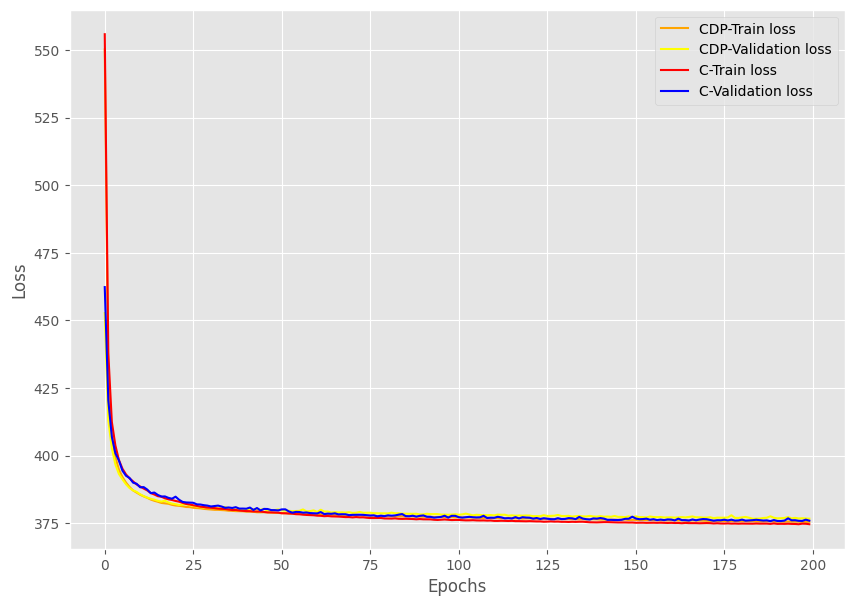

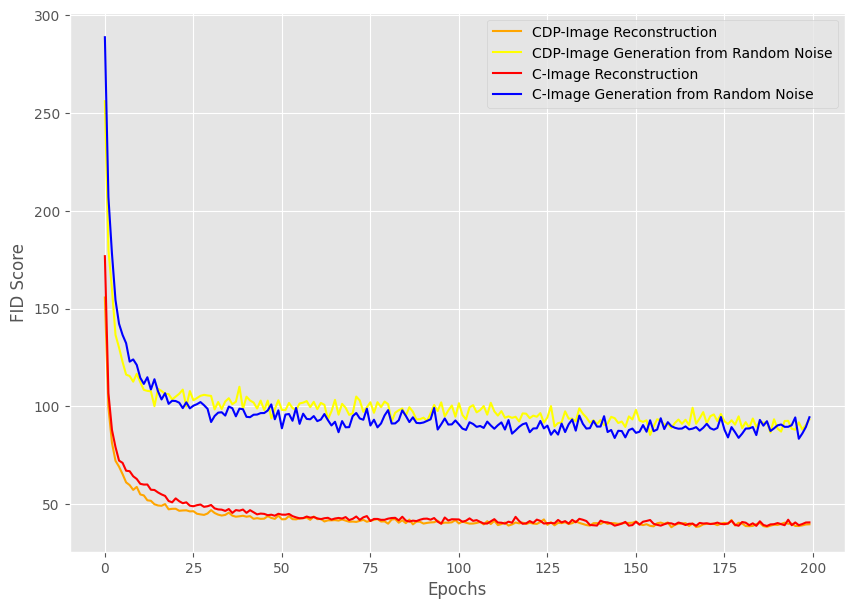

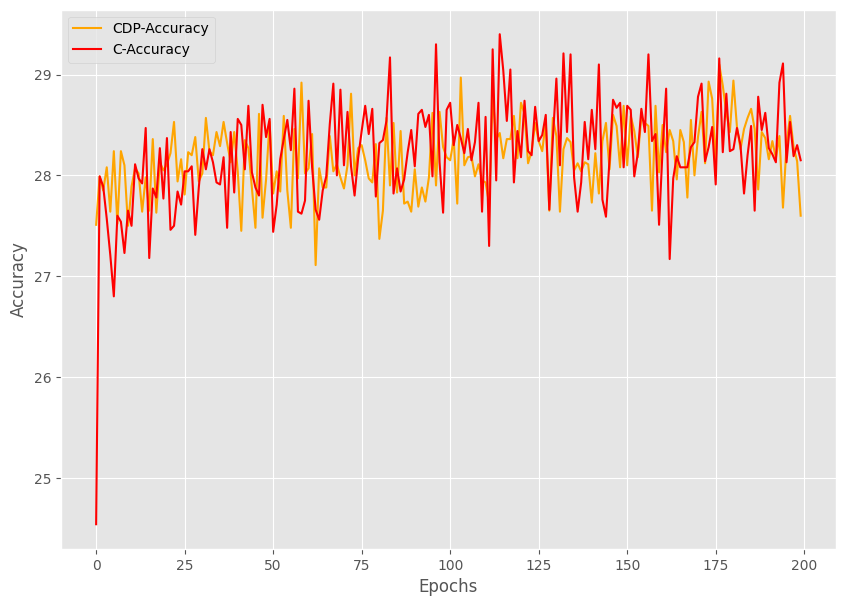

In [38]:
image_to_vid(q_grid_images, q_processing=True)
image_to_vid(c_grid_images, q_processing=False)
save_loss_plot(q_train_loss = q_train_loss,
               q_valid_loss = q_valid_loss,
               c_train_loss = c_train_loss,
               c_valid_loss = c_valid_loss)
save_fid_plot(q_fid_score_latent_space = q_fid_latent_space,
              q_fid_score_random_noise = q_fid_random_noise,
              c_fid_score_latent_space = c_fid_latent_space,
              c_fid_score_random_noise = c_fid_random_noise)
save_accuracy_plot(q_accuracy = q_accuracy,
                   c_accuracy = c_accuracy)
save_mse_plot(q_train_mse=q_train_mse_epoch,
              q_valid_mse=q_val_mse_epoch,
              c_train_mse=c_train_mse_epoch,
              c_valid_mse=c_val_mse_epoch)

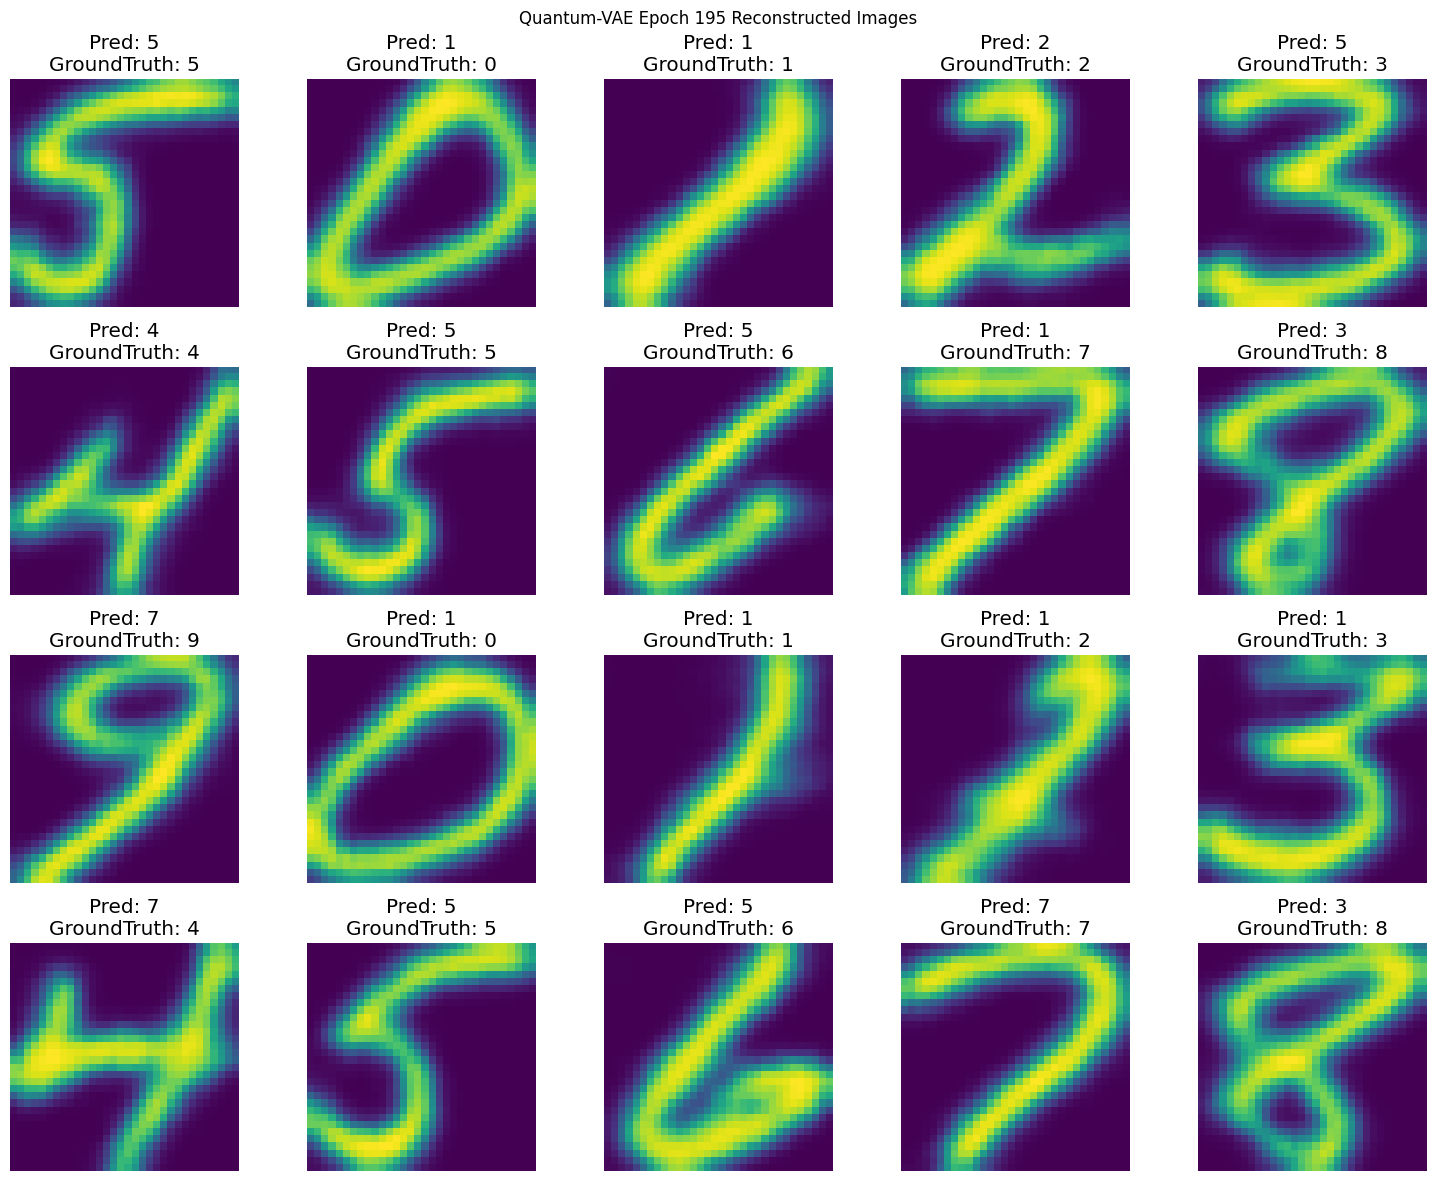

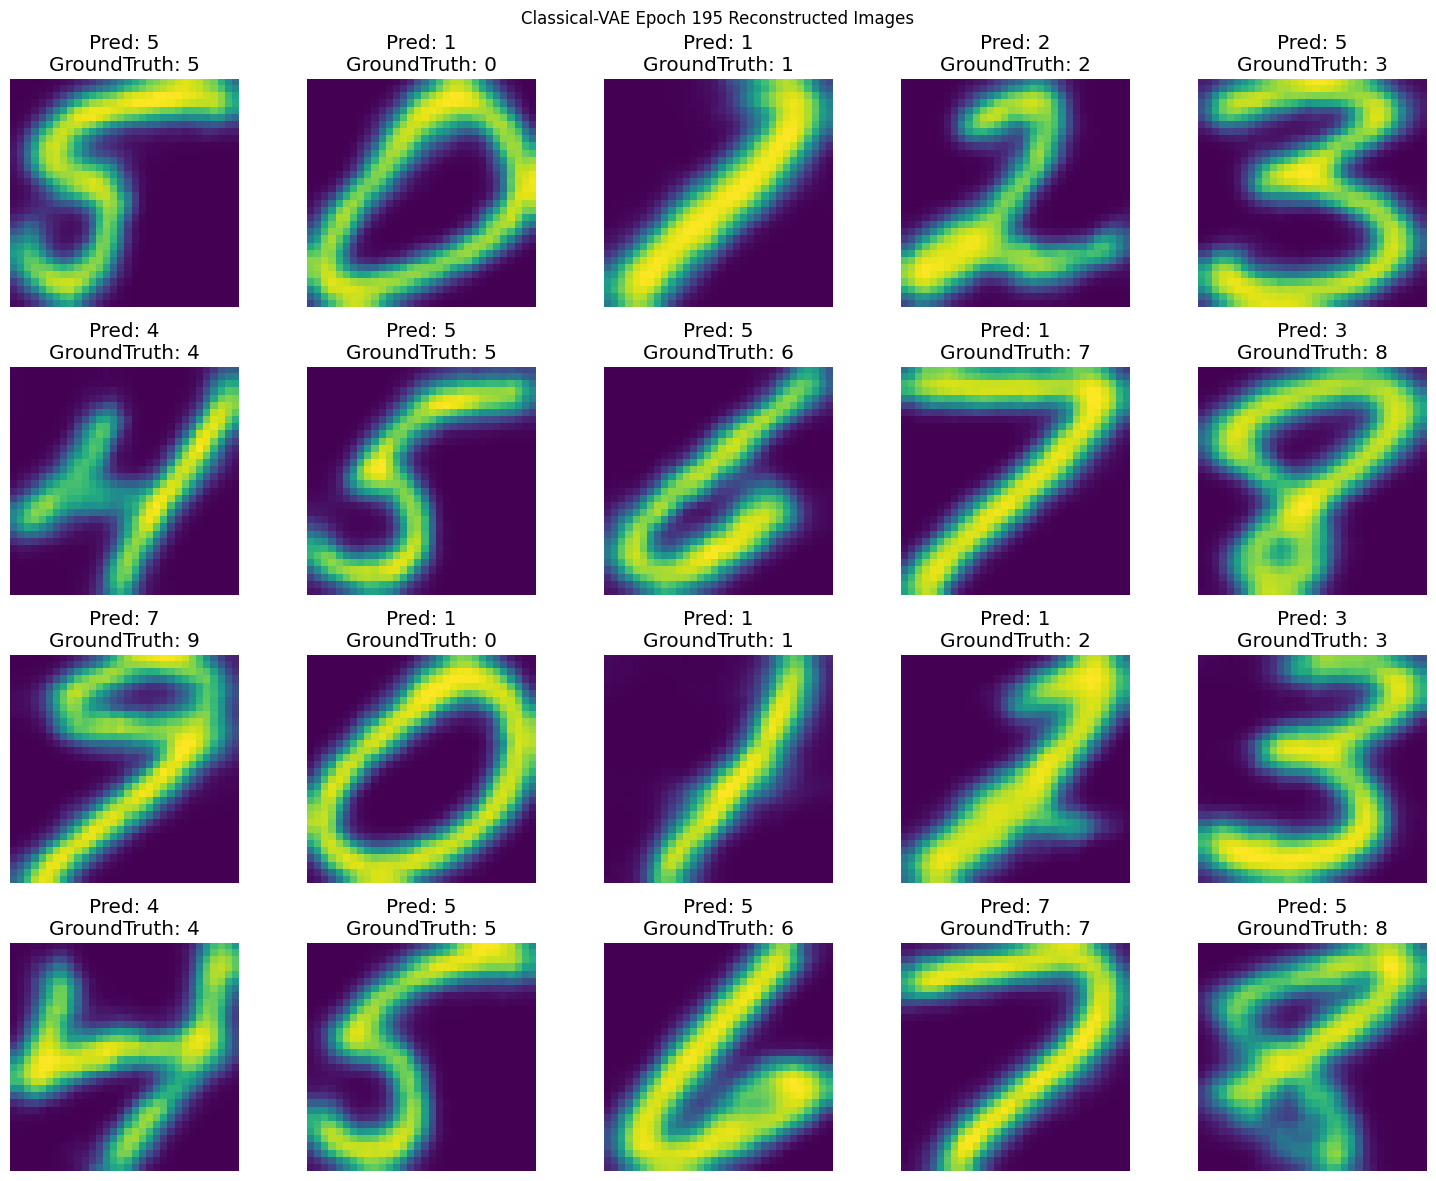

In [21]:
plot_images(q_reconstructed_images, q_predicted_labels, labels, f'Quantum-VAE Epoch {epoch-4} Reconstructed Images')
plot_images(c_reconstructed_images,c_predicted_labels, labels, f'Classical-VAE Epoch {epoch-4} Reconstructed Images')

In [22]:
import torch
import matplotlib.pyplot as plt

# Define a mapping from numeric labels to string labels for CIFAR-10
LABEL_MAPPING = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9"
}


def plot_images(images, predicted_labels, real_labels, title, num_images=20):
    # Ensure we're plotting at most num_images
    num_images = min(num_images, images.size(0))

    plt.figure(figsize=(15, 12))
    for idx in range(num_images):
        plt.subplot(4, 5, idx + 1)  # Adjust rows and columns for layout
        
        # Convert image to grayscale
        if images[idx].shape[0] == 3:  # Check if image is in RGB format
            grayscale_image = torch.mean(images[idx], dim=0, keepdim=True)
        else:  # Image is already in grayscale format
            grayscale_image = images[idx]
        
        plt.imshow(grayscale_image.cpu().squeeze().numpy(), cmap='gray')  # Display grayscale image
        
        pred_label_str = LABEL_MAPPING[predicted_labels[idx].item()]
        real_label_str = LABEL_MAPPING[real_labels[idx].item()]
    
        plt.title(f'Pred: {pred_label_str}\nGroundTruth:{real_label_str}')  # Display predicted and real labels as the title
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

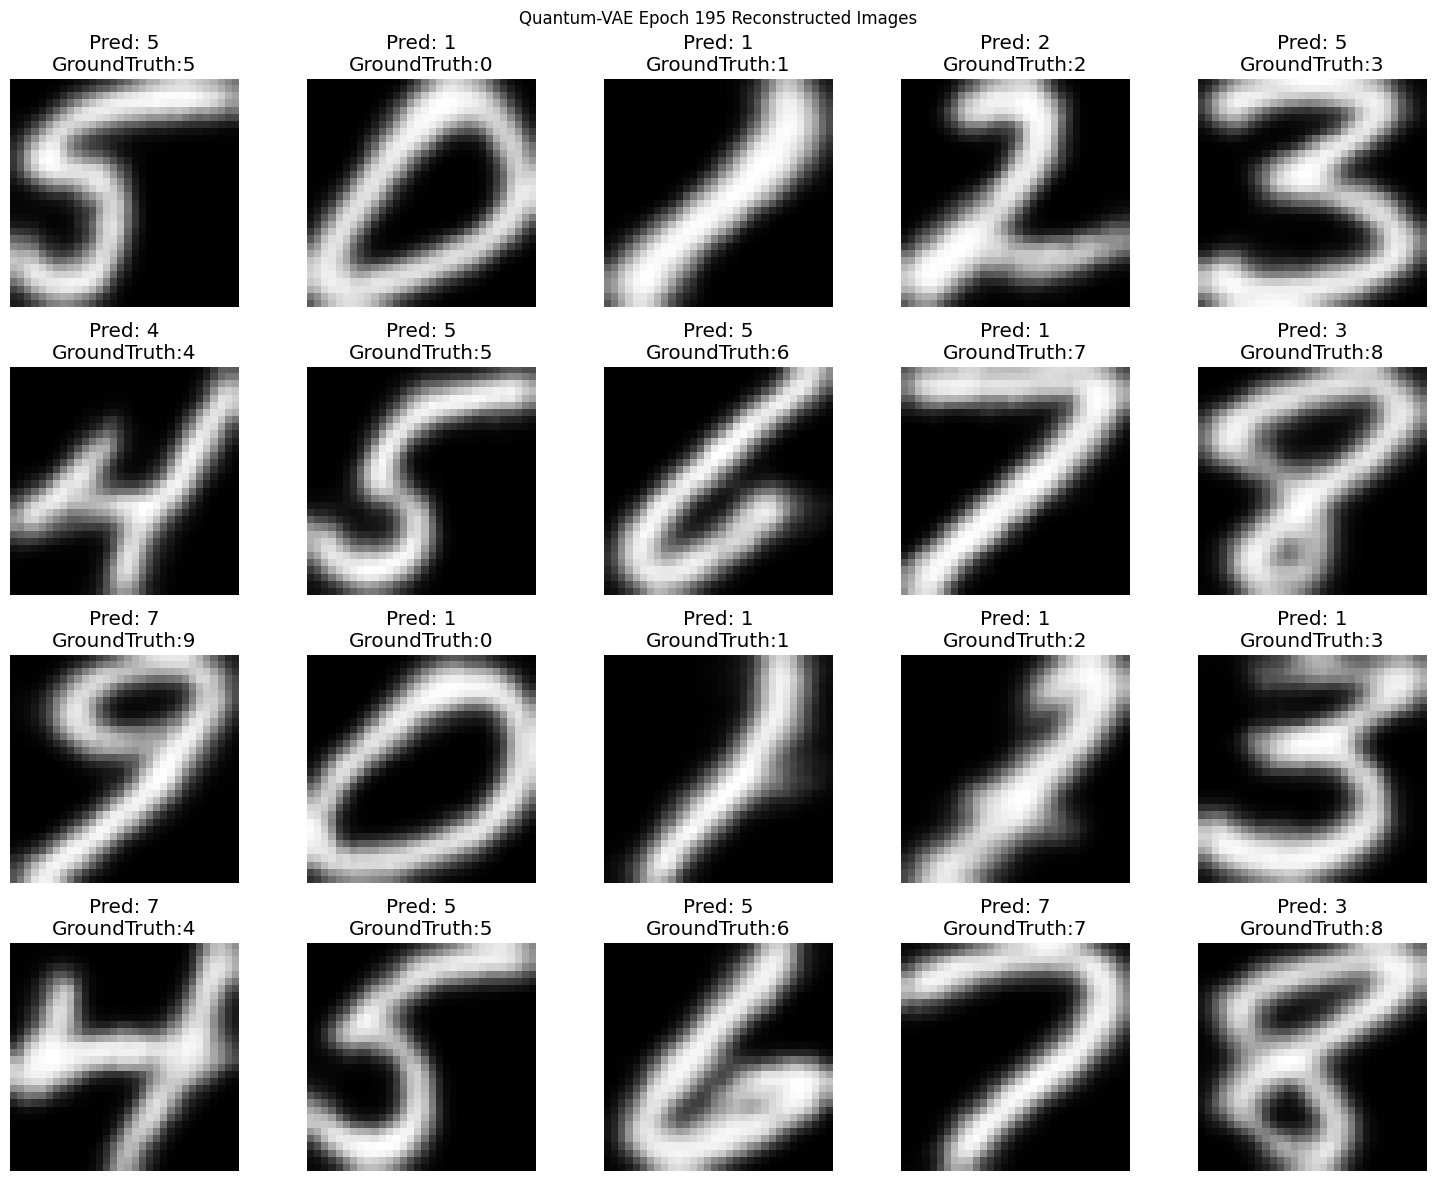

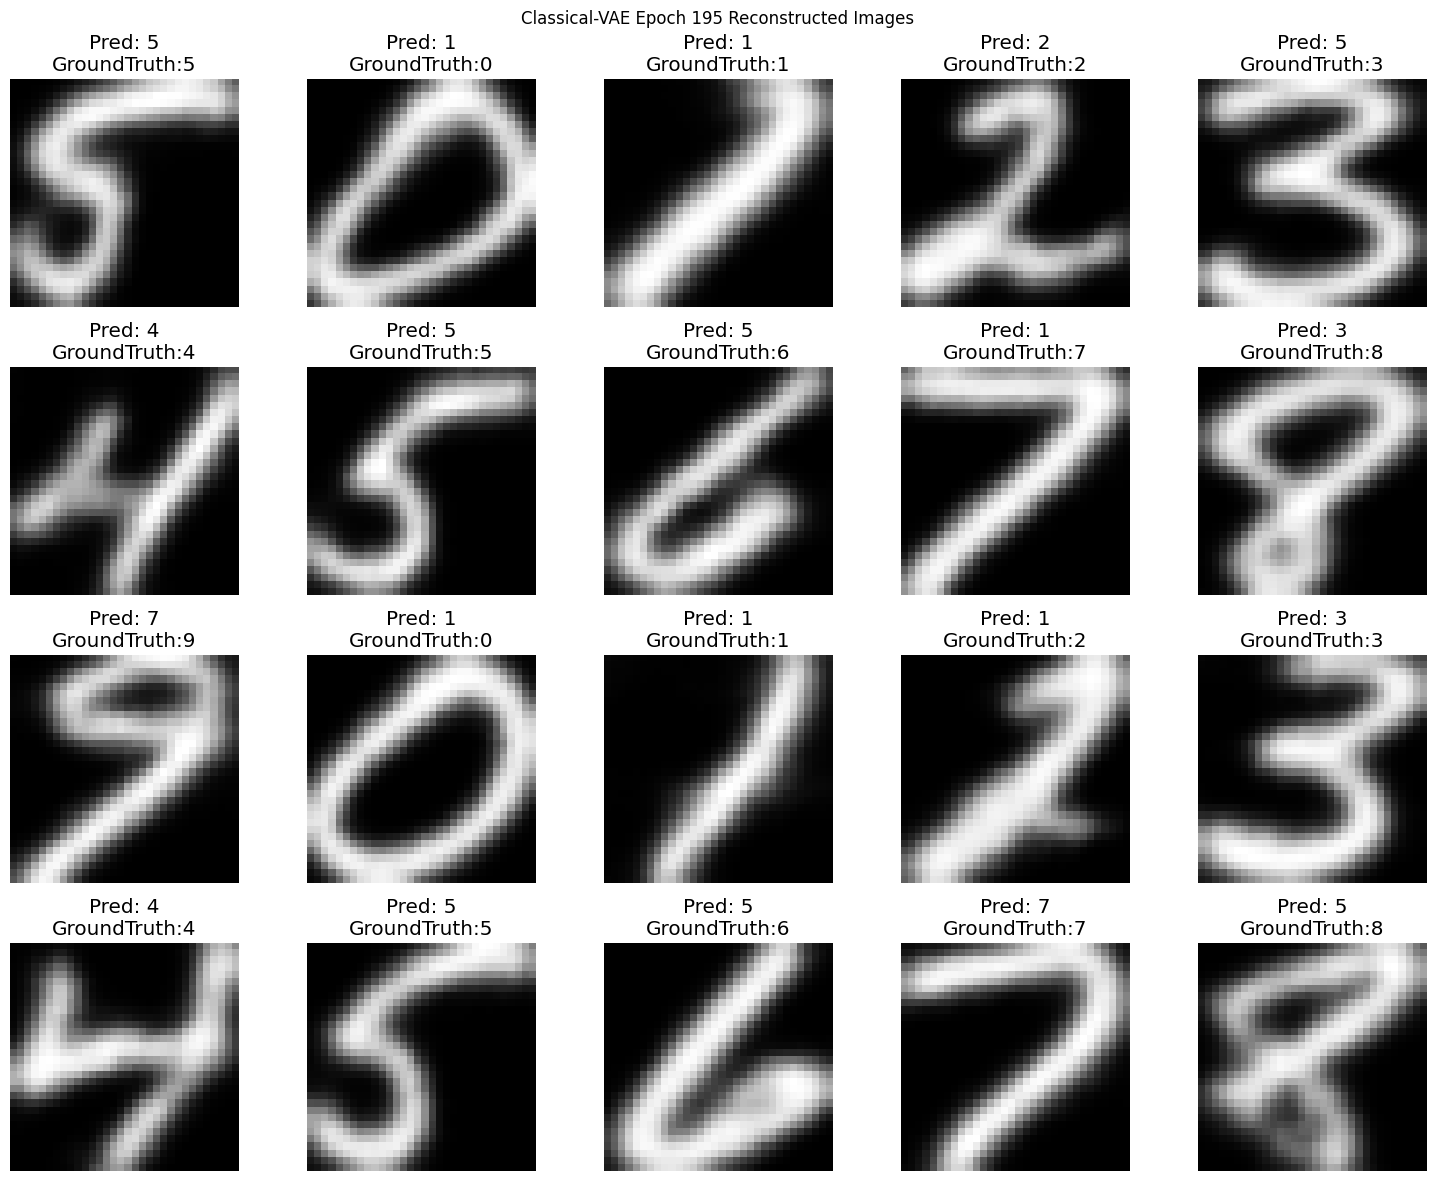

In [23]:
plot_images(q_reconstructed_images, q_predicted_labels, labels, f'Quantum-VAE Epoch {epoch-4} Reconstructed Images')
plot_images(c_reconstructed_images,c_predicted_labels, labels, f'Classical-VAE Epoch {epoch-4} Reconstructed Images')

Shape of Image for class 5: torch.Size([1, 28, 28])
Displaying the first image with label 5:


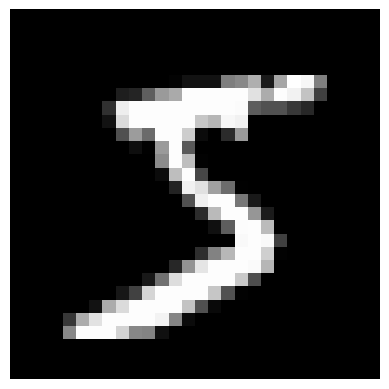

Shape of Image for class 0: torch.Size([1, 28, 28])
Displaying the first image with label 0:


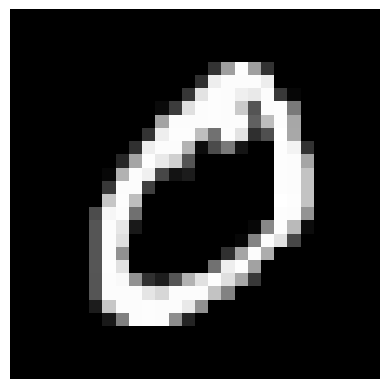

Shape of Image for class 4: torch.Size([1, 28, 28])
Displaying the first image with label 4:


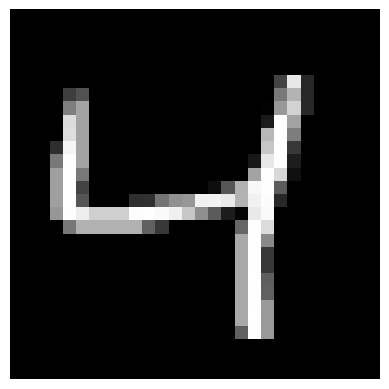

Shape of Image for class 1: torch.Size([1, 28, 28])
Displaying the first image with label 1:


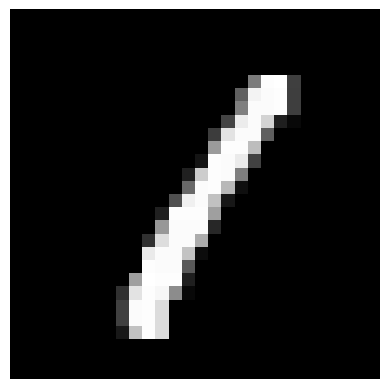

Shape of Image for class 9: torch.Size([1, 28, 28])
Displaying the first image with label 9:


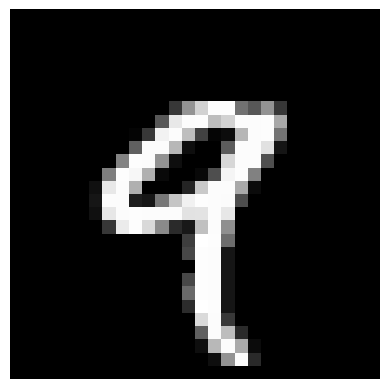

Shape of Image for class 2: torch.Size([1, 28, 28])
Displaying the first image with label 2:


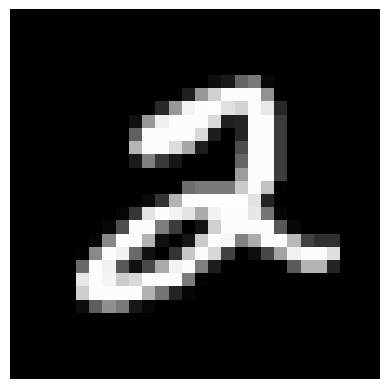

Shape of Image for class 3: torch.Size([1, 28, 28])
Displaying the first image with label 3:


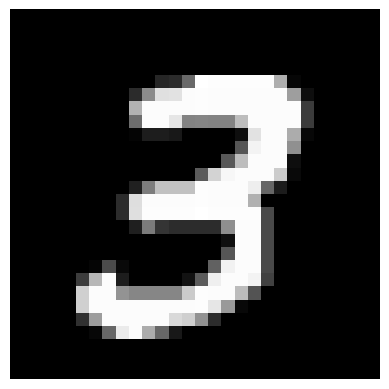

Shape of Image for class 6: torch.Size([1, 28, 28])
Displaying the first image with label 6:


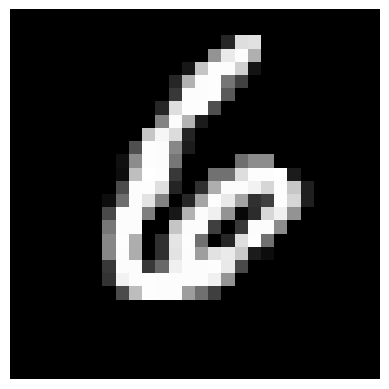

Shape of Image for class 7: torch.Size([1, 28, 28])
Displaying the first image with label 7:


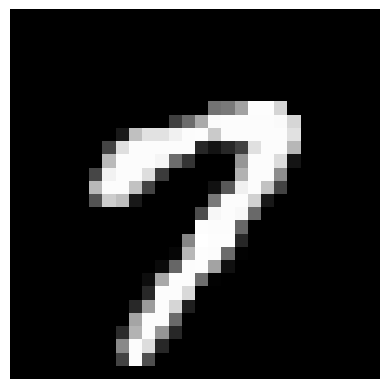

Shape of Image for class 8: torch.Size([1, 28, 28])
Displaying the first image with label 8:


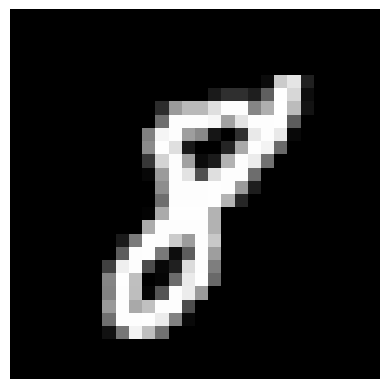

In [24]:
import matplotlib.pyplot as plt
import torchvision
import torch
import torchvision.transforms as transforms
import numpy as np

# Define a simple transform to convert PIL Image to Tensor
rtransform = transforms.ToTensor()

# Load the USPS dataset with ToTensor transform
rtrainset = torchvision.datasets.MNIST(root='Input', train=True, download=True, transform=rtransform)

# Function to display an image
def imshow(img):
    npimg = img.numpy()  # Convert tensor to NumPy array
    plt.imshow(npimg[0], cmap='gray')  # Display grayscale image
    plt.axis('off')  # Hide axes
    plt.show()

# Create a DataLoader with shuffle=False to maintain order
rtrainloader = torch.utils.data.DataLoader(rtrainset, batch_size=5, shuffle=False)

# Set to track classes that have already been displayed
displayed_classes = set()

# Loop through the DataLoader
for rimages, rlabels in rtrainloader:
    for i in range(len(rlabels)):
        llabel = rlabels[i].item()  # Get class label as an integer
        if llabel not in displayed_classes:
            print(f"Shape of Image for class {llabel}: {rimages[i].shape}")
            print(f"Displaying the first image with label {llabel}:")
            imshow(rimages[i])  # Display the image
            displayed_classes.add(llabel)  # Mark class as displayed
        # Stop if all classes have been displayed
        if len(displayed_classes) == 10:  # Assuming there are 10 classes in USPS
            break
    if len(displayed_classes) == 10:
        break

Shape of Image for class 5: torch.Size([1, 16, 16])
Displaying the first image with label 5:


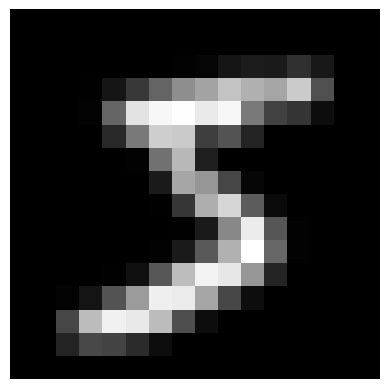

Shape of Image for class 0: torch.Size([1, 16, 16])
Displaying the first image with label 0:


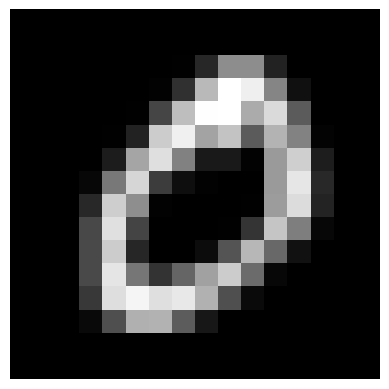

Shape of Image for class 4: torch.Size([1, 16, 16])
Displaying the first image with label 4:


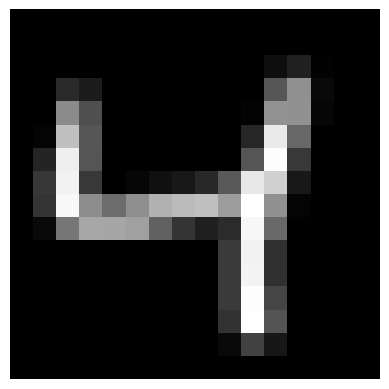

Shape of Image for class 1: torch.Size([1, 16, 16])
Displaying the first image with label 1:


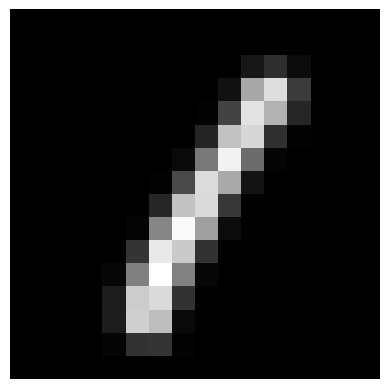

Shape of Image for class 9: torch.Size([1, 16, 16])
Displaying the first image with label 9:


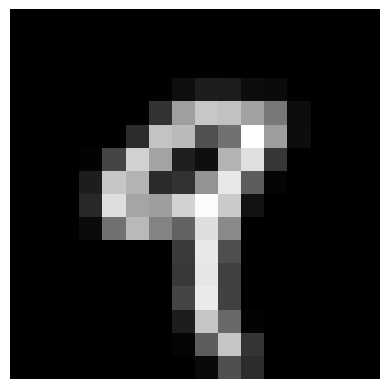

Shape of Image for class 2: torch.Size([1, 16, 16])
Displaying the first image with label 2:


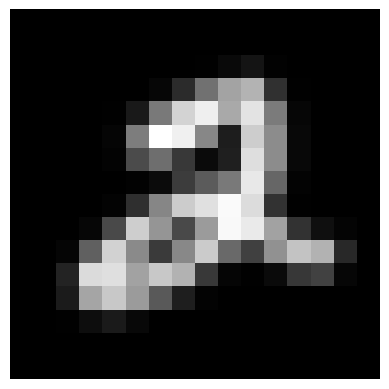

Shape of Image for class 3: torch.Size([1, 16, 16])
Displaying the first image with label 3:


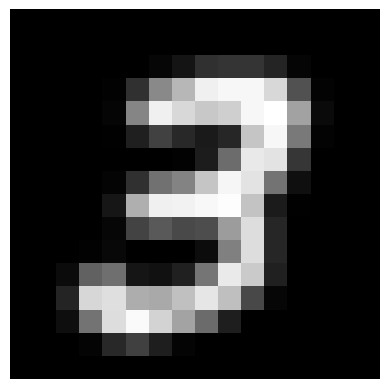

Shape of Image for class 6: torch.Size([1, 16, 16])
Displaying the first image with label 6:


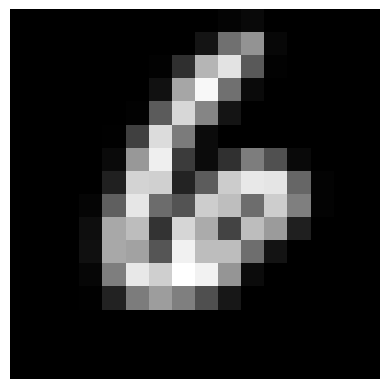

Shape of Image for class 7: torch.Size([1, 16, 16])
Displaying the first image with label 7:


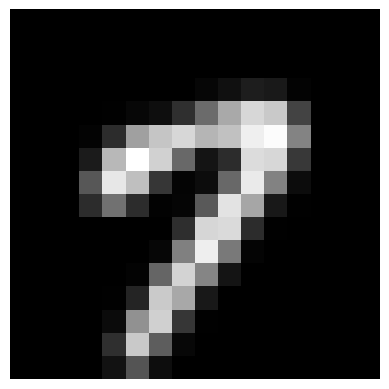

Shape of Image for class 8: torch.Size([1, 16, 16])
Displaying the first image with label 8:


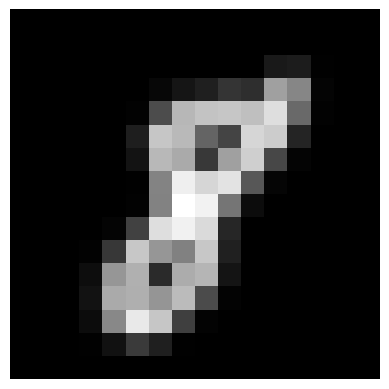

In [25]:
import matplotlib.pyplot as plt
import torchvision
import torch
import torchvision.transforms as transforms
import numpy as np

# Define a simple transform to convert PIL Image to Tensor
rtransform = transforms.Compose([transforms.Resize((16, 16)),
                                transforms.ToTensor()])

# Load the USPS dataset with ToTensor transform
rtrainset = torchvision.datasets.MNIST(root='Input', train=True, download=True, transform=rtransform)

# Function to display an image
def imshow(img):
    npimg = img.numpy()  # Convert tensor to NumPy array
    plt.imshow(npimg[0], cmap='gray')  # Display grayscale image
    plt.axis('off')  # Hide axes
    plt.show()

# Create a DataLoader with shuffle=False to maintain order
rtrainloader = torch.utils.data.DataLoader(rtrainset, batch_size=5, shuffle=False)

# Set to track classes that have already been displayed
displayed_classes = set()

# Loop through the DataLoader
for rimages, rlabels in rtrainloader:
    for i in range(len(rlabels)):
        rlabel = rlabels[i].item()  # Get class label as an integer
        if rlabel not in displayed_classes:
            print(f"Shape of Image for class {rlabel}: {rimages[i].shape}")
            print(f"Displaying the first image with label {rlabel}:")
            imshow(rimages[i])  # Display the image
            displayed_classes.add(rlabel)  # Mark class as displayed
        # Stop if all classes have been displayed
        if len(displayed_classes) == 10:  # Assuming there are 10 classes in USPS
            break
    if len(displayed_classes) == 10:
        break

Shape of Input Real Image after 32x32 for class 9: torch.Size([1, 32, 32])
Displaying the first image with label tensor([9, 5, 8, 3, 6, 4, 7, 7, 2, 3, 8, 0, 6, 2, 0, 5, 9, 3, 0, 3, 4, 9, 7, 7,
        1, 9, 7, 1, 5, 2, 7, 6, 8, 3, 6, 8, 4, 4, 1, 1, 3, 0, 7, 6, 6, 2, 7, 3,
        9, 1, 9, 8, 6, 0, 8, 3, 1, 4, 6, 0, 7, 6, 9, 3, 8, 4, 1, 3, 2, 8, 4, 4,
        1, 2, 8, 0, 6, 2, 7, 0, 4, 3, 5, 1, 3, 4, 7, 5, 1, 8, 4, 4, 3, 8, 2, 1,
        7, 1, 7, 8, 8, 9, 7, 0, 0, 0, 6, 0, 1, 1, 5, 8, 4, 8, 9, 3, 2, 9, 5, 2,
        8, 4, 8, 3, 6, 8, 6, 4, 3, 2, 8, 8, 4, 4, 2, 9, 8, 6, 1, 5, 9, 6, 7, 0,
        2, 3, 0, 3, 3, 3, 2, 1, 8, 4, 8, 0, 2, 4, 2, 7, 1, 2, 8, 3, 7, 2, 1, 3,
        8, 0, 1, 8, 2, 5, 1, 8, 4, 2, 9, 8, 6, 3, 4, 3, 5, 4, 1, 6, 2, 5, 5, 3,
        8, 2, 6, 5, 7, 9, 1, 9, 3, 3, 5, 8, 3, 6, 4, 3, 0, 8, 9, 7, 0, 7, 2, 4,
        7, 8, 7, 7, 1, 2, 0, 2, 1, 7, 2, 0, 1, 1, 1, 0, 3, 0, 0, 4, 8, 1, 3, 2,
        3, 4, 1, 0, 6, 4, 3, 1, 3, 2, 7, 2, 4, 0, 6, 2, 6, 4, 0, 6, 7, 8, 8, 6,
       

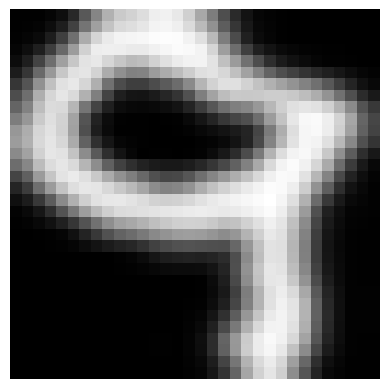

Shape of Input Real Image after 32x32 for class 5: torch.Size([1, 32, 32])
Displaying the first image with label tensor([9, 5, 8, 3, 6, 4, 7, 7, 2, 3, 8, 0, 6, 2, 0, 5, 9, 3, 0, 3, 4, 9, 7, 7,
        1, 9, 7, 1, 5, 2, 7, 6, 8, 3, 6, 8, 4, 4, 1, 1, 3, 0, 7, 6, 6, 2, 7, 3,
        9, 1, 9, 8, 6, 0, 8, 3, 1, 4, 6, 0, 7, 6, 9, 3, 8, 4, 1, 3, 2, 8, 4, 4,
        1, 2, 8, 0, 6, 2, 7, 0, 4, 3, 5, 1, 3, 4, 7, 5, 1, 8, 4, 4, 3, 8, 2, 1,
        7, 1, 7, 8, 8, 9, 7, 0, 0, 0, 6, 0, 1, 1, 5, 8, 4, 8, 9, 3, 2, 9, 5, 2,
        8, 4, 8, 3, 6, 8, 6, 4, 3, 2, 8, 8, 4, 4, 2, 9, 8, 6, 1, 5, 9, 6, 7, 0,
        2, 3, 0, 3, 3, 3, 2, 1, 8, 4, 8, 0, 2, 4, 2, 7, 1, 2, 8, 3, 7, 2, 1, 3,
        8, 0, 1, 8, 2, 5, 1, 8, 4, 2, 9, 8, 6, 3, 4, 3, 5, 4, 1, 6, 2, 5, 5, 3,
        8, 2, 6, 5, 7, 9, 1, 9, 3, 3, 5, 8, 3, 6, 4, 3, 0, 8, 9, 7, 0, 7, 2, 4,
        7, 8, 7, 7, 1, 2, 0, 2, 1, 7, 2, 0, 1, 1, 1, 0, 3, 0, 0, 4, 8, 1, 3, 2,
        3, 4, 1, 0, 6, 4, 3, 1, 3, 2, 7, 2, 4, 0, 6, 2, 6, 4, 0, 6, 7, 8, 8, 6,
       

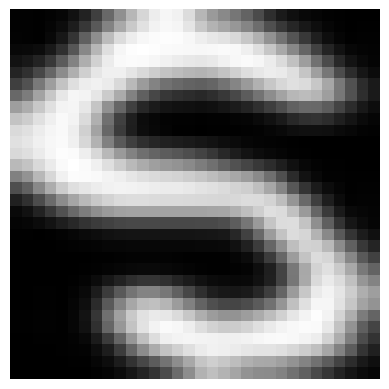

Shape of Input Real Image after 32x32 for class 8: torch.Size([1, 32, 32])
Displaying the first image with label tensor([9, 5, 8, 3, 6, 4, 7, 7, 2, 3, 8, 0, 6, 2, 0, 5, 9, 3, 0, 3, 4, 9, 7, 7,
        1, 9, 7, 1, 5, 2, 7, 6, 8, 3, 6, 8, 4, 4, 1, 1, 3, 0, 7, 6, 6, 2, 7, 3,
        9, 1, 9, 8, 6, 0, 8, 3, 1, 4, 6, 0, 7, 6, 9, 3, 8, 4, 1, 3, 2, 8, 4, 4,
        1, 2, 8, 0, 6, 2, 7, 0, 4, 3, 5, 1, 3, 4, 7, 5, 1, 8, 4, 4, 3, 8, 2, 1,
        7, 1, 7, 8, 8, 9, 7, 0, 0, 0, 6, 0, 1, 1, 5, 8, 4, 8, 9, 3, 2, 9, 5, 2,
        8, 4, 8, 3, 6, 8, 6, 4, 3, 2, 8, 8, 4, 4, 2, 9, 8, 6, 1, 5, 9, 6, 7, 0,
        2, 3, 0, 3, 3, 3, 2, 1, 8, 4, 8, 0, 2, 4, 2, 7, 1, 2, 8, 3, 7, 2, 1, 3,
        8, 0, 1, 8, 2, 5, 1, 8, 4, 2, 9, 8, 6, 3, 4, 3, 5, 4, 1, 6, 2, 5, 5, 3,
        8, 2, 6, 5, 7, 9, 1, 9, 3, 3, 5, 8, 3, 6, 4, 3, 0, 8, 9, 7, 0, 7, 2, 4,
        7, 8, 7, 7, 1, 2, 0, 2, 1, 7, 2, 0, 1, 1, 1, 0, 3, 0, 0, 4, 8, 1, 3, 2,
        3, 4, 1, 0, 6, 4, 3, 1, 3, 2, 7, 2, 4, 0, 6, 2, 6, 4, 0, 6, 7, 8, 8, 6,
       

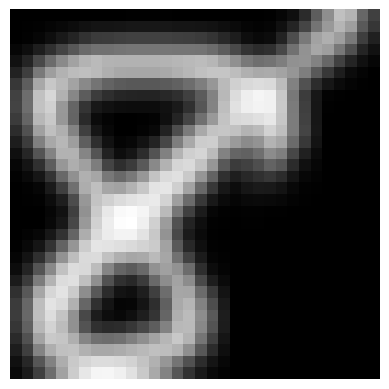

Shape of Input Real Image after 32x32 for class 3: torch.Size([1, 32, 32])
Displaying the first image with label tensor([9, 5, 8, 3, 6, 4, 7, 7, 2, 3, 8, 0, 6, 2, 0, 5, 9, 3, 0, 3, 4, 9, 7, 7,
        1, 9, 7, 1, 5, 2, 7, 6, 8, 3, 6, 8, 4, 4, 1, 1, 3, 0, 7, 6, 6, 2, 7, 3,
        9, 1, 9, 8, 6, 0, 8, 3, 1, 4, 6, 0, 7, 6, 9, 3, 8, 4, 1, 3, 2, 8, 4, 4,
        1, 2, 8, 0, 6, 2, 7, 0, 4, 3, 5, 1, 3, 4, 7, 5, 1, 8, 4, 4, 3, 8, 2, 1,
        7, 1, 7, 8, 8, 9, 7, 0, 0, 0, 6, 0, 1, 1, 5, 8, 4, 8, 9, 3, 2, 9, 5, 2,
        8, 4, 8, 3, 6, 8, 6, 4, 3, 2, 8, 8, 4, 4, 2, 9, 8, 6, 1, 5, 9, 6, 7, 0,
        2, 3, 0, 3, 3, 3, 2, 1, 8, 4, 8, 0, 2, 4, 2, 7, 1, 2, 8, 3, 7, 2, 1, 3,
        8, 0, 1, 8, 2, 5, 1, 8, 4, 2, 9, 8, 6, 3, 4, 3, 5, 4, 1, 6, 2, 5, 5, 3,
        8, 2, 6, 5, 7, 9, 1, 9, 3, 3, 5, 8, 3, 6, 4, 3, 0, 8, 9, 7, 0, 7, 2, 4,
        7, 8, 7, 7, 1, 2, 0, 2, 1, 7, 2, 0, 1, 1, 1, 0, 3, 0, 0, 4, 8, 1, 3, 2,
        3, 4, 1, 0, 6, 4, 3, 1, 3, 2, 7, 2, 4, 0, 6, 2, 6, 4, 0, 6, 7, 8, 8, 6,
       

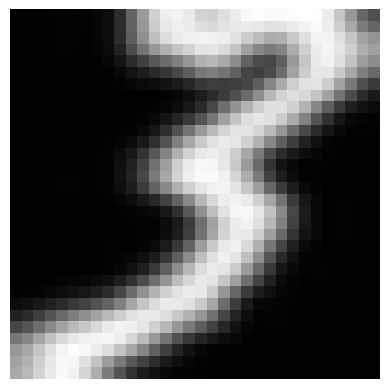

Shape of Input Real Image after 32x32 for class 6: torch.Size([1, 32, 32])
Displaying the first image with label tensor([9, 5, 8, 3, 6, 4, 7, 7, 2, 3, 8, 0, 6, 2, 0, 5, 9, 3, 0, 3, 4, 9, 7, 7,
        1, 9, 7, 1, 5, 2, 7, 6, 8, 3, 6, 8, 4, 4, 1, 1, 3, 0, 7, 6, 6, 2, 7, 3,
        9, 1, 9, 8, 6, 0, 8, 3, 1, 4, 6, 0, 7, 6, 9, 3, 8, 4, 1, 3, 2, 8, 4, 4,
        1, 2, 8, 0, 6, 2, 7, 0, 4, 3, 5, 1, 3, 4, 7, 5, 1, 8, 4, 4, 3, 8, 2, 1,
        7, 1, 7, 8, 8, 9, 7, 0, 0, 0, 6, 0, 1, 1, 5, 8, 4, 8, 9, 3, 2, 9, 5, 2,
        8, 4, 8, 3, 6, 8, 6, 4, 3, 2, 8, 8, 4, 4, 2, 9, 8, 6, 1, 5, 9, 6, 7, 0,
        2, 3, 0, 3, 3, 3, 2, 1, 8, 4, 8, 0, 2, 4, 2, 7, 1, 2, 8, 3, 7, 2, 1, 3,
        8, 0, 1, 8, 2, 5, 1, 8, 4, 2, 9, 8, 6, 3, 4, 3, 5, 4, 1, 6, 2, 5, 5, 3,
        8, 2, 6, 5, 7, 9, 1, 9, 3, 3, 5, 8, 3, 6, 4, 3, 0, 8, 9, 7, 0, 7, 2, 4,
        7, 8, 7, 7, 1, 2, 0, 2, 1, 7, 2, 0, 1, 1, 1, 0, 3, 0, 0, 4, 8, 1, 3, 2,
        3, 4, 1, 0, 6, 4, 3, 1, 3, 2, 7, 2, 4, 0, 6, 2, 6, 4, 0, 6, 7, 8, 8, 6,
       

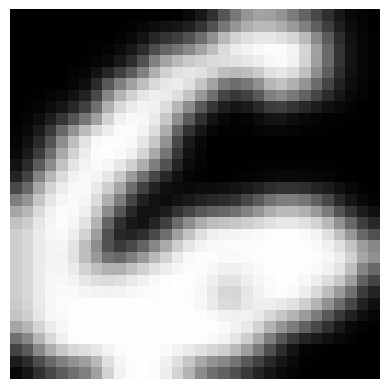

Shape of Input Real Image after 32x32 for class 4: torch.Size([1, 32, 32])
Displaying the first image with label tensor([9, 5, 8, 3, 6, 4, 7, 7, 2, 3, 8, 0, 6, 2, 0, 5, 9, 3, 0, 3, 4, 9, 7, 7,
        1, 9, 7, 1, 5, 2, 7, 6, 8, 3, 6, 8, 4, 4, 1, 1, 3, 0, 7, 6, 6, 2, 7, 3,
        9, 1, 9, 8, 6, 0, 8, 3, 1, 4, 6, 0, 7, 6, 9, 3, 8, 4, 1, 3, 2, 8, 4, 4,
        1, 2, 8, 0, 6, 2, 7, 0, 4, 3, 5, 1, 3, 4, 7, 5, 1, 8, 4, 4, 3, 8, 2, 1,
        7, 1, 7, 8, 8, 9, 7, 0, 0, 0, 6, 0, 1, 1, 5, 8, 4, 8, 9, 3, 2, 9, 5, 2,
        8, 4, 8, 3, 6, 8, 6, 4, 3, 2, 8, 8, 4, 4, 2, 9, 8, 6, 1, 5, 9, 6, 7, 0,
        2, 3, 0, 3, 3, 3, 2, 1, 8, 4, 8, 0, 2, 4, 2, 7, 1, 2, 8, 3, 7, 2, 1, 3,
        8, 0, 1, 8, 2, 5, 1, 8, 4, 2, 9, 8, 6, 3, 4, 3, 5, 4, 1, 6, 2, 5, 5, 3,
        8, 2, 6, 5, 7, 9, 1, 9, 3, 3, 5, 8, 3, 6, 4, 3, 0, 8, 9, 7, 0, 7, 2, 4,
        7, 8, 7, 7, 1, 2, 0, 2, 1, 7, 2, 0, 1, 1, 1, 0, 3, 0, 0, 4, 8, 1, 3, 2,
        3, 4, 1, 0, 6, 4, 3, 1, 3, 2, 7, 2, 4, 0, 6, 2, 6, 4, 0, 6, 7, 8, 8, 6,
       

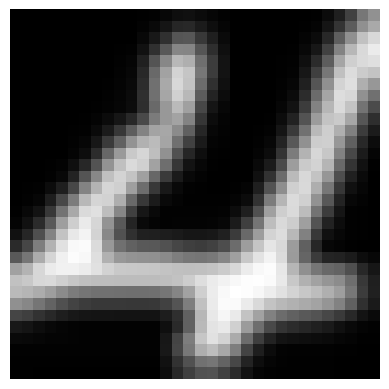

Shape of Input Real Image after 32x32 for class 7: torch.Size([1, 32, 32])
Displaying the first image with label tensor([9, 5, 8, 3, 6, 4, 7, 7, 2, 3, 8, 0, 6, 2, 0, 5, 9, 3, 0, 3, 4, 9, 7, 7,
        1, 9, 7, 1, 5, 2, 7, 6, 8, 3, 6, 8, 4, 4, 1, 1, 3, 0, 7, 6, 6, 2, 7, 3,
        9, 1, 9, 8, 6, 0, 8, 3, 1, 4, 6, 0, 7, 6, 9, 3, 8, 4, 1, 3, 2, 8, 4, 4,
        1, 2, 8, 0, 6, 2, 7, 0, 4, 3, 5, 1, 3, 4, 7, 5, 1, 8, 4, 4, 3, 8, 2, 1,
        7, 1, 7, 8, 8, 9, 7, 0, 0, 0, 6, 0, 1, 1, 5, 8, 4, 8, 9, 3, 2, 9, 5, 2,
        8, 4, 8, 3, 6, 8, 6, 4, 3, 2, 8, 8, 4, 4, 2, 9, 8, 6, 1, 5, 9, 6, 7, 0,
        2, 3, 0, 3, 3, 3, 2, 1, 8, 4, 8, 0, 2, 4, 2, 7, 1, 2, 8, 3, 7, 2, 1, 3,
        8, 0, 1, 8, 2, 5, 1, 8, 4, 2, 9, 8, 6, 3, 4, 3, 5, 4, 1, 6, 2, 5, 5, 3,
        8, 2, 6, 5, 7, 9, 1, 9, 3, 3, 5, 8, 3, 6, 4, 3, 0, 8, 9, 7, 0, 7, 2, 4,
        7, 8, 7, 7, 1, 2, 0, 2, 1, 7, 2, 0, 1, 1, 1, 0, 3, 0, 0, 4, 8, 1, 3, 2,
        3, 4, 1, 0, 6, 4, 3, 1, 3, 2, 7, 2, 4, 0, 6, 2, 6, 4, 0, 6, 7, 8, 8, 6,
       

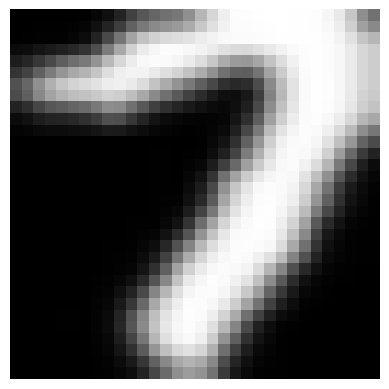

Shape of Input Real Image after 32x32 for class 2: torch.Size([1, 32, 32])
Displaying the first image with label tensor([9, 5, 8, 3, 6, 4, 7, 7, 2, 3, 8, 0, 6, 2, 0, 5, 9, 3, 0, 3, 4, 9, 7, 7,
        1, 9, 7, 1, 5, 2, 7, 6, 8, 3, 6, 8, 4, 4, 1, 1, 3, 0, 7, 6, 6, 2, 7, 3,
        9, 1, 9, 8, 6, 0, 8, 3, 1, 4, 6, 0, 7, 6, 9, 3, 8, 4, 1, 3, 2, 8, 4, 4,
        1, 2, 8, 0, 6, 2, 7, 0, 4, 3, 5, 1, 3, 4, 7, 5, 1, 8, 4, 4, 3, 8, 2, 1,
        7, 1, 7, 8, 8, 9, 7, 0, 0, 0, 6, 0, 1, 1, 5, 8, 4, 8, 9, 3, 2, 9, 5, 2,
        8, 4, 8, 3, 6, 8, 6, 4, 3, 2, 8, 8, 4, 4, 2, 9, 8, 6, 1, 5, 9, 6, 7, 0,
        2, 3, 0, 3, 3, 3, 2, 1, 8, 4, 8, 0, 2, 4, 2, 7, 1, 2, 8, 3, 7, 2, 1, 3,
        8, 0, 1, 8, 2, 5, 1, 8, 4, 2, 9, 8, 6, 3, 4, 3, 5, 4, 1, 6, 2, 5, 5, 3,
        8, 2, 6, 5, 7, 9, 1, 9, 3, 3, 5, 8, 3, 6, 4, 3, 0, 8, 9, 7, 0, 7, 2, 4,
        7, 8, 7, 7, 1, 2, 0, 2, 1, 7, 2, 0, 1, 1, 1, 0, 3, 0, 0, 4, 8, 1, 3, 2,
        3, 4, 1, 0, 6, 4, 3, 1, 3, 2, 7, 2, 4, 0, 6, 2, 6, 4, 0, 6, 7, 8, 8, 6,
       

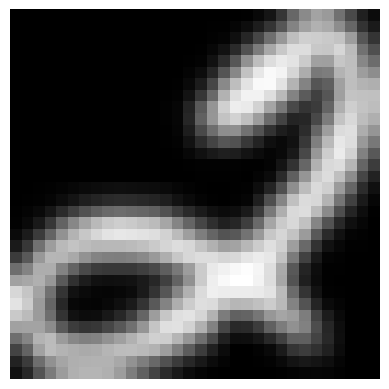

Shape of Input Real Image after 32x32 for class 0: torch.Size([1, 32, 32])
Displaying the first image with label tensor([9, 5, 8, 3, 6, 4, 7, 7, 2, 3, 8, 0, 6, 2, 0, 5, 9, 3, 0, 3, 4, 9, 7, 7,
        1, 9, 7, 1, 5, 2, 7, 6, 8, 3, 6, 8, 4, 4, 1, 1, 3, 0, 7, 6, 6, 2, 7, 3,
        9, 1, 9, 8, 6, 0, 8, 3, 1, 4, 6, 0, 7, 6, 9, 3, 8, 4, 1, 3, 2, 8, 4, 4,
        1, 2, 8, 0, 6, 2, 7, 0, 4, 3, 5, 1, 3, 4, 7, 5, 1, 8, 4, 4, 3, 8, 2, 1,
        7, 1, 7, 8, 8, 9, 7, 0, 0, 0, 6, 0, 1, 1, 5, 8, 4, 8, 9, 3, 2, 9, 5, 2,
        8, 4, 8, 3, 6, 8, 6, 4, 3, 2, 8, 8, 4, 4, 2, 9, 8, 6, 1, 5, 9, 6, 7, 0,
        2, 3, 0, 3, 3, 3, 2, 1, 8, 4, 8, 0, 2, 4, 2, 7, 1, 2, 8, 3, 7, 2, 1, 3,
        8, 0, 1, 8, 2, 5, 1, 8, 4, 2, 9, 8, 6, 3, 4, 3, 5, 4, 1, 6, 2, 5, 5, 3,
        8, 2, 6, 5, 7, 9, 1, 9, 3, 3, 5, 8, 3, 6, 4, 3, 0, 8, 9, 7, 0, 7, 2, 4,
        7, 8, 7, 7, 1, 2, 0, 2, 1, 7, 2, 0, 1, 1, 1, 0, 3, 0, 0, 4, 8, 1, 3, 2,
        3, 4, 1, 0, 6, 4, 3, 1, 3, 2, 7, 2, 4, 0, 6, 2, 6, 4, 0, 6, 7, 8, 8, 6,
       

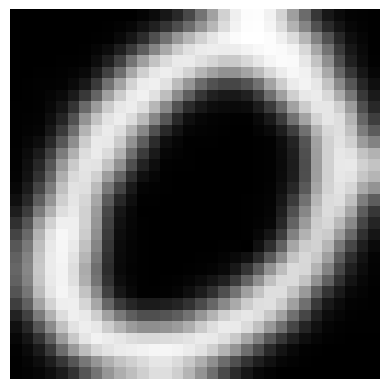

Shape of Input Real Image after 32x32 for class 1: torch.Size([1, 32, 32])
Displaying the first image with label tensor([9, 5, 8, 3, 6, 4, 7, 7, 2, 3, 8, 0, 6, 2, 0, 5, 9, 3, 0, 3, 4, 9, 7, 7,
        1, 9, 7, 1, 5, 2, 7, 6, 8, 3, 6, 8, 4, 4, 1, 1, 3, 0, 7, 6, 6, 2, 7, 3,
        9, 1, 9, 8, 6, 0, 8, 3, 1, 4, 6, 0, 7, 6, 9, 3, 8, 4, 1, 3, 2, 8, 4, 4,
        1, 2, 8, 0, 6, 2, 7, 0, 4, 3, 5, 1, 3, 4, 7, 5, 1, 8, 4, 4, 3, 8, 2, 1,
        7, 1, 7, 8, 8, 9, 7, 0, 0, 0, 6, 0, 1, 1, 5, 8, 4, 8, 9, 3, 2, 9, 5, 2,
        8, 4, 8, 3, 6, 8, 6, 4, 3, 2, 8, 8, 4, 4, 2, 9, 8, 6, 1, 5, 9, 6, 7, 0,
        2, 3, 0, 3, 3, 3, 2, 1, 8, 4, 8, 0, 2, 4, 2, 7, 1, 2, 8, 3, 7, 2, 1, 3,
        8, 0, 1, 8, 2, 5, 1, 8, 4, 2, 9, 8, 6, 3, 4, 3, 5, 4, 1, 6, 2, 5, 5, 3,
        8, 2, 6, 5, 7, 9, 1, 9, 3, 3, 5, 8, 3, 6, 4, 3, 0, 8, 9, 7, 0, 7, 2, 4,
        7, 8, 7, 7, 1, 2, 0, 2, 1, 7, 2, 0, 1, 1, 1, 0, 3, 0, 0, 4, 8, 1, 3, 2,
        3, 4, 1, 0, 6, 4, 3, 1, 3, 2, 7, 2, 4, 0, 6, 2, 6, 4, 0, 6, 7, 8, 8, 6,
       

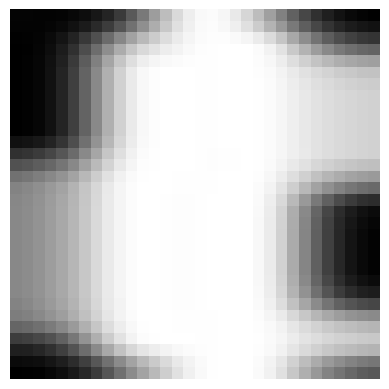

In [26]:

# Function to display an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize if necessary
    npimg = img.numpy()  # Convert tensor to NumPy array

    # Check if the image is grayscale or color
    if npimg.ndim == 3 and npimg.shape[0] == 1:  # Grayscale image (1, height, width)
        plt.imshow(npimg[0], cmap='gray')  # Remove the first dimension for grayscale
    elif npimg.ndim == 3 and npimg.shape[0] == 3:  # Color image (3, height, width)
        plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose to (height, width, channels)
    else:
        raise ValueError(f"Unsupported image shape: {npimg.shape}")

    plt.axis('off')  # Hide axes
    plt.show()

# Fetch and display the first image of class 6 from the trainloader
class_label = set()
found = False

# Loop through batches in the trainloader
for q_images, images, labels in trainloader:
    # Loop through each image in the current batch
    for i in range(len(labels)):
        label = labels[i].item()  # Get class label as an integer
        if label not in class_label:
            print(f"Shape of Input Real Image after 32x32 for class {labels[i]}: {images[i].shape}")
            print(f"Displaying the first image with label {labels}:")
            imshow(images[i])  # Display the image
            class_label.add(label)  # Mark class as displayed
        # Stop if all classes have been displayed
        if len(class_label) == 10:  # Assuming there are 10 classes in USPS
            break
    if len(class_label) == 10:
        break

Shape of Input Image after 32x32 to 16x16 for class 9: torch.Size([16, 16])
Displaying the first image with label tensor([9, 4, 1, 7, 6, 2, 5, 3, 3, 0, 6, 4, 8, 4, 1, 9, 0, 9, 4, 2, 9, 0, 7, 9,
        7, 8, 2, 0, 5, 8, 3, 3, 6, 7, 3, 0, 2, 0, 5, 0, 0, 4, 7, 8, 7, 0, 1, 7,
        0, 9, 1, 5, 6, 3, 2, 8, 6, 4, 1, 5, 7, 5, 7, 0, 1, 8, 2, 6, 9, 6, 7, 9,
        4, 0, 1, 0, 5, 9, 9, 0, 7, 5, 1, 5, 7, 8, 0, 2, 2, 1, 8, 1, 7, 6, 7, 4,
        7, 8, 3, 8, 8, 8, 4, 9, 9, 4, 1, 0, 9, 1, 9, 3, 5, 1, 5, 4, 5, 3, 1, 2,
        1, 5, 2, 7, 2, 9, 2, 0, 4, 4, 7, 2, 5, 8, 1, 3, 6, 1, 6, 5, 1, 9, 0, 1,
        8, 5, 5, 5, 4, 5, 7, 7, 4, 3, 2, 0, 7, 6, 5, 4, 8, 7, 8, 6, 6, 6, 7, 1,
        3, 3, 1, 1, 9, 7, 7, 0, 1, 6, 0, 1, 9, 9, 3, 1, 1, 4, 5, 5, 8, 9, 6, 7,
        5, 8, 3, 3, 8, 4, 7, 7, 6, 4, 1, 0, 7, 0, 4, 7, 3, 1, 5, 1, 0, 2, 6, 6,
        1, 3, 9, 2, 2, 7, 1, 6, 0, 7, 1, 4, 2, 7, 5, 2, 0, 7, 9, 2, 8, 2, 7, 7,
        8, 8, 9, 9, 9, 6, 5, 9, 5, 7, 3, 1, 6, 9, 9, 0, 5, 0, 8, 5, 8, 9, 7, 3,
      

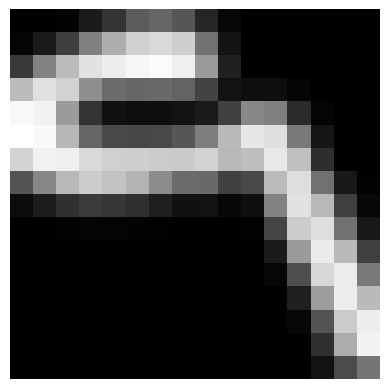

Shape of Input Image after 32x32 to 16x16 for class 4: torch.Size([16, 16])
Displaying the first image with label tensor([9, 4, 1, 7, 6, 2, 5, 3, 3, 0, 6, 4, 8, 4, 1, 9, 0, 9, 4, 2, 9, 0, 7, 9,
        7, 8, 2, 0, 5, 8, 3, 3, 6, 7, 3, 0, 2, 0, 5, 0, 0, 4, 7, 8, 7, 0, 1, 7,
        0, 9, 1, 5, 6, 3, 2, 8, 6, 4, 1, 5, 7, 5, 7, 0, 1, 8, 2, 6, 9, 6, 7, 9,
        4, 0, 1, 0, 5, 9, 9, 0, 7, 5, 1, 5, 7, 8, 0, 2, 2, 1, 8, 1, 7, 6, 7, 4,
        7, 8, 3, 8, 8, 8, 4, 9, 9, 4, 1, 0, 9, 1, 9, 3, 5, 1, 5, 4, 5, 3, 1, 2,
        1, 5, 2, 7, 2, 9, 2, 0, 4, 4, 7, 2, 5, 8, 1, 3, 6, 1, 6, 5, 1, 9, 0, 1,
        8, 5, 5, 5, 4, 5, 7, 7, 4, 3, 2, 0, 7, 6, 5, 4, 8, 7, 8, 6, 6, 6, 7, 1,
        3, 3, 1, 1, 9, 7, 7, 0, 1, 6, 0, 1, 9, 9, 3, 1, 1, 4, 5, 5, 8, 9, 6, 7,
        5, 8, 3, 3, 8, 4, 7, 7, 6, 4, 1, 0, 7, 0, 4, 7, 3, 1, 5, 1, 0, 2, 6, 6,
        1, 3, 9, 2, 2, 7, 1, 6, 0, 7, 1, 4, 2, 7, 5, 2, 0, 7, 9, 2, 8, 2, 7, 7,
        8, 8, 9, 9, 9, 6, 5, 9, 5, 7, 3, 1, 6, 9, 9, 0, 5, 0, 8, 5, 8, 9, 7, 3,
      

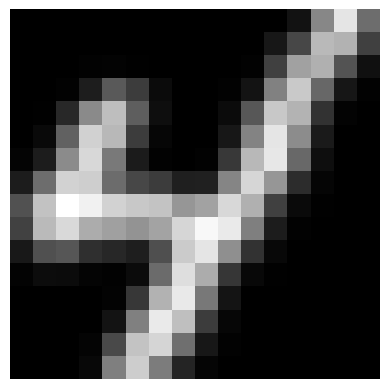

Shape of Input Image after 32x32 to 16x16 for class 1: torch.Size([16, 16])
Displaying the first image with label tensor([9, 4, 1, 7, 6, 2, 5, 3, 3, 0, 6, 4, 8, 4, 1, 9, 0, 9, 4, 2, 9, 0, 7, 9,
        7, 8, 2, 0, 5, 8, 3, 3, 6, 7, 3, 0, 2, 0, 5, 0, 0, 4, 7, 8, 7, 0, 1, 7,
        0, 9, 1, 5, 6, 3, 2, 8, 6, 4, 1, 5, 7, 5, 7, 0, 1, 8, 2, 6, 9, 6, 7, 9,
        4, 0, 1, 0, 5, 9, 9, 0, 7, 5, 1, 5, 7, 8, 0, 2, 2, 1, 8, 1, 7, 6, 7, 4,
        7, 8, 3, 8, 8, 8, 4, 9, 9, 4, 1, 0, 9, 1, 9, 3, 5, 1, 5, 4, 5, 3, 1, 2,
        1, 5, 2, 7, 2, 9, 2, 0, 4, 4, 7, 2, 5, 8, 1, 3, 6, 1, 6, 5, 1, 9, 0, 1,
        8, 5, 5, 5, 4, 5, 7, 7, 4, 3, 2, 0, 7, 6, 5, 4, 8, 7, 8, 6, 6, 6, 7, 1,
        3, 3, 1, 1, 9, 7, 7, 0, 1, 6, 0, 1, 9, 9, 3, 1, 1, 4, 5, 5, 8, 9, 6, 7,
        5, 8, 3, 3, 8, 4, 7, 7, 6, 4, 1, 0, 7, 0, 4, 7, 3, 1, 5, 1, 0, 2, 6, 6,
        1, 3, 9, 2, 2, 7, 1, 6, 0, 7, 1, 4, 2, 7, 5, 2, 0, 7, 9, 2, 8, 2, 7, 7,
        8, 8, 9, 9, 9, 6, 5, 9, 5, 7, 3, 1, 6, 9, 9, 0, 5, 0, 8, 5, 8, 9, 7, 3,
      

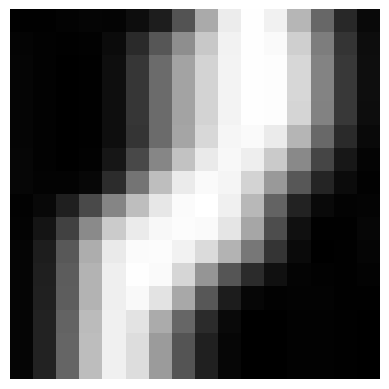

Shape of Input Image after 32x32 to 16x16 for class 7: torch.Size([16, 16])
Displaying the first image with label tensor([9, 4, 1, 7, 6, 2, 5, 3, 3, 0, 6, 4, 8, 4, 1, 9, 0, 9, 4, 2, 9, 0, 7, 9,
        7, 8, 2, 0, 5, 8, 3, 3, 6, 7, 3, 0, 2, 0, 5, 0, 0, 4, 7, 8, 7, 0, 1, 7,
        0, 9, 1, 5, 6, 3, 2, 8, 6, 4, 1, 5, 7, 5, 7, 0, 1, 8, 2, 6, 9, 6, 7, 9,
        4, 0, 1, 0, 5, 9, 9, 0, 7, 5, 1, 5, 7, 8, 0, 2, 2, 1, 8, 1, 7, 6, 7, 4,
        7, 8, 3, 8, 8, 8, 4, 9, 9, 4, 1, 0, 9, 1, 9, 3, 5, 1, 5, 4, 5, 3, 1, 2,
        1, 5, 2, 7, 2, 9, 2, 0, 4, 4, 7, 2, 5, 8, 1, 3, 6, 1, 6, 5, 1, 9, 0, 1,
        8, 5, 5, 5, 4, 5, 7, 7, 4, 3, 2, 0, 7, 6, 5, 4, 8, 7, 8, 6, 6, 6, 7, 1,
        3, 3, 1, 1, 9, 7, 7, 0, 1, 6, 0, 1, 9, 9, 3, 1, 1, 4, 5, 5, 8, 9, 6, 7,
        5, 8, 3, 3, 8, 4, 7, 7, 6, 4, 1, 0, 7, 0, 4, 7, 3, 1, 5, 1, 0, 2, 6, 6,
        1, 3, 9, 2, 2, 7, 1, 6, 0, 7, 1, 4, 2, 7, 5, 2, 0, 7, 9, 2, 8, 2, 7, 7,
        8, 8, 9, 9, 9, 6, 5, 9, 5, 7, 3, 1, 6, 9, 9, 0, 5, 0, 8, 5, 8, 9, 7, 3,
      

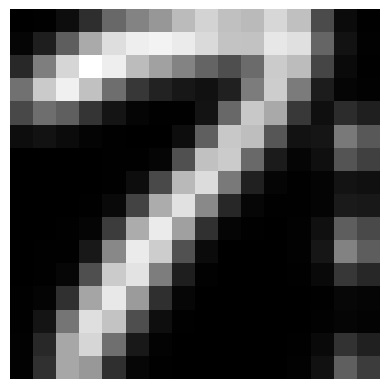

Shape of Input Image after 32x32 to 16x16 for class 6: torch.Size([16, 16])
Displaying the first image with label tensor([9, 4, 1, 7, 6, 2, 5, 3, 3, 0, 6, 4, 8, 4, 1, 9, 0, 9, 4, 2, 9, 0, 7, 9,
        7, 8, 2, 0, 5, 8, 3, 3, 6, 7, 3, 0, 2, 0, 5, 0, 0, 4, 7, 8, 7, 0, 1, 7,
        0, 9, 1, 5, 6, 3, 2, 8, 6, 4, 1, 5, 7, 5, 7, 0, 1, 8, 2, 6, 9, 6, 7, 9,
        4, 0, 1, 0, 5, 9, 9, 0, 7, 5, 1, 5, 7, 8, 0, 2, 2, 1, 8, 1, 7, 6, 7, 4,
        7, 8, 3, 8, 8, 8, 4, 9, 9, 4, 1, 0, 9, 1, 9, 3, 5, 1, 5, 4, 5, 3, 1, 2,
        1, 5, 2, 7, 2, 9, 2, 0, 4, 4, 7, 2, 5, 8, 1, 3, 6, 1, 6, 5, 1, 9, 0, 1,
        8, 5, 5, 5, 4, 5, 7, 7, 4, 3, 2, 0, 7, 6, 5, 4, 8, 7, 8, 6, 6, 6, 7, 1,
        3, 3, 1, 1, 9, 7, 7, 0, 1, 6, 0, 1, 9, 9, 3, 1, 1, 4, 5, 5, 8, 9, 6, 7,
        5, 8, 3, 3, 8, 4, 7, 7, 6, 4, 1, 0, 7, 0, 4, 7, 3, 1, 5, 1, 0, 2, 6, 6,
        1, 3, 9, 2, 2, 7, 1, 6, 0, 7, 1, 4, 2, 7, 5, 2, 0, 7, 9, 2, 8, 2, 7, 7,
        8, 8, 9, 9, 9, 6, 5, 9, 5, 7, 3, 1, 6, 9, 9, 0, 5, 0, 8, 5, 8, 9, 7, 3,
      

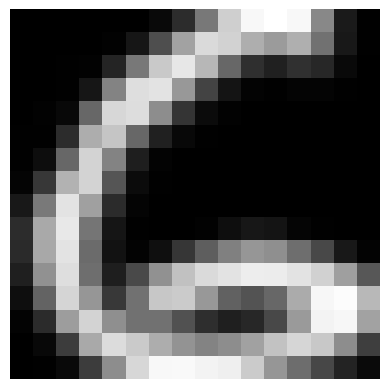

Shape of Input Image after 32x32 to 16x16 for class 2: torch.Size([16, 16])
Displaying the first image with label tensor([9, 4, 1, 7, 6, 2, 5, 3, 3, 0, 6, 4, 8, 4, 1, 9, 0, 9, 4, 2, 9, 0, 7, 9,
        7, 8, 2, 0, 5, 8, 3, 3, 6, 7, 3, 0, 2, 0, 5, 0, 0, 4, 7, 8, 7, 0, 1, 7,
        0, 9, 1, 5, 6, 3, 2, 8, 6, 4, 1, 5, 7, 5, 7, 0, 1, 8, 2, 6, 9, 6, 7, 9,
        4, 0, 1, 0, 5, 9, 9, 0, 7, 5, 1, 5, 7, 8, 0, 2, 2, 1, 8, 1, 7, 6, 7, 4,
        7, 8, 3, 8, 8, 8, 4, 9, 9, 4, 1, 0, 9, 1, 9, 3, 5, 1, 5, 4, 5, 3, 1, 2,
        1, 5, 2, 7, 2, 9, 2, 0, 4, 4, 7, 2, 5, 8, 1, 3, 6, 1, 6, 5, 1, 9, 0, 1,
        8, 5, 5, 5, 4, 5, 7, 7, 4, 3, 2, 0, 7, 6, 5, 4, 8, 7, 8, 6, 6, 6, 7, 1,
        3, 3, 1, 1, 9, 7, 7, 0, 1, 6, 0, 1, 9, 9, 3, 1, 1, 4, 5, 5, 8, 9, 6, 7,
        5, 8, 3, 3, 8, 4, 7, 7, 6, 4, 1, 0, 7, 0, 4, 7, 3, 1, 5, 1, 0, 2, 6, 6,
        1, 3, 9, 2, 2, 7, 1, 6, 0, 7, 1, 4, 2, 7, 5, 2, 0, 7, 9, 2, 8, 2, 7, 7,
        8, 8, 9, 9, 9, 6, 5, 9, 5, 7, 3, 1, 6, 9, 9, 0, 5, 0, 8, 5, 8, 9, 7, 3,
      

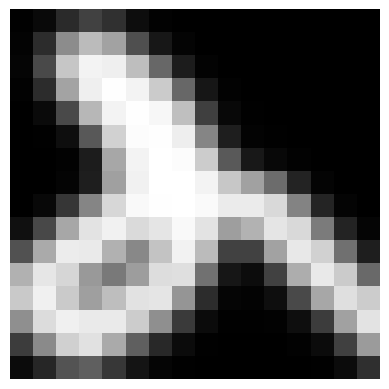

Shape of Input Image after 32x32 to 16x16 for class 5: torch.Size([16, 16])
Displaying the first image with label tensor([9, 4, 1, 7, 6, 2, 5, 3, 3, 0, 6, 4, 8, 4, 1, 9, 0, 9, 4, 2, 9, 0, 7, 9,
        7, 8, 2, 0, 5, 8, 3, 3, 6, 7, 3, 0, 2, 0, 5, 0, 0, 4, 7, 8, 7, 0, 1, 7,
        0, 9, 1, 5, 6, 3, 2, 8, 6, 4, 1, 5, 7, 5, 7, 0, 1, 8, 2, 6, 9, 6, 7, 9,
        4, 0, 1, 0, 5, 9, 9, 0, 7, 5, 1, 5, 7, 8, 0, 2, 2, 1, 8, 1, 7, 6, 7, 4,
        7, 8, 3, 8, 8, 8, 4, 9, 9, 4, 1, 0, 9, 1, 9, 3, 5, 1, 5, 4, 5, 3, 1, 2,
        1, 5, 2, 7, 2, 9, 2, 0, 4, 4, 7, 2, 5, 8, 1, 3, 6, 1, 6, 5, 1, 9, 0, 1,
        8, 5, 5, 5, 4, 5, 7, 7, 4, 3, 2, 0, 7, 6, 5, 4, 8, 7, 8, 6, 6, 6, 7, 1,
        3, 3, 1, 1, 9, 7, 7, 0, 1, 6, 0, 1, 9, 9, 3, 1, 1, 4, 5, 5, 8, 9, 6, 7,
        5, 8, 3, 3, 8, 4, 7, 7, 6, 4, 1, 0, 7, 0, 4, 7, 3, 1, 5, 1, 0, 2, 6, 6,
        1, 3, 9, 2, 2, 7, 1, 6, 0, 7, 1, 4, 2, 7, 5, 2, 0, 7, 9, 2, 8, 2, 7, 7,
        8, 8, 9, 9, 9, 6, 5, 9, 5, 7, 3, 1, 6, 9, 9, 0, 5, 0, 8, 5, 8, 9, 7, 3,
      

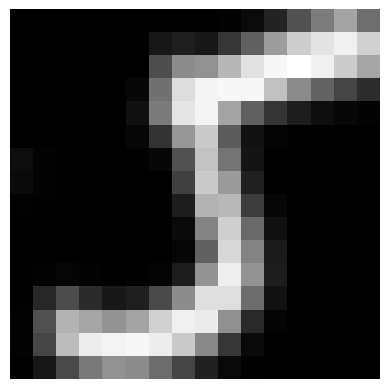

Shape of Input Image after 32x32 to 16x16 for class 3: torch.Size([16, 16])
Displaying the first image with label tensor([9, 4, 1, 7, 6, 2, 5, 3, 3, 0, 6, 4, 8, 4, 1, 9, 0, 9, 4, 2, 9, 0, 7, 9,
        7, 8, 2, 0, 5, 8, 3, 3, 6, 7, 3, 0, 2, 0, 5, 0, 0, 4, 7, 8, 7, 0, 1, 7,
        0, 9, 1, 5, 6, 3, 2, 8, 6, 4, 1, 5, 7, 5, 7, 0, 1, 8, 2, 6, 9, 6, 7, 9,
        4, 0, 1, 0, 5, 9, 9, 0, 7, 5, 1, 5, 7, 8, 0, 2, 2, 1, 8, 1, 7, 6, 7, 4,
        7, 8, 3, 8, 8, 8, 4, 9, 9, 4, 1, 0, 9, 1, 9, 3, 5, 1, 5, 4, 5, 3, 1, 2,
        1, 5, 2, 7, 2, 9, 2, 0, 4, 4, 7, 2, 5, 8, 1, 3, 6, 1, 6, 5, 1, 9, 0, 1,
        8, 5, 5, 5, 4, 5, 7, 7, 4, 3, 2, 0, 7, 6, 5, 4, 8, 7, 8, 6, 6, 6, 7, 1,
        3, 3, 1, 1, 9, 7, 7, 0, 1, 6, 0, 1, 9, 9, 3, 1, 1, 4, 5, 5, 8, 9, 6, 7,
        5, 8, 3, 3, 8, 4, 7, 7, 6, 4, 1, 0, 7, 0, 4, 7, 3, 1, 5, 1, 0, 2, 6, 6,
        1, 3, 9, 2, 2, 7, 1, 6, 0, 7, 1, 4, 2, 7, 5, 2, 0, 7, 9, 2, 8, 2, 7, 7,
        8, 8, 9, 9, 9, 6, 5, 9, 5, 7, 3, 1, 6, 9, 9, 0, 5, 0, 8, 5, 8, 9, 7, 3,
      

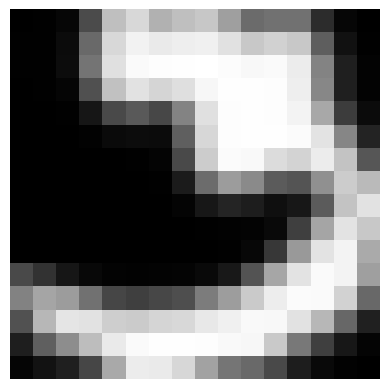

Shape of Input Image after 32x32 to 16x16 for class 0: torch.Size([16, 16])
Displaying the first image with label tensor([9, 4, 1, 7, 6, 2, 5, 3, 3, 0, 6, 4, 8, 4, 1, 9, 0, 9, 4, 2, 9, 0, 7, 9,
        7, 8, 2, 0, 5, 8, 3, 3, 6, 7, 3, 0, 2, 0, 5, 0, 0, 4, 7, 8, 7, 0, 1, 7,
        0, 9, 1, 5, 6, 3, 2, 8, 6, 4, 1, 5, 7, 5, 7, 0, 1, 8, 2, 6, 9, 6, 7, 9,
        4, 0, 1, 0, 5, 9, 9, 0, 7, 5, 1, 5, 7, 8, 0, 2, 2, 1, 8, 1, 7, 6, 7, 4,
        7, 8, 3, 8, 8, 8, 4, 9, 9, 4, 1, 0, 9, 1, 9, 3, 5, 1, 5, 4, 5, 3, 1, 2,
        1, 5, 2, 7, 2, 9, 2, 0, 4, 4, 7, 2, 5, 8, 1, 3, 6, 1, 6, 5, 1, 9, 0, 1,
        8, 5, 5, 5, 4, 5, 7, 7, 4, 3, 2, 0, 7, 6, 5, 4, 8, 7, 8, 6, 6, 6, 7, 1,
        3, 3, 1, 1, 9, 7, 7, 0, 1, 6, 0, 1, 9, 9, 3, 1, 1, 4, 5, 5, 8, 9, 6, 7,
        5, 8, 3, 3, 8, 4, 7, 7, 6, 4, 1, 0, 7, 0, 4, 7, 3, 1, 5, 1, 0, 2, 6, 6,
        1, 3, 9, 2, 2, 7, 1, 6, 0, 7, 1, 4, 2, 7, 5, 2, 0, 7, 9, 2, 8, 2, 7, 7,
        8, 8, 9, 9, 9, 6, 5, 9, 5, 7, 3, 1, 6, 9, 9, 0, 5, 0, 8, 5, 8, 9, 7, 3,
      

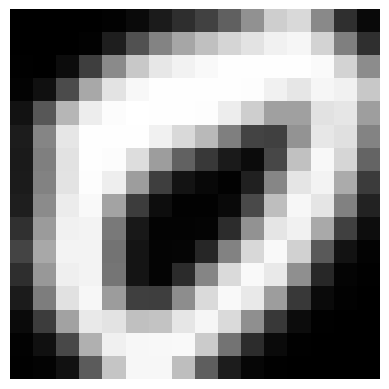

Shape of Input Image after 32x32 to 16x16 for class 8: torch.Size([16, 16])
Displaying the first image with label tensor([9, 4, 1, 7, 6, 2, 5, 3, 3, 0, 6, 4, 8, 4, 1, 9, 0, 9, 4, 2, 9, 0, 7, 9,
        7, 8, 2, 0, 5, 8, 3, 3, 6, 7, 3, 0, 2, 0, 5, 0, 0, 4, 7, 8, 7, 0, 1, 7,
        0, 9, 1, 5, 6, 3, 2, 8, 6, 4, 1, 5, 7, 5, 7, 0, 1, 8, 2, 6, 9, 6, 7, 9,
        4, 0, 1, 0, 5, 9, 9, 0, 7, 5, 1, 5, 7, 8, 0, 2, 2, 1, 8, 1, 7, 6, 7, 4,
        7, 8, 3, 8, 8, 8, 4, 9, 9, 4, 1, 0, 9, 1, 9, 3, 5, 1, 5, 4, 5, 3, 1, 2,
        1, 5, 2, 7, 2, 9, 2, 0, 4, 4, 7, 2, 5, 8, 1, 3, 6, 1, 6, 5, 1, 9, 0, 1,
        8, 5, 5, 5, 4, 5, 7, 7, 4, 3, 2, 0, 7, 6, 5, 4, 8, 7, 8, 6, 6, 6, 7, 1,
        3, 3, 1, 1, 9, 7, 7, 0, 1, 6, 0, 1, 9, 9, 3, 1, 1, 4, 5, 5, 8, 9, 6, 7,
        5, 8, 3, 3, 8, 4, 7, 7, 6, 4, 1, 0, 7, 0, 4, 7, 3, 1, 5, 1, 0, 2, 6, 6,
        1, 3, 9, 2, 2, 7, 1, 6, 0, 7, 1, 4, 2, 7, 5, 2, 0, 7, 9, 2, 8, 2, 7, 7,
        8, 8, 9, 9, 9, 6, 5, 9, 5, 7, 3, 1, 6, 9, 9, 0, 5, 0, 8, 5, 8, 9, 7, 3,
      

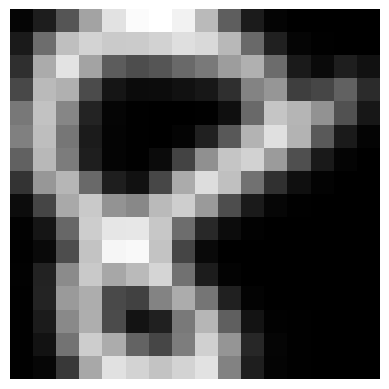

In [27]:

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize (if images were normalized during training)
    npimg = img.numpy()  # Convert tensor to NumPy array
    
    # Check if the image is grayscale or color
    if npimg.ndim == 2:  # Grayscale image (height, width)
        plt.imshow(npimg, cmap='gray')
    elif npimg.ndim == 3 and npimg.shape[0] in [1, 3]:  # Single-channel or 3-channel image
        plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray' if npimg.shape[0] == 1 else None)
    else:
        raise ValueError("Unsupported image shape: {}".format(npimg.shape))
        
    plt.axis('off')  # Hide axes
    plt.show()

#print(q_images.shape)
# Filter images from class 5
class_label = set()
found = False

# Loop through batches in the trainloader
for q_images, images, labels in trainloader:
    # Loop through each image in the current batch
    for i in range(len(labels)):
        label = labels[i].item()  # Get class label as an integer
        if label not in class_label:
            print(f"Shape of Input Image after 32x32 to 16x16 for class {labels[i]}: {q_images[i].shape}")
            print(f"Displaying the first image with label {labels}:")
            imshow(q_images[i])  # Display the image
            class_label.add(label)  # Mark class as displayed
        # Stop if all classes have been displayed
        if len(class_label) == 10:  # Assuming there are 10 classes in USPS
            break
    if len(class_label) == 10:
        break

Shape of Original Image for class 2: torch.Size([1, 32, 32])
Displaying the first image with label 2:


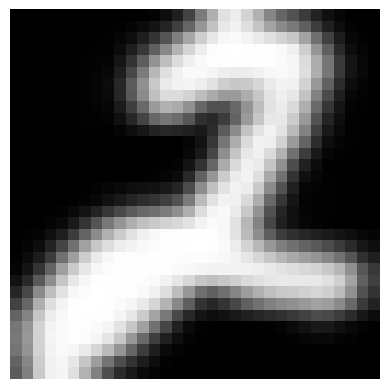

Shape of Original Image for class 9: torch.Size([1, 32, 32])
Displaying the first image with label 9:


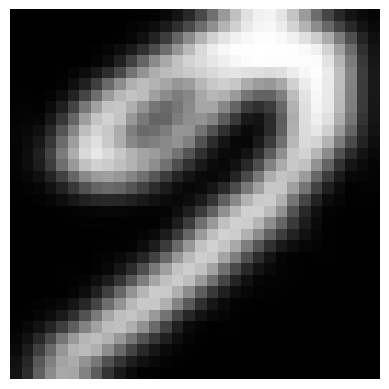

Shape of Original Image for class 7: torch.Size([1, 32, 32])
Displaying the first image with label 7:


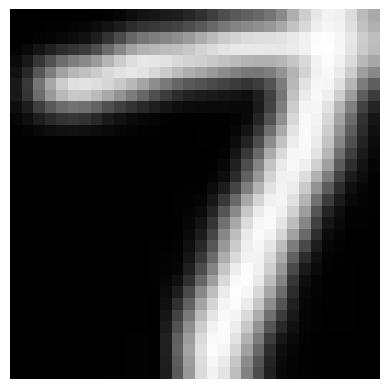

Shape of Original Image for class 6: torch.Size([1, 32, 32])
Displaying the first image with label 6:


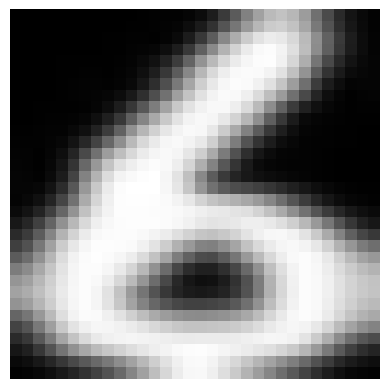

Shape of Original Image for class 1: torch.Size([1, 32, 32])
Displaying the first image with label 1:


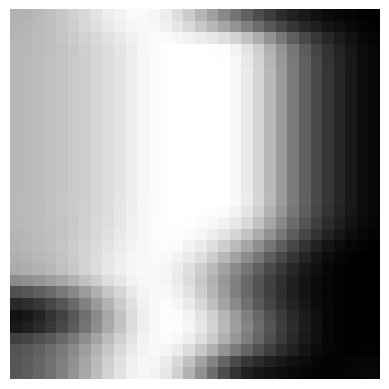

Shape of Original Image for class 3: torch.Size([1, 32, 32])
Displaying the first image with label 3:


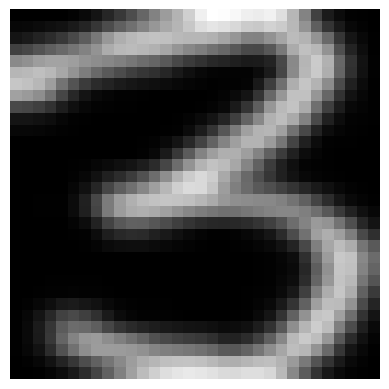

Shape of Original Image for class 4: torch.Size([1, 32, 32])
Displaying the first image with label 4:


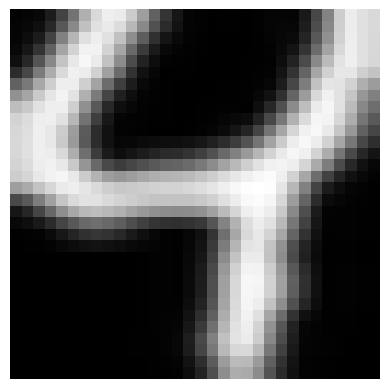

Shape of Original Image for class 8: torch.Size([1, 32, 32])
Displaying the first image with label 8:


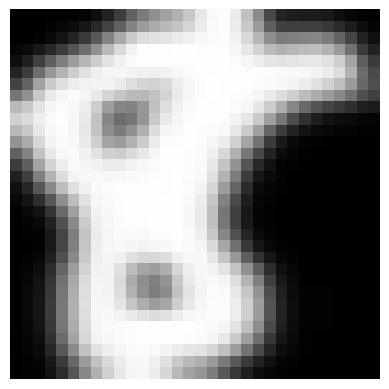

Shape of Original Image for class 5: torch.Size([1, 32, 32])
Displaying the first image with label 5:


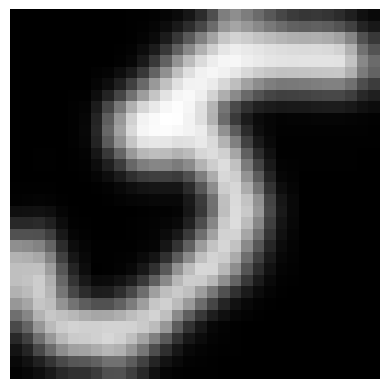

Shape of Original Image for class 0: torch.Size([1, 32, 32])
Displaying the first image with label 0:


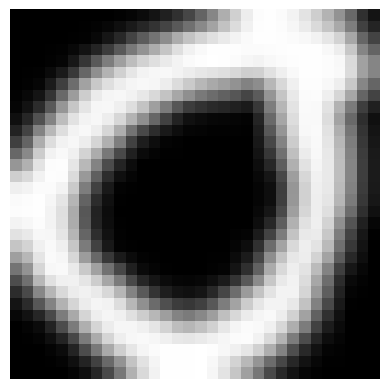


Displaying the corresponding classial reconstructed images:
Displaying reconstructed image for class 2 at index 0:


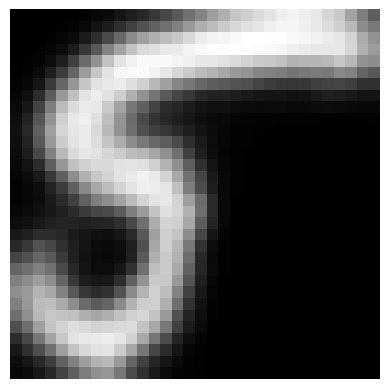

Displaying reconstructed image for class 9 at index 1:


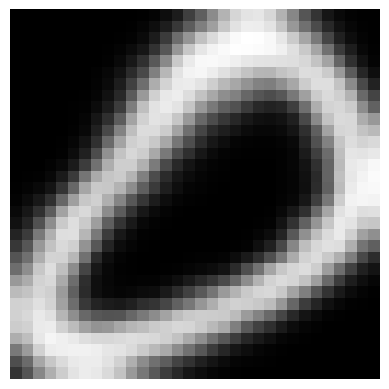

Displaying reconstructed image for class 7 at index 2:


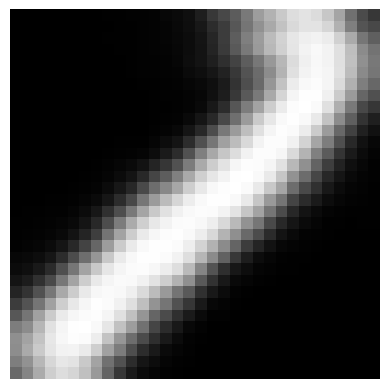

Displaying reconstructed image for class 6 at index 3:


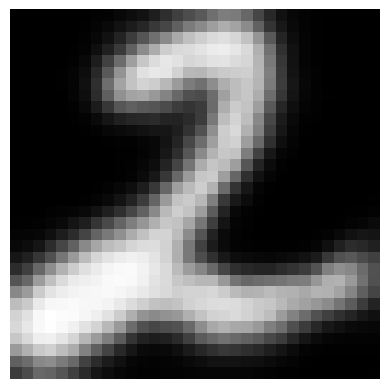

Displaying reconstructed image for class 1 at index 4:


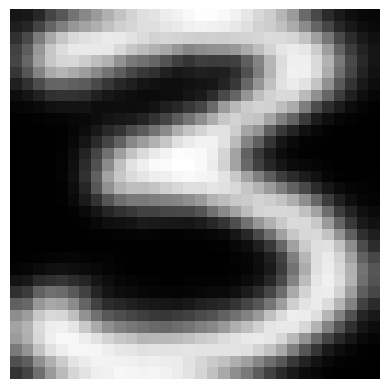

Displaying reconstructed image for class 3 at index 8:


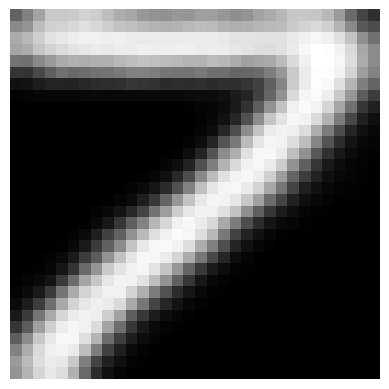

Displaying reconstructed image for class 4 at index 9:


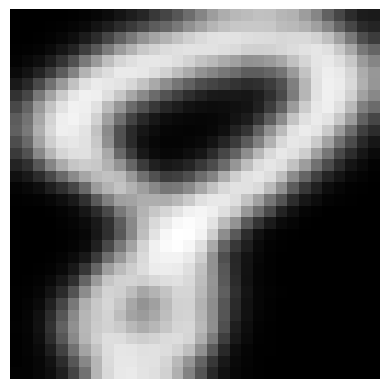

Displaying reconstructed image for class 8 at index 12:


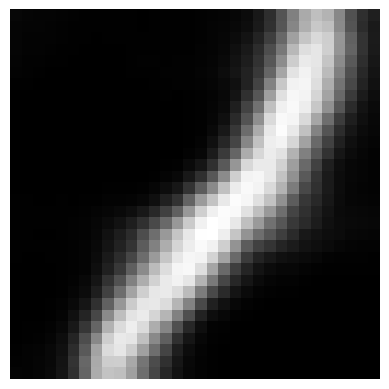

Displaying reconstructed image for class 5 at index 16:


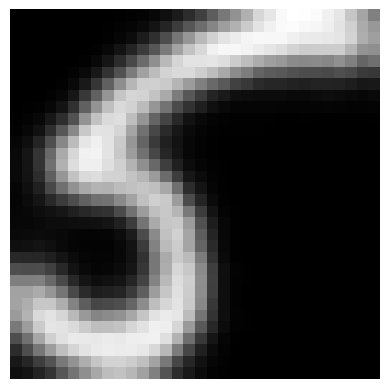

Displaying reconstructed image for class 0 at index 59:


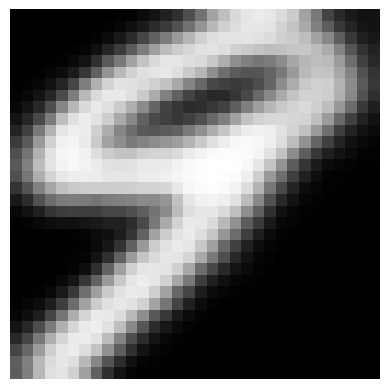

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to display an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize if necessary
    npimg = img.numpy()  # Convert tensor to NumPy array
    if npimg.ndim == 3 and npimg.shape[0] == 1:  # Grayscale image
        plt.imshow(npimg[0], cmap='gray')
    elif npimg.ndim == 2:  # Direct 2D grayscale image
        plt.imshow(npimg, cmap='gray')
    else:
        raise ValueError(f"Unsupported image shape: {npimg.shape}")

    plt.axis('off')  # Hide axes
    plt.show()

# Set up to track first occurrence of each class
first_indices = {}
class_labels = set()
found=False
# Loop through batches in the trainloader
for batch_idx, (q_images, images, labels) in enumerate(trainloader):
    for i in range(len(labels)):
        label = labels[i].item()  # Get label as integer
        if label not in class_labels:
            print(f"Shape of Original Image for class {label}: {images[i].shape}")
            print(f"Displaying the first image with label {label}:")
            imshow(images[i])  # Display the first image of this class

            first_indices[label] = batch_idx * len(labels) + i  # Store index
            class_labels.add(label)
            found=True

        if len(class_labels) == 10:  # Assuming USPS has 10 classes
            break
    if len(class_labels) == 10:
        break

# Now display the corresponding reconstructed images for the same indices
print("\nDisplaying the corresponding classial reconstructed images:")

for label, index in first_indices.items():
    print(f"Displaying reconstructed image for class {label} at index {index}:")
    reconstructed_image = c_reconstructed_images[index].view(1, 32, 32)  # Reshape if necessary
    imshow(reconstructed_image.detach().cpu())  # Detach and move to CPU for display

Shape of Original Image for class 6: torch.Size([1, 32, 32])
Displaying the first image with label 6:


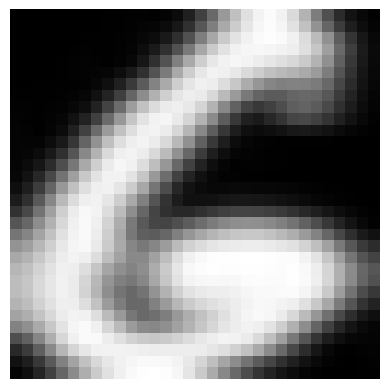

Shape of Original Image for class 2: torch.Size([1, 32, 32])
Displaying the first image with label 2:


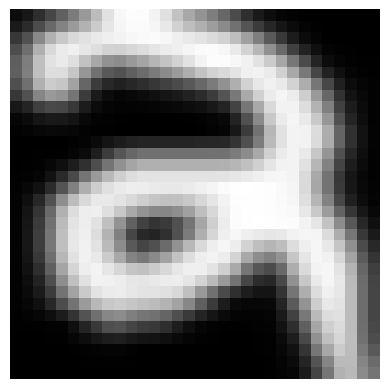

Shape of Original Image for class 3: torch.Size([1, 32, 32])
Displaying the first image with label 3:


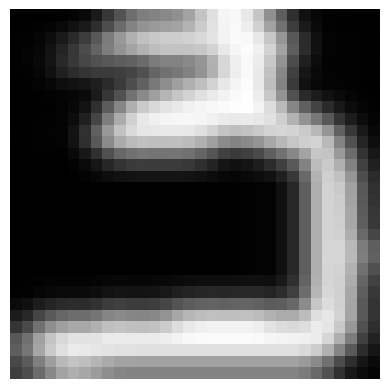

Shape of Original Image for class 1: torch.Size([1, 32, 32])
Displaying the first image with label 1:


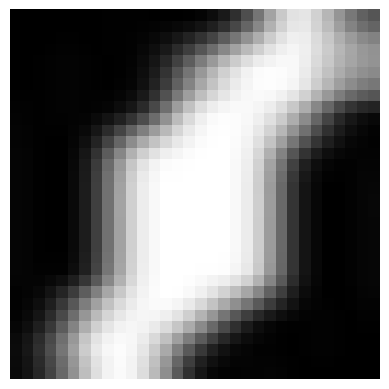

Shape of Original Image for class 4: torch.Size([1, 32, 32])
Displaying the first image with label 4:


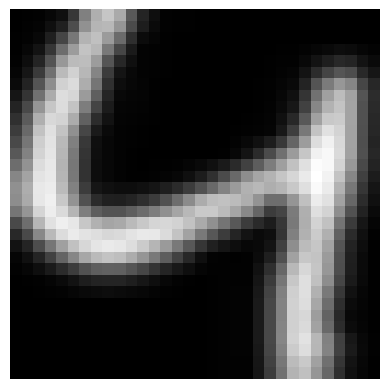

Shape of Original Image for class 0: torch.Size([1, 32, 32])
Displaying the first image with label 0:


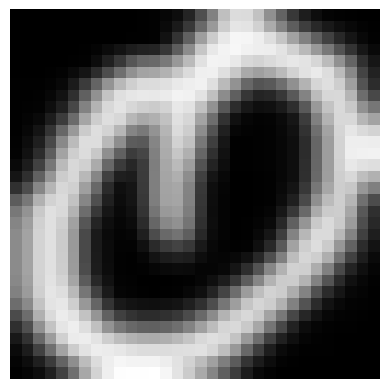

Shape of Original Image for class 5: torch.Size([1, 32, 32])
Displaying the first image with label 5:


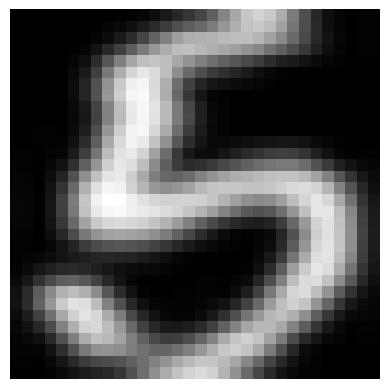

Shape of Original Image for class 8: torch.Size([1, 32, 32])
Displaying the first image with label 8:


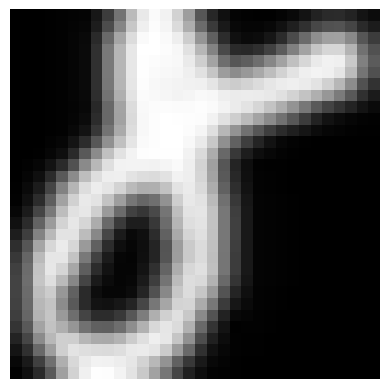

Shape of Original Image for class 7: torch.Size([1, 32, 32])
Displaying the first image with label 7:


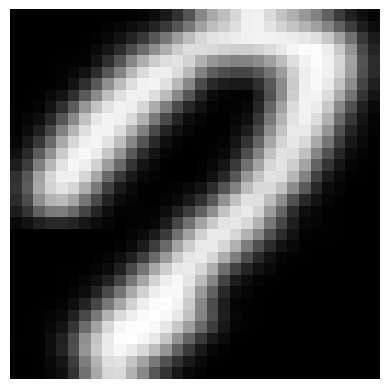

Shape of Original Image for class 9: torch.Size([1, 32, 32])
Displaying the first image with label 9:


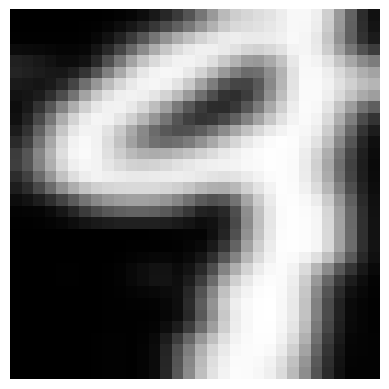


Displaying the corresponding classial reconstructed images:
Displaying reconstructed image for class 6 at index 0:


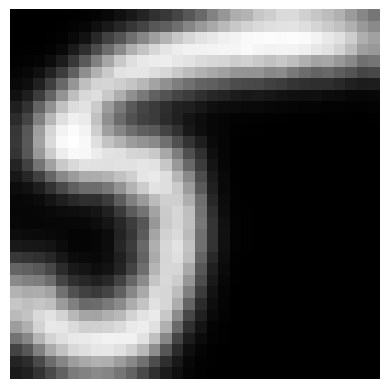

Displaying reconstructed image for class 2 at index 1:


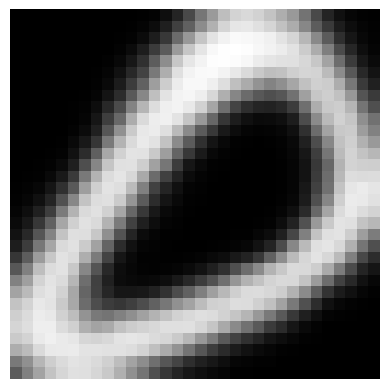

Displaying reconstructed image for class 3 at index 2:


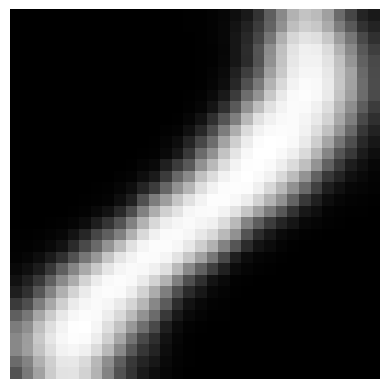

Displaying reconstructed image for class 1 at index 3:


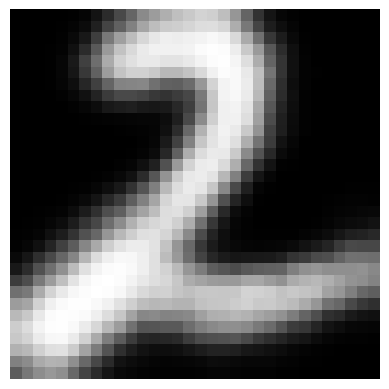

Displaying reconstructed image for class 4 at index 5:


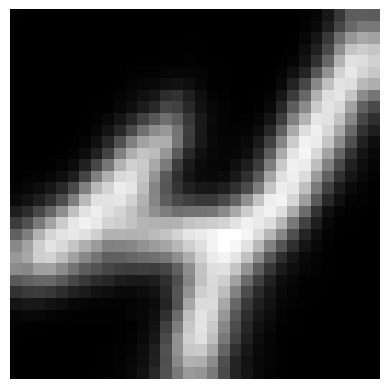

Displaying reconstructed image for class 0 at index 6:


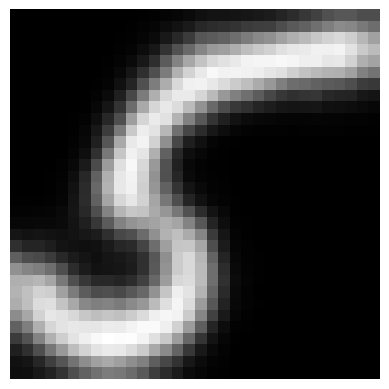

Displaying reconstructed image for class 5 at index 11:


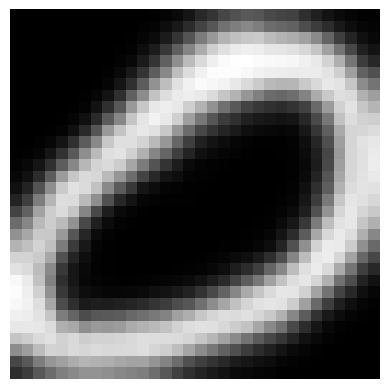

Displaying reconstructed image for class 8 at index 15:


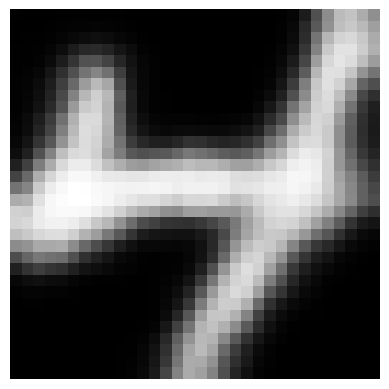

Displaying reconstructed image for class 7 at index 16:


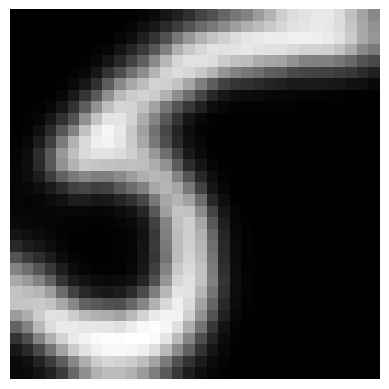

Displaying reconstructed image for class 9 at index 24:


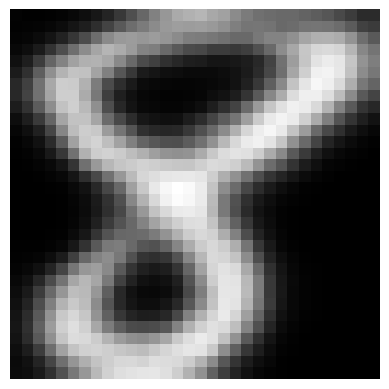

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to display an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize if necessary
    npimg = img.numpy()  # Convert tensor to NumPy array
    if npimg.ndim == 3 and npimg.shape[0] == 1:  # Grayscale image
        plt.imshow(npimg[0], cmap='gray')
    elif npimg.ndim == 2:  # Direct 2D grayscale image
        plt.imshow(npimg, cmap='gray')
    else:
        raise ValueError(f"Unsupported image shape: {npimg.shape}")

    plt.axis('off')  # Hide axes
    plt.show()

# Set up to track first occurrence of each class
first_indices = {}
class_labels = set()
found=False
# Loop through batches in the trainloader
for batch_idx, (q_images, images, labels) in enumerate(trainloader):
    for i in range(len(labels)):
        label = labels[i].item()  # Get label as integer
        if label not in class_labels:
            print(f"Shape of Original Image for class {label}: {images[i].shape}")
            print(f"Displaying the first image with label {label}:")
            imshow(images[i])  # Display the first image of this class

            first_indices[label] = batch_idx * len(labels) + i  # Store index
            class_labels.add(label)
            found=True

        if len(class_labels) == 10:  # Assuming USPS has 10 classes
            break
    if len(class_labels) == 10:
        break

# Now display the corresponding reconstructed images for the same indices
print("\nDisplaying the corresponding classial reconstructed images:")

for label, index in first_indices.items():
    print(f"Displaying reconstructed image for class {label} at index {index}:")
    reconstructed_image = q_reconstructed_images[index].view(1, 32, 32)  # Reshape if necessary
    imshow(reconstructed_image.detach().cpu())  # Detach and move to CPU for display

Visualizing transformations:   0%|          | 0/5 [00:00<?, ?it/s]

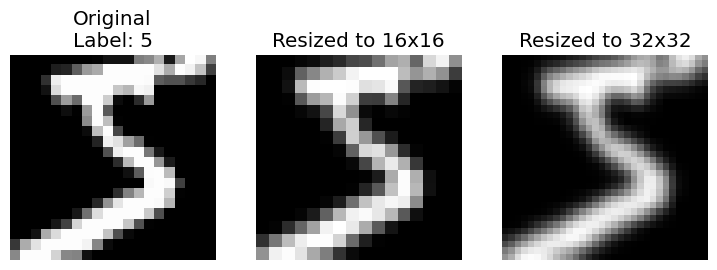

Visualizing transformations:  20%|██        | 1/5 [00:00<00:00,  6.60it/s]

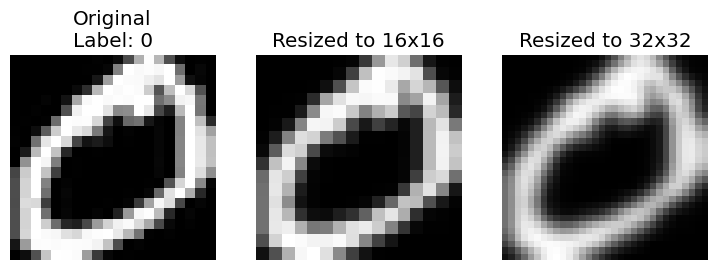

Visualizing transformations:  40%|████      | 2/5 [00:00<00:00,  5.93it/s]

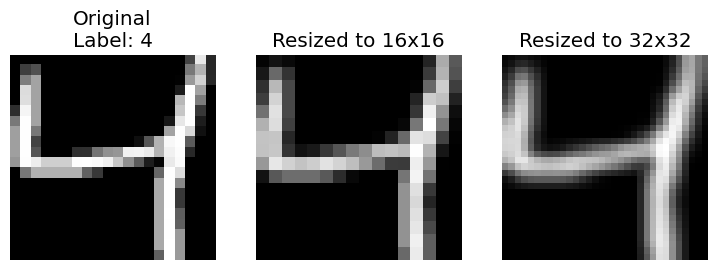

Visualizing transformations:  60%|██████    | 3/5 [00:00<00:00,  6.27it/s]

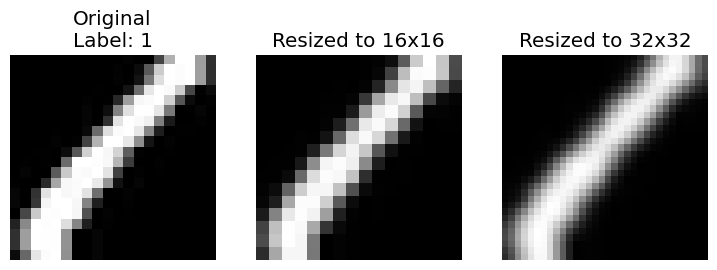

Visualizing transformations:  80%|████████  | 4/5 [00:00<00:00,  6.18it/s]

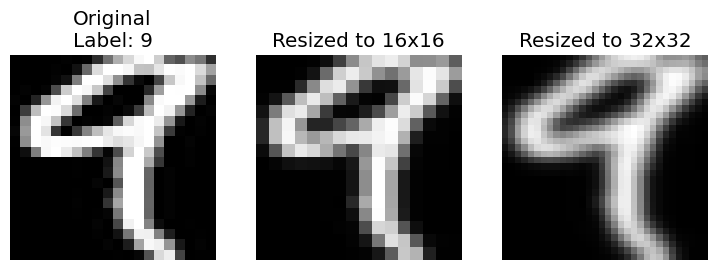

Visualizing transformations: 100%|██████████| 5/5 [00:00<00:00,  6.22it/s]

Transformation visualization completed.


In [31]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# Load the cropped MNIST images and targets
cropped_train_images = np.load('ccropped_train_images.npy', allow_pickle=True)  # Shape: (num_samples, 24, 24)
cropped_train_targets = np.load('ccropped_train_targets.npy', allow_pickle=True)  # Shape: (num_samples,)

# Define the transformation to resize images to 16x16 and then to 32x32
transform_16x16 = transforms.Resize((16, 16))  # Resize to 16x16
transform_32x32 = transforms.Resize((32, 32))  # Resize to 32x32

# Function to visualize images at each stage
def visualize_images(original, resized_16x16, resized_32x32, label):
    plt.figure(figsize=(9, 3))
    
    # Original cropped image
    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title(f'Original\nLabel: {label}')
    plt.axis('off')
    
    # Resized to 16x16
    plt.subplot(1, 3, 2)
    plt.imshow(resized_16x16, cmap='gray')
    plt.title('Resized to 16x16')
    plt.axis('off')
    
    # Resized to 32x32
    plt.subplot(1, 3, 3)
    plt.imshow(resized_32x32, cmap='gray')
    plt.title('Resized to 32x32')
    plt.axis('off')
    
    plt.show()

# Transform and visualize a subset of images
for i in tqdm(range(5), desc="Visualizing transformations"):
    # Original image as 24x24 numpy array
    original_image = cropped_train_images[i]
    
    # Convert to PIL image for transformations
    image_pil = Image.fromarray((original_image * 255).astype(np.uint8))
    
    # First transformation: Resize to 16x16
    resized_16x16_image = transform_16x16(image_pil)
    
    # Second transformation: Resize 16x16 to 32x32
    resized_32x32_image = transform_32x32(resized_16x16_image)
    
    # Convert images back to numpy arrays for visualization
    original_array = np.array(original_image)
    resized_16x16_array = np.array(resized_16x16_image)
    resized_32x32_array = np.array(resized_32x32_image)
    
    # Visualize the transformations
    visualize_images(original_array, resized_16x16_array, resized_32x32_array, cropped_train_targets[i])

print("Transformation visualization completed.")